In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## Normalized

In [2]:
def build_constellation(M):
    """Normalized square QAM constellation and Gray mapping."""
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)
    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation) ** 2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels


def quantize_to_constellation(x, constellation):
    """Quantize to nearest constellation point."""
    x_flat = x.reshape(-1, 1)
    d2 = np.abs(x_flat - constellation.reshape(1, -1)) ** 2
    idx = np.argmin(d2, axis=1)
    return constellation[idx].reshape(x.shape), idx.reshape(x.shape)


def generate_channel(B, U):
    """Rayleigh fading channel."""
    return (np.random.randn(B, U) + 1j * np.random.randn(B, U)) / np.sqrt(2)

In [3]:
def mmse_detector(y, H, noise_var):
    HhH = H.conj().T @ H
    x_hat = np.linalg.inv(HhH + noise_var * np.eye(H.shape[1])) @ (H.conj().T @ y)
    return x_hat


def admm_detector(y, H, rho=0.1, max_iter=30, tol=1e-4):
    B, U = H.shape
    Hh = H.conj().T
    inv_matrix = np.linalg.inv(Hh @ H + rho * np.eye(U))
    Hy = Hh @ y
    x = np.zeros(U, dtype=complex)
    z = np.zeros(U, dtype=complex)
    lam = np.zeros(U, dtype=complex)
    for _ in range(max_iter):
        x = inv_matrix @ (Hy + rho * (z - lam))
        z_new = np.clip(np.real(x + lam), -1, 1) + 1j * np.clip(np.imag(x + lam), -1, 1)
        lam = lam + x - z_new
        if np.linalg.norm(x - z_new) < tol:
            break
        z = z_new
    return x

In [4]:
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        B, N, U = H.shape
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)
        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            inv = torch.linalg.inv(HhH + rho * I)
            x = torch.bmm(inv, (Hhy + rho * (z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

In [5]:
def ps_admm_detect(H, r, M, rho=1.0, alpha=0.01, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

In [6]:
def unified_simulation(B=16, U=16, M=4, trials=10000, snr_db_list=np.arange(0, 11, 0.5)):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))

    # Initialize models
    Q = int(np.sqrt(M)) // 2
    unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device)
    unfolded_psadmm = UnfoldedPSADMM(U, Q, L=10).to(device)

    ber = {name: [] for name in ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]}
    eps = 1e-6

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1 / snr_lin
        total_bits = U * bits_per_symbol * trials
        errors = {k: 0 for k in ber.keys()}

        for _ in range(trials):
            H = generate_channel(B, U)
            bits = np.random.randint(0, 2, (U, bits_per_symbol))
            x = np.array([constellation[int("".join(map(str, b)), 2)] for b in bits])
            n = np.sqrt(noise_var / 2) * (np.random.randn(B) + 1j * np.random.randn(B))
            y = H @ x + n

            # Classical detectors
            x_mm = mmse_detector(y, H, noise_var)
            x_admm = admm_detector(y, H)
            x_ps = ps_admm_detect(H, y, M)

            # Unfolded detectors
            H_t = torch.tensor(H, dtype=torch.cfloat, device=device).unsqueeze(0)
            y_t = torch.tensor(y, dtype=torch.cfloat, device=device).unsqueeze(0)
            with torch.no_grad():
                x_unf_admm = unfolded_admm(y_t, H_t).cpu().numpy()[0]
                x_unf_ps = unfolded_psadmm(H_t, y_t).cpu().numpy()[0]

            # Quantize
            _, idx_tx = quantize_to_constellation(x, constellation)
            _, idx_mm = quantize_to_constellation(x_mm, constellation)
            _, idx_a = quantize_to_constellation(x_admm, constellation)
            _, idx_unfa = quantize_to_constellation(x_unf_admm, constellation)
            _, idx_ps = quantize_to_constellation(x_ps, constellation)
            _, idx_unfps = quantize_to_constellation(x_unf_ps, constellation)

            # Bit errors
            errors["MMSE"] += np.sum(bit_labels[idx_mm] != bit_labels[idx_tx])
            errors["ADMM"] += np.sum(bit_labels[idx_a] != bit_labels[idx_tx])
            errors["Unfolded ADMM"] += np.sum(bit_labels[idx_unfa] != bit_labels[idx_tx])
            errors["PS-ADMM"] += np.sum(bit_labels[idx_ps] != bit_labels[idx_tx])
            errors["Unfolded PS-ADMM"] += np.sum(bit_labels[idx_unfps] != bit_labels[idx_tx])

        for k in ber.keys():
            ber[k].append(max(errors[k] / total_bits, eps))
        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

In [7]:
def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    order = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    markers = ['o', 's', '^', 'd', '*']
    for i, k in enumerate(order):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.title("16x16 4 QAM BER Comparison: MMSE, ADMM, Unfolded ADMM, PS-ADMM, Unfolded PS-ADMM")
    plt.legend()
    plt.show()


SNR=0.0 dB | MMSE=3.26e-02, ADMM=2.86e-02, Unfolded ADMM=1.86e-02, PS-ADMM=2.27e-02, Unfolded PS-ADMM=1.36e-02
SNR=0.5 dB | MMSE=2.88e-02, ADMM=2.44e-02, Unfolded ADMM=1.50e-02, PS-ADMM=1.92e-02, Unfolded PS-ADMM=1.04e-02
SNR=1.0 dB | MMSE=2.59e-02, ADMM=2.03e-02, Unfolded ADMM=1.16e-02, PS-ADMM=1.59e-02, Unfolded PS-ADMM=7.78e-03
SNR=1.5 dB | MMSE=2.32e-02, ADMM=1.73e-02, Unfolded ADMM=9.46e-03, PS-ADMM=1.37e-02, Unfolded PS-ADMM=6.16e-03
SNR=2.0 dB | MMSE=2.02e-02, ADMM=1.50e-02, Unfolded ADMM=7.64e-03, PS-ADMM=1.21e-02, Unfolded PS-ADMM=4.83e-03
SNR=2.5 dB | MMSE=1.79e-02, ADMM=1.22e-02, Unfolded ADMM=5.89e-03, PS-ADMM=9.98e-03, Unfolded PS-ADMM=3.52e-03
SNR=3.0 dB | MMSE=1.55e-02, ADMM=1.01e-02, Unfolded ADMM=4.45e-03, PS-ADMM=7.96e-03, Unfolded PS-ADMM=2.52e-03
SNR=3.5 dB | MMSE=1.30e-02, ADMM=8.10e-03, Unfolded ADMM=3.28e-03, PS-ADMM=6.53e-03, Unfolded PS-ADMM=1.72e-03
SNR=4.0 dB | MMSE=1.14e-02, ADMM=6.73e-03, Unfolded ADMM=2.61e-03, PS-ADMM=5.45e-03, Unfolded PS-ADMM=1.31e-03
S

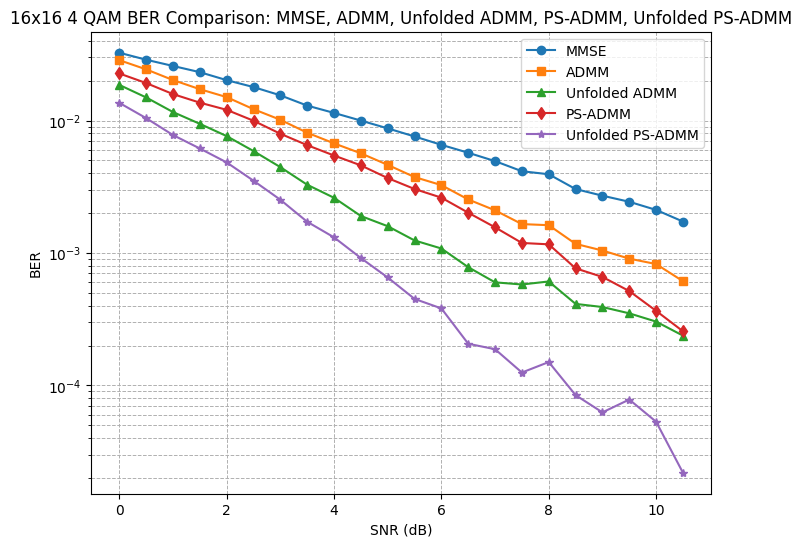

In [8]:
snr_db_list, ber = unified_simulation(trials=10000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

In [9]:
def ps_admm_detect(H, r, M, rho=1, alpha=2, T=30, beta=0.7):
    """
    Hard-clipped PS-ADMM detector with damping and adaptive alpha scaling.
    """
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])

    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))

    # Adaptive alpha (stabilizes denominator scaling)
    alpha_q = np.array([alpha * (1.0 + 0.2 * q) for q in range(Q)])

    for it in range(T):
        prev_sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)

        # Inner loop over Q parallel components
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            denom = np.maximum(np.abs(denom), 1e-3)  # prevent near-zero division
            x_new = (scales[q] / denom) * numer

            # Hard clipping projection
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)

        # Aggregate and update primal/dual variables
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs

        # Damped dual update to reduce oscillations
        sum_scaled = beta * sum_scaled + (1 - beta) * prev_sum_scaled
        y = y + rho * (x0 - sum_scaled)

    return np.sum(scales.reshape(-1, 1) * xq, axis=0)

In [10]:
def ps_admm_detect(H, r, M, rho=2.0, alpha=1, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

SNR=0.0 dB | MMSE=3.37e-02, ADMM=2.90e-02, Unfolded ADMM=1.85e-02, PS-ADMM=2.41e-02, Unfolded PS-ADMM=1.36e-02
SNR=0.5 dB | MMSE=2.92e-02, ADMM=2.42e-02, Unfolded ADMM=1.51e-02, PS-ADMM=2.08e-02, Unfolded PS-ADMM=1.06e-02
SNR=1.0 dB | MMSE=2.60e-02, ADMM=2.00e-02, Unfolded ADMM=1.19e-02, PS-ADMM=1.72e-02, Unfolded PS-ADMM=8.21e-03
SNR=1.5 dB | MMSE=2.27e-02, ADMM=1.73e-02, Unfolded ADMM=9.29e-03, PS-ADMM=1.49e-02, Unfolded PS-ADMM=6.00e-03
SNR=2.0 dB | MMSE=2.02e-02, ADMM=1.43e-02, Unfolded ADMM=7.29e-03, PS-ADMM=1.37e-02, Unfolded PS-ADMM=4.68e-03
SNR=2.5 dB | MMSE=1.69e-02, ADMM=1.20e-02, Unfolded ADMM=5.42e-03, PS-ADMM=1.11e-02, Unfolded PS-ADMM=3.25e-03
SNR=3.0 dB | MMSE=1.50e-02, ADMM=9.66e-03, Unfolded ADMM=4.48e-03, PS-ADMM=1.00e-02, Unfolded PS-ADMM=2.45e-03
SNR=3.5 dB | MMSE=1.32e-02, ADMM=8.02e-03, Unfolded ADMM=3.51e-03, PS-ADMM=8.87e-03, Unfolded PS-ADMM=1.82e-03
SNR=4.0 dB | MMSE=1.15e-02, ADMM=6.72e-03, Unfolded ADMM=2.71e-03, PS-ADMM=8.06e-03, Unfolded PS-ADMM=1.27e-03
S

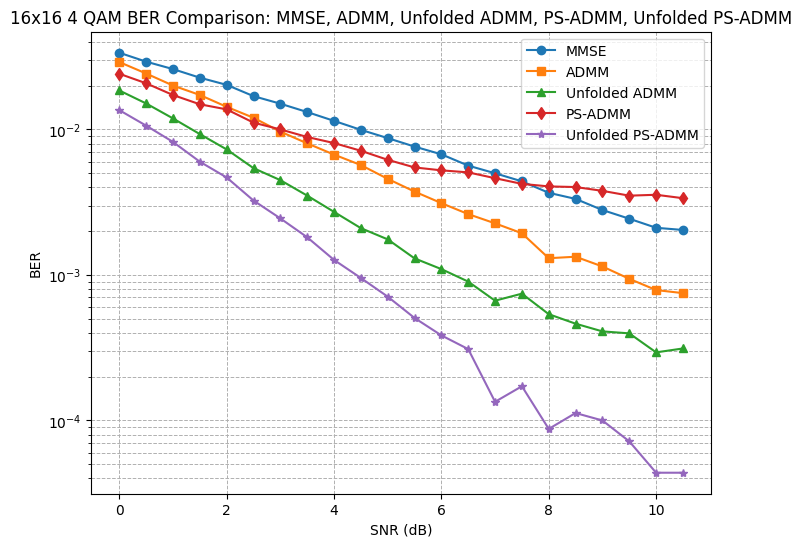

In [11]:
snr_db_list, ber = unified_simulation(trials=10000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

### 𝜌=0.1, 𝛼=0.01

In [12]:
def ps_admm_detect(H, r, M, rho=0.1, alpha=0.01, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

SNR=0.0 dB | MMSE=3.35e-02, ADMM=2.90e-02, Unfolded ADMM=1.85e-02, PS-ADMM=2.85e-02, Unfolded PS-ADMM=1.28e-02
SNR=0.5 dB | MMSE=2.94e-02, ADMM=2.57e-02, Unfolded ADMM=1.53e-02, PS-ADMM=2.49e-02, Unfolded PS-ADMM=1.12e-02
SNR=1.0 dB | MMSE=2.65e-02, ADMM=2.01e-02, Unfolded ADMM=1.16e-02, PS-ADMM=1.97e-02, Unfolded PS-ADMM=8.00e-03
SNR=1.5 dB | MMSE=2.28e-02, ADMM=1.78e-02, Unfolded ADMM=9.25e-03, PS-ADMM=1.74e-02, Unfolded PS-ADMM=6.19e-03
SNR=2.0 dB | MMSE=1.92e-02, ADMM=1.43e-02, Unfolded ADMM=6.91e-03, PS-ADMM=1.39e-02, Unfolded PS-ADMM=4.38e-03
SNR=2.5 dB | MMSE=1.65e-02, ADMM=1.16e-02, Unfolded ADMM=5.84e-03, PS-ADMM=1.12e-02, Unfolded PS-ADMM=3.37e-03
SNR=3.0 dB | MMSE=1.54e-02, ADMM=1.02e-02, Unfolded ADMM=4.72e-03, PS-ADMM=9.84e-03, Unfolded PS-ADMM=2.37e-03
SNR=3.5 dB | MMSE=1.35e-02, ADMM=8.09e-03, Unfolded ADMM=2.81e-03, PS-ADMM=7.56e-03, Unfolded PS-ADMM=1.56e-03
SNR=4.0 dB | MMSE=1.16e-02, ADMM=6.78e-03, Unfolded ADMM=2.47e-03, PS-ADMM=6.19e-03, Unfolded PS-ADMM=1.22e-03
S

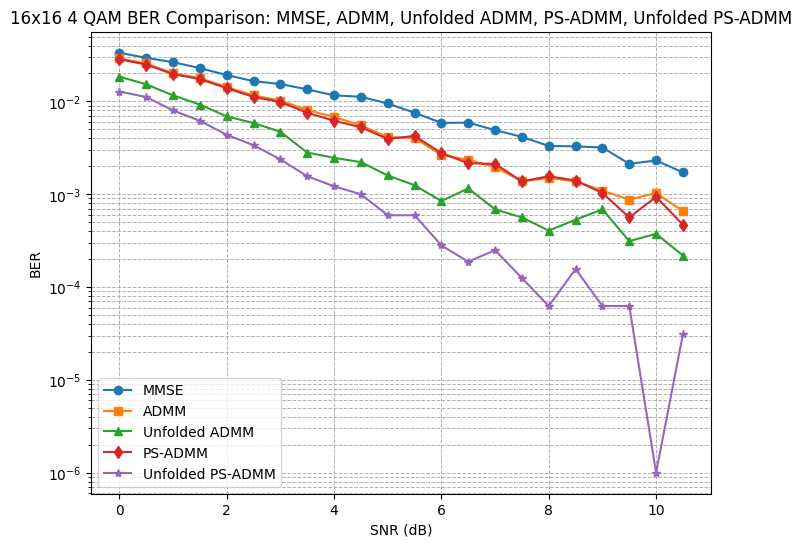

In [13]:
snr_db_list, ber = unified_simulation(trials=1000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

### 𝜌=2, 𝛼=0.1

In [18]:
def ps_admm_detect(H, r, M, rho=2, alpha=0.1, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

SNR=0.0 dB | MMSE=3.48e-02, ADMM=3.07e-02, Unfolded ADMM=1.99e-02, PS-ADMM=2.37e-02, Unfolded PS-ADMM=1.39e-02
SNR=0.5 dB | MMSE=2.94e-02, ADMM=2.37e-02, Unfolded ADMM=1.49e-02, PS-ADMM=1.74e-02, Unfolded PS-ADMM=1.05e-02
SNR=1.0 dB | MMSE=2.61e-02, ADMM=2.17e-02, Unfolded ADMM=1.28e-02, PS-ADMM=1.72e-02, Unfolded PS-ADMM=8.47e-03
SNR=1.5 dB | MMSE=2.39e-02, ADMM=1.85e-02, Unfolded ADMM=9.53e-03, PS-ADMM=1.36e-02, Unfolded PS-ADMM=6.03e-03
SNR=2.0 dB | MMSE=1.90e-02, ADMM=1.38e-02, Unfolded ADMM=6.94e-03, PS-ADMM=1.09e-02, Unfolded PS-ADMM=3.91e-03
SNR=2.5 dB | MMSE=1.73e-02, ADMM=1.29e-02, Unfolded ADMM=5.66e-03, PS-ADMM=1.01e-02, Unfolded PS-ADMM=3.69e-03
SNR=3.0 dB | MMSE=1.58e-02, ADMM=9.50e-03, Unfolded ADMM=4.28e-03, PS-ADMM=7.28e-03, Unfolded PS-ADMM=2.41e-03
SNR=3.5 dB | MMSE=1.34e-02, ADMM=8.22e-03, Unfolded ADMM=3.50e-03, PS-ADMM=5.84e-03, Unfolded PS-ADMM=2.03e-03
SNR=4.0 dB | MMSE=1.11e-02, ADMM=7.06e-03, Unfolded ADMM=2.78e-03, PS-ADMM=5.91e-03, Unfolded PS-ADMM=1.56e-03
S

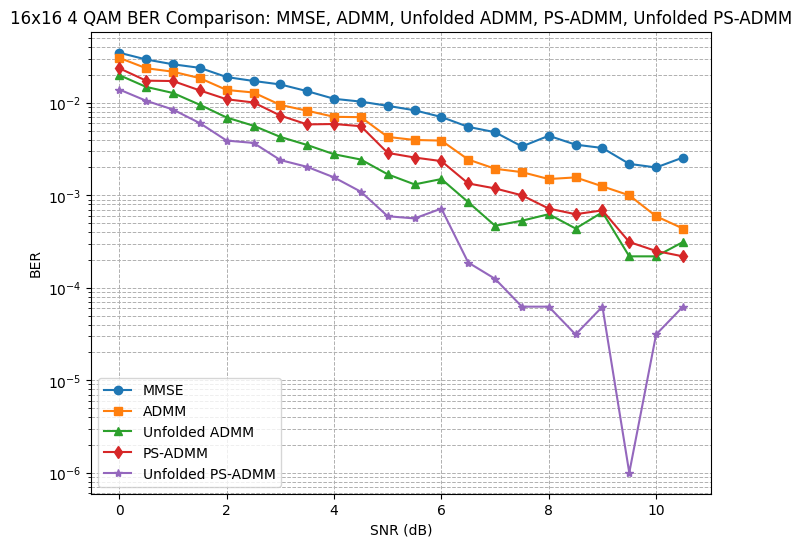

In [19]:
snr_db_list, ber = unified_simulation(trials=1000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

### 𝜌=2, 𝛼=0.09

In [20]:
def ps_admm_detect(H, r, M, rho=2, alpha=0.09, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

SNR=0.0 dB | MMSE=3.41e-02, ADMM=2.75e-02, Unfolded ADMM=1.88e-02, PS-ADMM=2.08e-02, Unfolded PS-ADMM=1.31e-02
SNR=0.5 dB | MMSE=2.81e-02, ADMM=2.38e-02, Unfolded ADMM=1.45e-02, PS-ADMM=1.90e-02, Unfolded PS-ADMM=1.03e-02
SNR=1.0 dB | MMSE=2.64e-02, ADMM=2.05e-02, Unfolded ADMM=1.19e-02, PS-ADMM=1.56e-02, Unfolded PS-ADMM=8.09e-03
SNR=1.5 dB | MMSE=2.14e-02, ADMM=1.69e-02, Unfolded ADMM=9.37e-03, PS-ADMM=1.33e-02, Unfolded PS-ADMM=5.72e-03
SNR=2.0 dB | MMSE=1.99e-02, ADMM=1.50e-02, Unfolded ADMM=7.19e-03, PS-ADMM=1.19e-02, Unfolded PS-ADMM=4.75e-03
SNR=2.5 dB | MMSE=1.77e-02, ADMM=1.14e-02, Unfolded ADMM=5.44e-03, PS-ADMM=8.28e-03, Unfolded PS-ADMM=3.16e-03
SNR=3.0 dB | MMSE=1.51e-02, ADMM=9.69e-03, Unfolded ADMM=4.56e-03, PS-ADMM=7.41e-03, Unfolded PS-ADMM=2.59e-03
SNR=3.5 dB | MMSE=1.37e-02, ADMM=7.66e-03, Unfolded ADMM=3.78e-03, PS-ADMM=5.66e-03, Unfolded PS-ADMM=2.13e-03
SNR=4.0 dB | MMSE=1.22e-02, ADMM=8.59e-03, Unfolded ADMM=3.19e-03, PS-ADMM=6.62e-03, Unfolded PS-ADMM=1.91e-03
S

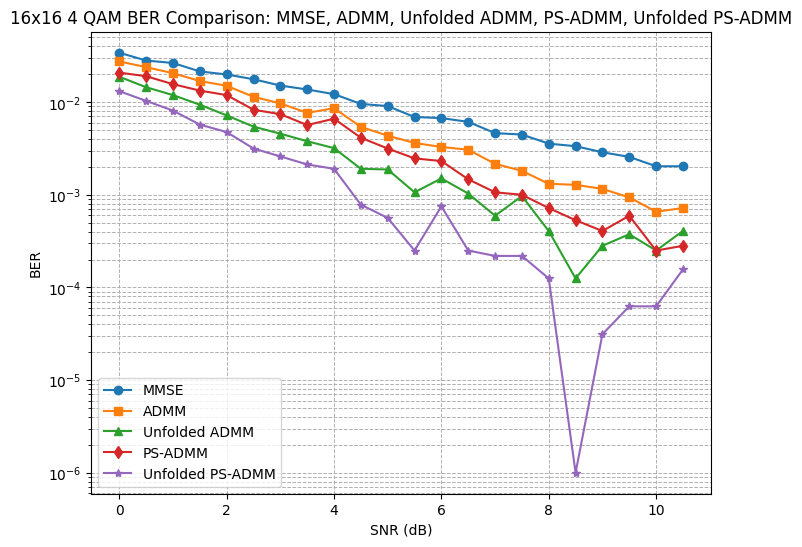

In [22]:
snr_db_list, ber = unified_simulation(trials=1000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

### 𝜌=2, 𝛼=0.08

In [23]:
def ps_admm_detect(H, r, M, rho=2, alpha=0.08, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

SNR=0.0 dB | MMSE=3.41e-02, ADMM=2.90e-02, Unfolded ADMM=1.91e-02, PS-ADMM=2.24e-02, Unfolded PS-ADMM=1.38e-02
SNR=0.5 dB | MMSE=3.00e-02, ADMM=2.43e-02, Unfolded ADMM=1.51e-02, PS-ADMM=1.90e-02, Unfolded PS-ADMM=1.09e-02
SNR=1.0 dB | MMSE=2.41e-02, ADMM=1.74e-02, Unfolded ADMM=9.97e-03, PS-ADMM=1.31e-02, Unfolded PS-ADMM=6.66e-03
SNR=1.5 dB | MMSE=2.13e-02, ADMM=1.56e-02, Unfolded ADMM=8.41e-03, PS-ADMM=1.23e-02, Unfolded PS-ADMM=5.88e-03
SNR=2.0 dB | MMSE=1.88e-02, ADMM=1.49e-02, Unfolded ADMM=6.28e-03, PS-ADMM=1.10e-02, Unfolded PS-ADMM=4.06e-03
SNR=2.5 dB | MMSE=1.93e-02, ADMM=1.21e-02, Unfolded ADMM=5.91e-03, PS-ADMM=8.66e-03, Unfolded PS-ADMM=3.34e-03
SNR=3.0 dB | MMSE=1.50e-02, ADMM=9.19e-03, Unfolded ADMM=3.87e-03, PS-ADMM=6.94e-03, Unfolded PS-ADMM=2.41e-03
SNR=3.5 dB | MMSE=1.38e-02, ADMM=7.53e-03, Unfolded ADMM=3.34e-03, PS-ADMM=5.72e-03, Unfolded PS-ADMM=1.56e-03
SNR=4.0 dB | MMSE=1.18e-02, ADMM=6.06e-03, Unfolded ADMM=2.47e-03, PS-ADMM=4.25e-03, Unfolded PS-ADMM=9.37e-04
S

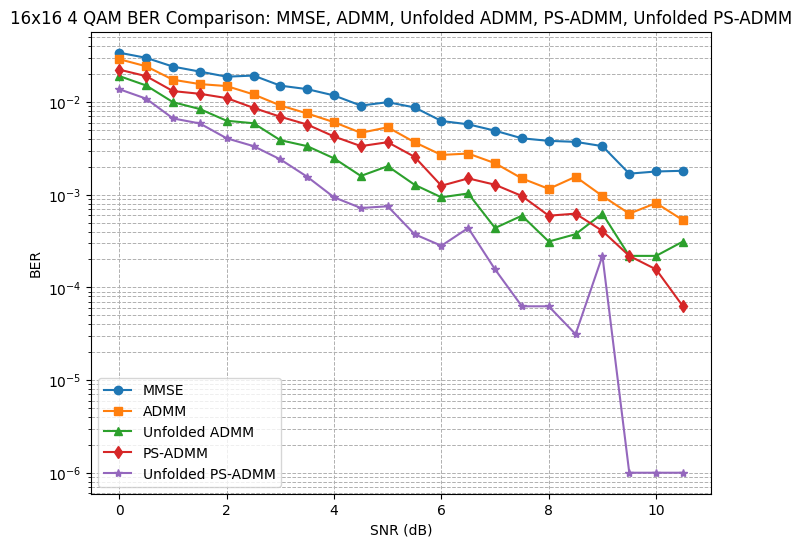

In [24]:
snr_db_list, ber = unified_simulation(trials=1000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

### 𝜌=2, 𝛼=0.05

In [25]:
def ps_admm_detect(H, r, M, rho=2, alpha=0.05, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

SNR=0.0 dB | MMSE=3.16e-02, ADMM=2.78e-02, Unfolded ADMM=1.79e-02, PS-ADMM=2.20e-02, Unfolded PS-ADMM=1.32e-02
SNR=0.5 dB | MMSE=3.11e-02, ADMM=2.56e-02, Unfolded ADMM=1.58e-02, PS-ADMM=2.02e-02, Unfolded PS-ADMM=1.15e-02
SNR=1.0 dB | MMSE=2.64e-02, ADMM=2.09e-02, Unfolded ADMM=1.29e-02, PS-ADMM=1.63e-02, Unfolded PS-ADMM=8.75e-03
SNR=1.5 dB | MMSE=2.34e-02, ADMM=1.88e-02, Unfolded ADMM=1.03e-02, PS-ADMM=1.46e-02, Unfolded PS-ADMM=7.06e-03
SNR=2.0 dB | MMSE=2.06e-02, ADMM=1.48e-02, Unfolded ADMM=8.22e-03, PS-ADMM=1.15e-02, Unfolded PS-ADMM=5.09e-03
SNR=2.5 dB | MMSE=1.53e-02, ADMM=1.03e-02, Unfolded ADMM=4.28e-03, PS-ADMM=7.13e-03, Unfolded PS-ADMM=2.53e-03
SNR=3.0 dB | MMSE=1.65e-02, ADMM=9.81e-03, Unfolded ADMM=4.81e-03, PS-ADMM=7.78e-03, Unfolded PS-ADMM=2.84e-03
SNR=3.5 dB | MMSE=1.51e-02, ADMM=9.41e-03, Unfolded ADMM=4.19e-03, PS-ADMM=7.19e-03, Unfolded PS-ADMM=2.25e-03
SNR=4.0 dB | MMSE=1.06e-02, ADMM=6.56e-03, Unfolded ADMM=2.34e-03, PS-ADMM=5.09e-03, Unfolded PS-ADMM=1.12e-03
S

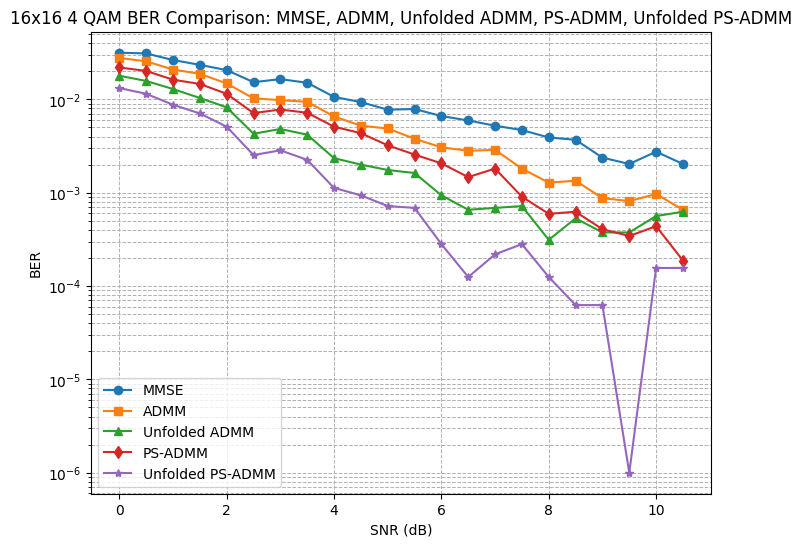

In [26]:
snr_db_list, ber = unified_simulation(trials=1000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

### 𝜌=2, 𝛼=0.01

In [27]:
def ps_admm_detect(H, r, M, rho=2, alpha=0.01, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

SNR=0.0 dB | MMSE=3.32e-02, ADMM=2.74e-02, Unfolded ADMM=1.88e-02, PS-ADMM=2.27e-02, Unfolded PS-ADMM=1.37e-02
SNR=0.5 dB | MMSE=2.88e-02, ADMM=2.58e-02, Unfolded ADMM=1.58e-02, PS-ADMM=1.92e-02, Unfolded PS-ADMM=1.06e-02
SNR=1.0 dB | MMSE=2.52e-02, ADMM=1.77e-02, Unfolded ADMM=1.11e-02, PS-ADMM=1.42e-02, Unfolded PS-ADMM=7.31e-03
SNR=1.5 dB | MMSE=2.42e-02, ADMM=1.84e-02, Unfolded ADMM=1.01e-02, PS-ADMM=1.42e-02, Unfolded PS-ADMM=6.66e-03
SNR=2.0 dB | MMSE=2.20e-02, ADMM=1.43e-02, Unfolded ADMM=8.78e-03, PS-ADMM=1.13e-02, Unfolded PS-ADMM=5.66e-03
SNR=2.5 dB | MMSE=1.67e-02, ADMM=1.08e-02, Unfolded ADMM=4.81e-03, PS-ADMM=8.19e-03, Unfolded PS-ADMM=3.19e-03
SNR=3.0 dB | MMSE=1.43e-02, ADMM=1.00e-02, Unfolded ADMM=3.81e-03, PS-ADMM=7.09e-03, Unfolded PS-ADMM=2.06e-03
SNR=3.5 dB | MMSE=1.36e-02, ADMM=8.03e-03, Unfolded ADMM=3.72e-03, PS-ADMM=5.97e-03, Unfolded PS-ADMM=1.81e-03
SNR=4.0 dB | MMSE=1.18e-02, ADMM=7.22e-03, Unfolded ADMM=2.84e-03, PS-ADMM=5.44e-03, Unfolded PS-ADMM=1.31e-03
S

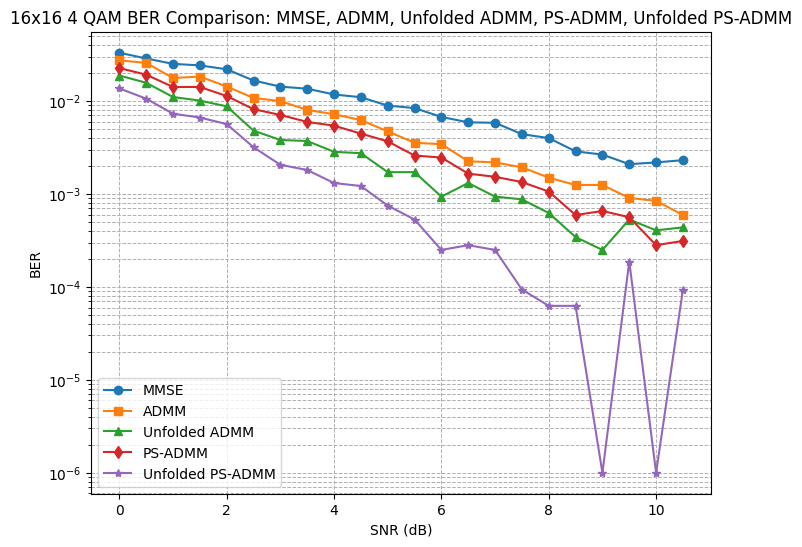

In [28]:
snr_db_list, ber = unified_simulation(trials=1000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

In [29]:
def ps_admm_detect(H, r, M, rho=1.5, alpha=0.01, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

SNR=0.0 dB | MMSE=3.29e-02, ADMM=2.96e-02, Unfolded ADMM=1.87e-02, PS-ADMM=2.33e-02, Unfolded PS-ADMM=1.41e-02
SNR=0.5 dB | MMSE=3.10e-02, ADMM=2.65e-02, Unfolded ADMM=1.60e-02, PS-ADMM=2.07e-02, Unfolded PS-ADMM=1.10e-02
SNR=1.0 dB | MMSE=2.70e-02, ADMM=2.25e-02, Unfolded ADMM=1.29e-02, PS-ADMM=1.81e-02, Unfolded PS-ADMM=8.87e-03
SNR=1.5 dB | MMSE=2.25e-02, ADMM=1.63e-02, Unfolded ADMM=8.19e-03, PS-ADMM=1.27e-02, Unfolded PS-ADMM=5.44e-03
SNR=2.0 dB | MMSE=1.99e-02, ADMM=1.47e-02, Unfolded ADMM=6.88e-03, PS-ADMM=1.12e-02, Unfolded PS-ADMM=4.59e-03
SNR=2.5 dB | MMSE=1.75e-02, ADMM=1.25e-02, Unfolded ADMM=6.37e-03, PS-ADMM=1.09e-02, Unfolded PS-ADMM=4.00e-03
SNR=3.0 dB | MMSE=1.44e-02, ADMM=9.72e-03, Unfolded ADMM=4.62e-03, PS-ADMM=7.62e-03, Unfolded PS-ADMM=2.66e-03
SNR=3.5 dB | MMSE=1.49e-02, ADMM=8.75e-03, Unfolded ADMM=4.13e-03, PS-ADMM=6.62e-03, Unfolded PS-ADMM=1.84e-03
SNR=4.0 dB | MMSE=1.23e-02, ADMM=6.50e-03, Unfolded ADMM=2.75e-03, PS-ADMM=4.84e-03, Unfolded PS-ADMM=1.31e-03
S

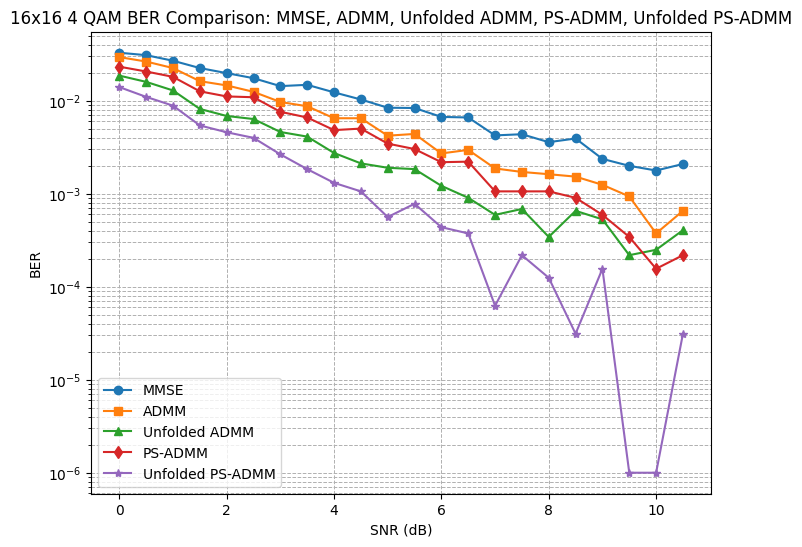

In [30]:
snr_db_list, ber = unified_simulation(trials=1000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

Searching for optimal hyperparameters...
PS-ADMM Search:


PS-ADMM ρ: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:13<00:00,  3.68s/it]



PS-ADMM Best: ρ=0.10, α=0.01, BER=inf

Unfolded PS-ADMM Search:


Unfolded ρ: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [02:00<00:00,  6.02s/it]

Unfolded PS-ADMM Best: ρ=0.20, α=0.01, BER=0.0000

 OPTIMAL HYPERPARAMETERS 
PS-ADMM: ρ = 0.10, α = 0.01
Unfolded PS-ADMM: ρ = 0.20, α = 0.01


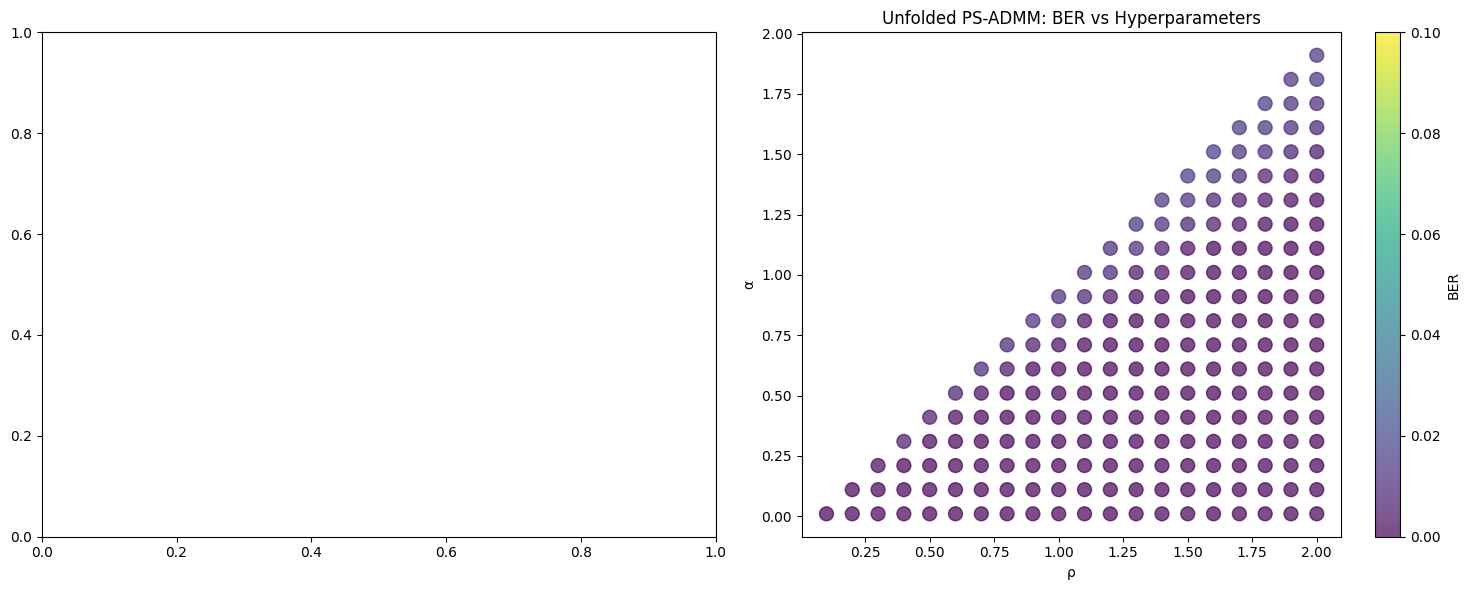


 RUNNING OPTIMIZED SIMULATION
SNR=0.0 dB | MMSE=3.36e-02, ADMM=2.84e-02, PS-ADMM=2.78e-02, Unfolded PS-ADMM=2.64e-02
SNR=0.5 dB | MMSE=2.78e-02, ADMM=2.16e-02, PS-ADMM=2.11e-02, Unfolded PS-ADMM=1.95e-02
SNR=1.0 dB | MMSE=2.75e-02, ADMM=2.03e-02, PS-ADMM=1.98e-02, Unfolded PS-ADMM=1.67e-02
SNR=1.5 dB | MMSE=2.21e-02, ADMM=1.69e-02, PS-ADMM=1.64e-02, Unfolded PS-ADMM=1.27e-02
SNR=2.0 dB | MMSE=1.99e-02, ADMM=1.43e-02, PS-ADMM=1.42e-02, Unfolded PS-ADMM=1.05e-02
SNR=2.5 dB | MMSE=1.69e-02, ADMM=1.23e-02, PS-ADMM=1.20e-02, Unfolded PS-ADMM=8.47e-03
SNR=3.0 dB | MMSE=1.60e-02, ADMM=1.09e-02, PS-ADMM=1.09e-02, Unfolded PS-ADMM=7.13e-03
SNR=3.5 dB | MMSE=1.44e-02, ADMM=9.69e-03, PS-ADMM=9.31e-03, Unfolded PS-ADMM=5.97e-03
SNR=4.0 dB | MMSE=1.17e-02, ADMM=6.25e-03, PS-ADMM=5.91e-03, Unfolded PS-ADMM=3.25e-03
SNR=4.5 dB | MMSE=1.01e-02, ADMM=5.66e-03, PS-ADMM=5.28e-03, Unfolded PS-ADMM=3.03e-03
SNR=5.0 dB | MMSE=9.37e-03, ADMM=4.41e-03, PS-ADMM=4.22e-03, Unfolded PS-ADMM=1.56e-03
SNR=5.5 dB |

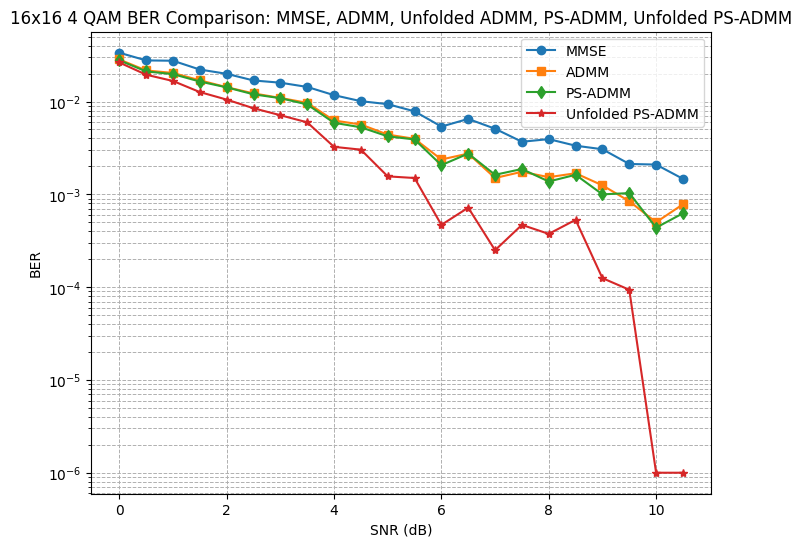

In [32]:
def find_optimal_hyperparameters(B=16, U=16, M=4, trials=1000, target_snr=10):
    """Find optimal rho and alpha values for PS-ADMM and unfolded PS-ADMM."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    Q = int(np.sqrt(M)) // 2
    
    # Define search ranges
    rho_range = np.arange(0.1, 2.01, 0.1)  # 0.1 to 2.0 in steps of 0.1
    alpha_range = np.arange(0.01, 2.01, 0.1)  # 0.01 to 2.0 in steps of 0.1
    
    snr_lin = 10 ** (target_snr / 10)
    noise_var = 1 / snr_lin
    
    best_rho_ps, best_alpha_ps = 0.1, 0.01
    best_rho_unf, best_alpha_unf = 0.1, 0.01
    best_ber_ps = float('inf')
    best_ber_unf = float('inf')
    
    # Track convergence metrics
    convergence_data = []
    
    print("Searching for optimal hyperparameters...")
    print("PS-ADMM Search:")
    
    for rho in tqdm(rho_range, desc="PS-ADMM ρ"):
        for alpha in alpha_range:
            if alpha >= rho * (4 ** (Q-1)):  # Skip invalid combinations
                continue
                
            total_errors = 0
            total_bits = 0
            convergence_issues = 0
            
            for _ in range(trials):
                H = generate_channel(B, U)
                bits = np.random.randint(0, 2, (U, bits_per_symbol))
                x = np.array([constellation[int("".join(map(str, b)), 2)] for b in bits])
                n = np.sqrt(noise_var / 2) * (np.random.randn(B) + 1j * np.random.randn(B))
                y = H @ x + n
                
                # PS-ADMM detection
                x_ps = ps_admm_detect(H, y, M, rho=rho, alpha=alpha, T=30)
                
                # Check for oscillations by running multiple iterations
                x_prev = np.zeros_like(x_ps)
                oscillation_detected = False
                for check_iter in range(5):
                    x_check = ps_admm_detect(H, y, M, rho=rho, alpha=alpha, T=check_iter+1)
                    if np.max(np.abs(x_check - x_prev)) > 0.1 and check_iter > 0:
                        oscillation_detected = True
                        break
                    x_prev = x_check
                
                if oscillation_detected:
                    convergence_issues += 1
                    continue
                
                # Quantize and count errors
                _, idx_ps = quantize_to_constellation(x_ps, constellation)
                _, idx_tx = quantize_to_constellation(x, constellation)
                total_errors += np.sum(bit_labels[idx_ps] != bit_labels[idx_tx])
                total_bits += U * bits_per_symbol
            
            if total_bits == 0:
                continue
                
            ber = total_errors / total_bits
            convergence_rate = 1 - (convergence_issues / trials)
            
            # Prefer combinations with good convergence and low BER
            if convergence_rate > 0.95 and ber < best_ber_ps:
                best_ber_ps = ber
                best_rho_ps = rho
                best_alpha_ps = alpha
                
            convergence_data.append(('PS-ADMM', rho, alpha, ber, convergence_rate))
    
    print(f"\nPS-ADMM Best: ρ={best_rho_ps:.2f}, α={best_alpha_ps:.2f}, BER={best_ber_ps:.4f}")
    
    # Search for unfolded PS-ADMM
    print("\nUnfolded PS-ADMM Search:")
    
    for rho in tqdm(rho_range, desc="Unfolded ρ"):
        for alpha in alpha_range:
            if alpha >= rho * (4 ** (Q-1)):
                continue
                
            # Create model with current hyperparameters
            model = UnfoldedPSADMM(U, Q, L=10).to(device)
            # Manually set parameters
            with torch.no_grad():
                model.rho.data = torch.ones(10, device=device) * rho
                model.alpha.data = torch.ones(10, device=device) * alpha
            
            total_errors = 0
            total_bits = 0
            convergence_issues = 0
            
            for _ in range(trials):
                H = generate_channel(B, U)
                bits = np.random.randint(0, 2, (U, bits_per_symbol))
                x = np.array([constellation[int("".join(map(str, b)), 2)] for b in bits])
                n = np.sqrt(noise_var / 2) * (np.random.randn(B) + 1j * np.random.randn(B))
                y = H @ x + n
                
                # Unfolded PS-ADMM detection
                H_t = torch.tensor(H, dtype=torch.cfloat, device=device).unsqueeze(0)
                y_t = torch.tensor(y, dtype=torch.cfloat, device=device).unsqueeze(0)
                
                with torch.no_grad():
                    x_unf_ps = model(H_t, y_t).cpu().numpy()[0]
                
                # Check convergence by comparing intermediate layers (simplified)
                # For unfolded, we trust the learned convergence more
                
                # Quantize and count errors
                _, idx_unfps = quantize_to_constellation(x_unf_ps, constellation)
                _, idx_tx = quantize_to_constellation(x, constellation)
                total_errors += np.sum(bit_labels[idx_unfps] != bit_labels[idx_tx])
                total_bits += U * bits_per_symbol
            
            if total_bits == 0:
                continue
                
            ber = total_errors / total_bits
            
            if ber < best_ber_unf:
                best_ber_unf = ber
                best_rho_unf = rho
                best_alpha_unf = alpha
                
            convergence_data.append(('Unfolded', rho, alpha, ber, 1.0))
    
    print(f"Unfolded PS-ADMM Best: ρ={best_rho_unf:.2f}, α={best_alpha_unf:.2f}, BER={best_ber_unf:.4f}")
    
    return (best_rho_ps, best_alpha_ps), (best_rho_unf, best_alpha_unf), convergence_data

def plot_convergence_analysis(convergence_data):
    """Plot the convergence behavior for different hyperparameter combinations."""
    ps_data = [d for d in convergence_data if d[0] == 'PS-ADMM']
    unf_data = [d for d in convergence_data if d[0] == 'Unfolded']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # PS-ADMM convergence plot
    if ps_data:
        rhos = [d[1] for d in ps_data]
        alphas = [d[2] for d in ps_data]
        bers = [d[3] for d in ps_data]
        conv_rates = [d[4] for d in ps_data]
        
        sc1 = axes[0].scatter(rhos, alphas, c=bers, cmap='viridis', 
                             s=100, alpha=0.7, vmin=0, vmax=0.1)
        axes[0].set_xlabel('ρ')
        axes[0].set_ylabel('α')
        axes[0].set_title('PS-ADMM: BER vs Hyperparameters')
        plt.colorbar(sc1, ax=axes[0], label='BER')
    
    # Unfolded PS-ADMM convergence plot
    if unf_data:
        rhos = [d[1] for d in unf_data]
        alphas = [d[2] for d in unf_data]
        bers = [d[3] for d in unf_data]
        
        sc2 = axes[1].scatter(rhos, alphas, c=bers, cmap='viridis', 
                             s=100, alpha=0.7, vmin=0, vmax=0.1)
        axes[1].set_xlabel('ρ')
        axes[1].set_ylabel('α')
        axes[1].set_title('Unfolded PS-ADMM: BER vs Hyperparameters')
        plt.colorbar(sc2, ax=axes[1], label='BER')
    
    plt.tight_layout()
    plt.show()

# Run the optimization
best_ps_params, best_unf_params, conv_data = find_optimal_hyperparameters(trials=500)

print(f"\n OPTIMAL HYPERPARAMETERS ")
print(f"PS-ADMM: ρ = {best_ps_params[0]:.2f}, α = {best_ps_params[1]:.2f}")
print(f"Unfolded PS-ADMM: ρ = {best_unf_params[0]:.2f}, α = {best_unf_params[1]:.2f}")

# Plot convergence analysis
plot_convergence_analysis(conv_data)

# Now run the main simulation with optimized parameters
def optimized_unified_simulation(B=16, U=16, M=4, trials=1000, 
                               snr_db_list=np.arange(0, 11, 0.5),
                               ps_params=None, unf_params=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    Q = int(np.sqrt(M)) // 2

    # Use optimized parameters
    if ps_params is None:
        ps_params = (0.1, 0.01)  # default
    
    # Initialize unfolded model with optimized parameters
    unfolded_psadmm = UnfoldedPSADMM(U, Q, L=10).to(device)
    if unf_params is not None:
        with torch.no_grad():
            unfolded_psadmm.rho.data = torch.ones(10, device=device) * unf_params[0]
            unfolded_psadmm.alpha.data = torch.ones(10, device=device) * unf_params[1]

    ber = {name: [] for name in ["MMSE", "ADMM", "PS-ADMM", "Unfolded PS-ADMM"]}
    eps = 1e-6

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1 / snr_lin
        total_bits = U * bits_per_symbol * trials
        errors = {k: 0 for k in ber.keys()}

        for _ in range(trials):
            H = generate_channel(B, U)
            bits = np.random.randint(0, 2, (U, bits_per_symbol))
            x = np.array([constellation[int("".join(map(str, b)), 2)] for b in bits])
            n = np.sqrt(noise_var / 2) * (np.random.randn(B) + 1j * np.random.randn(B))
            y = H @ x + n

            # Classical detectors with optimized parameters
            x_mm = mmse_detector(y, H, noise_var)
            x_admm = admm_detector(y, H)
            x_ps = ps_admm_detect(H, y, M, rho=ps_params[0], alpha=ps_params[1])

            # Unfolded detectors
            H_t = torch.tensor(H, dtype=torch.cfloat, device=device).unsqueeze(0)
            y_t = torch.tensor(y, dtype=torch.cfloat, device=device).unsqueeze(0)
            with torch.no_grad():
                x_unf_ps = unfolded_psadmm(H_t, y_t).cpu().numpy()[0]

            # Quantize
            _, idx_tx = quantize_to_constellation(x, constellation)
            _, idx_mm = quantize_to_constellation(x_mm, constellation)
            _, idx_a = quantize_to_constellation(x_admm, constellation)
            _, idx_ps = quantize_to_constellation(x_ps, constellation)
            _, idx_unfps = quantize_to_constellation(x_unf_ps, constellation)

            # Bit errors
            errors["MMSE"] += np.sum(bit_labels[idx_mm] != bit_labels[idx_tx])
            errors["ADMM"] += np.sum(bit_labels[idx_a] != bit_labels[idx_tx])
            errors["PS-ADMM"] += np.sum(bit_labels[idx_ps] != bit_labels[idx_tx])
            errors["Unfolded PS-ADMM"] += np.sum(bit_labels[idx_unfps] != bit_labels[idx_tx])

        for k in ber.keys():
            ber[k].append(max(errors[k] / total_bits, eps))
        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

# Run optimized simulation
print("\n RUNNING OPTIMIZED SIMULATION")
snr_db_list, ber_optimized = optimized_unified_simulation(
    trials=1000, 
    snr_db_list=np.arange(0, 11, 0.5),
    ps_params=best_ps_params,
    unf_params=best_unf_params
)

plot_unified(snr_db_list, ber_optimized)

In [33]:
def ps_admm_detect(H, r, M, rho=0.2, alpha=0.01, T=30):
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    y = np.zeros(U, dtype=np.complex128)
    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)
    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))
    for it in range(T):
        for q in range(Q):
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - y
        x0 = A_inv @ rhs
        y = y + rho * (x0 - sum_scaled)
    return np.sum(scales.reshape(-1, 1) * xq, axis=0)


class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch, B, U = H.shape
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=H.device)
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        for l in range(self.L):
            rho, alpha = self.rho[l], self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        return x0

SNR=0.0 dB | MMSE=3.26e-02, ADMM=2.86e-02, Unfolded ADMM=1.85e-02, PS-ADMM=2.43e-02, Unfolded PS-ADMM=1.35e-02
SNR=0.5 dB | MMSE=2.81e-02, ADMM=2.27e-02, Unfolded ADMM=1.45e-02, PS-ADMM=1.94e-02, Unfolded PS-ADMM=1.05e-02
SNR=1.0 dB | MMSE=2.64e-02, ADMM=2.02e-02, Unfolded ADMM=1.27e-02, PS-ADMM=1.76e-02, Unfolded PS-ADMM=7.88e-03
SNR=1.5 dB | MMSE=2.40e-02, ADMM=1.73e-02, Unfolded ADMM=9.84e-03, PS-ADMM=1.50e-02, Unfolded PS-ADMM=6.53e-03
SNR=2.0 dB | MMSE=2.04e-02, ADMM=1.54e-02, Unfolded ADMM=7.81e-03, PS-ADMM=1.40e-02, Unfolded PS-ADMM=4.87e-03
SNR=2.5 dB | MMSE=1.72e-02, ADMM=1.08e-02, Unfolded ADMM=5.56e-03, PS-ADMM=8.97e-03, Unfolded PS-ADMM=3.72e-03
SNR=3.0 dB | MMSE=1.74e-02, ADMM=1.01e-02, Unfolded ADMM=4.53e-03, PS-ADMM=9.06e-03, Unfolded PS-ADMM=2.25e-03
SNR=3.5 dB | MMSE=1.32e-02, ADMM=7.09e-03, Unfolded ADMM=2.84e-03, PS-ADMM=6.25e-03, Unfolded PS-ADMM=1.87e-03
SNR=4.0 dB | MMSE=1.39e-02, ADMM=7.16e-03, Unfolded ADMM=3.03e-03, PS-ADMM=6.22e-03, Unfolded PS-ADMM=1.37e-03
S

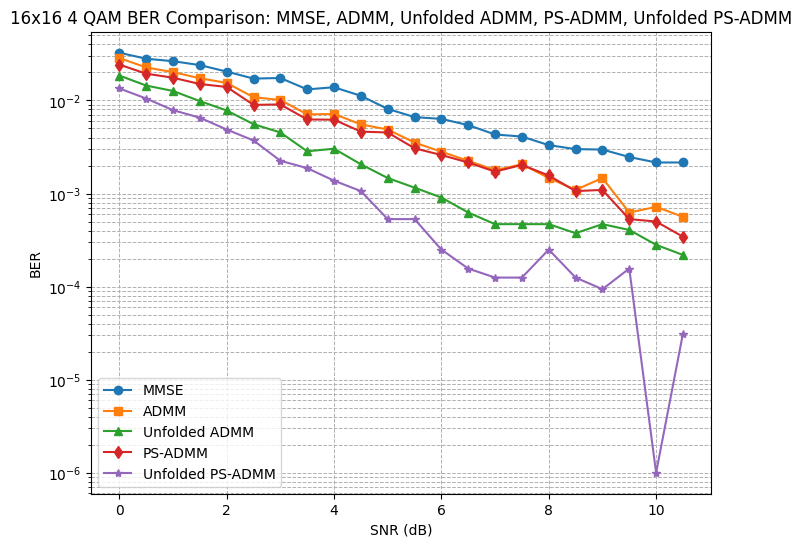

In [34]:
snr_db_list, ber = unified_simulation(trials=1000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)

Starting smooth MIMO simulation...


Processing SNRs:   5%|███                                                               | 1/22 [00:05<01:59,  5.68s/it]

SNR=  0.0 dB | MMSE: 3.37e-02 | ADMM: 2.88e-02 | Unfolded: 1.87e-02


Processing SNRs:   9%|██████                                                            | 2/22 [00:10<01:48,  5.41s/it]

SNR=  0.5 dB | MMSE: 2.93e-02 | ADMM: 2.40e-02 | Unfolded: 1.47e-02


Processing SNRs:  14%|█████████                                                         | 3/22 [00:15<01:36,  5.10s/it]

SNR=  1.0 dB | MMSE: 2.58e-02 | ADMM: 2.02e-02 | Unfolded: 1.17e-02


Processing SNRs:  18%|████████████                                                      | 4/22 [00:20<01:32,  5.16s/it]

SNR=  1.5 dB | MMSE: 2.29e-02 | ADMM: 1.76e-02 | Unfolded: 9.74e-03


Processing SNRs:  23%|███████████████                                                   | 5/22 [00:26<01:28,  5.18s/it]

SNR=  2.0 dB | MMSE: 2.02e-02 | ADMM: 1.43e-02 | Unfolded: 7.49e-03


Processing SNRs:  27%|██████████████████                                                | 6/22 [00:31<01:22,  5.14s/it]

SNR=  2.5 dB | MMSE: 1.77e-02 | ADMM: 1.19e-02 | Unfolded: 5.87e-03


Processing SNRs:  32%|█████████████████████                                             | 7/22 [00:36<01:15,  5.04s/it]

SNR=  3.0 dB | MMSE: 1.50e-02 | ADMM: 9.71e-03 | Unfolded: 4.27e-03


Processing SNRs:  36%|████████████████████████                                          | 8/22 [00:41<01:10,  5.07s/it]

SNR=  3.5 dB | MMSE: 1.36e-02 | ADMM: 8.33e-03 | Unfolded: 3.61e-03


Processing SNRs:  41%|███████████████████████████                                       | 9/22 [00:46<01:06,  5.08s/it]

SNR=  4.0 dB | MMSE: 1.16e-02 | ADMM: 6.84e-03 | Unfolded: 2.79e-03


Processing SNRs:  45%|█████████████████████████████▌                                   | 10/22 [00:51<01:00,  5.02s/it]

SNR=  4.5 dB | MMSE: 9.74e-03 | ADMM: 5.21e-03 | Unfolded: 1.86e-03


Processing SNRs:  50%|████████████████████████████████▌                                | 11/22 [00:56<00:56,  5.14s/it]

SNR=  5.0 dB | MMSE: 8.67e-03 | ADMM: 4.51e-03 | Unfolded: 1.65e-03


Processing SNRs:  55%|███████████████████████████████████▍                             | 12/22 [01:01<00:50,  5.04s/it]

SNR=  5.5 dB | MMSE: 7.47e-03 | ADMM: 3.91e-03 | Unfolded: 1.29e-03


Processing SNRs:  59%|██████████████████████████████████████▍                          | 13/22 [01:06<00:45,  5.00s/it]

SNR=  6.0 dB | MMSE: 6.85e-03 | ADMM: 3.13e-03 | Unfolded: 1.12e-03


Processing SNRs:  64%|█████████████████████████████████████████▎                       | 14/22 [01:10<00:38,  4.83s/it]

SNR=  6.5 dB | MMSE: 5.62e-03 | ADMM: 2.44e-03 | Unfolded: 8.19e-04


Processing SNRs:  68%|████████████████████████████████████████████▎                    | 15/22 [01:15<00:34,  4.94s/it]

SNR=  7.0 dB | MMSE: 5.18e-03 | ADMM: 2.25e-03 | Unfolded: 7.19e-04


Processing SNRs:  73%|███████████████████████████████████████████████▎                 | 16/22 [01:20<00:28,  4.76s/it]

SNR=  7.5 dB | MMSE: 4.45e-03 | ADMM: 1.71e-03 | Unfolded: 6.81e-04


Processing SNRs:  77%|██████████████████████████████████████████████████▏              | 17/22 [01:24<00:22,  4.51s/it]

SNR=  8.0 dB | MMSE: 3.58e-03 | ADMM: 1.45e-03 | Unfolded: 4.94e-04


Processing SNRs:  82%|█████████████████████████████████████████████████████▏           | 18/22 [01:28<00:17,  4.33s/it]

SNR=  8.5 dB | MMSE: 2.96e-03 | ADMM: 1.11e-03 | Unfolded: 4.22e-04


Processing SNRs:  86%|████████████████████████████████████████████████████████▏        | 19/22 [01:31<00:12,  4.19s/it]

SNR=  9.0 dB | MMSE: 2.97e-03 | ADMM: 1.17e-03 | Unfolded: 3.81e-04


Processing SNRs:  91%|███████████████████████████████████████████████████████████      | 20/22 [01:35<00:07,  3.86s/it]

SNR=  9.5 dB | MMSE: 2.41e-03 | ADMM: 8.44e-04 | Unfolded: 4.09e-04


Processing SNRs:  95%|██████████████████████████████████████████████████████████████   | 21/22 [01:37<00:03,  3.52s/it]

SNR= 10.0 dB | MMSE: 2.09e-03 | ADMM: 7.38e-04 | Unfolded: 2.88e-04


Processing SNRs: 100%|█████████████████████████████████████████████████████████████████| 22/22 [01:40<00:00,  4.58s/it]

SNR= 10.5 dB | MMSE: 1.82e-03 | ADMM: 6.47e-04 | Unfolded: 2.34e-04


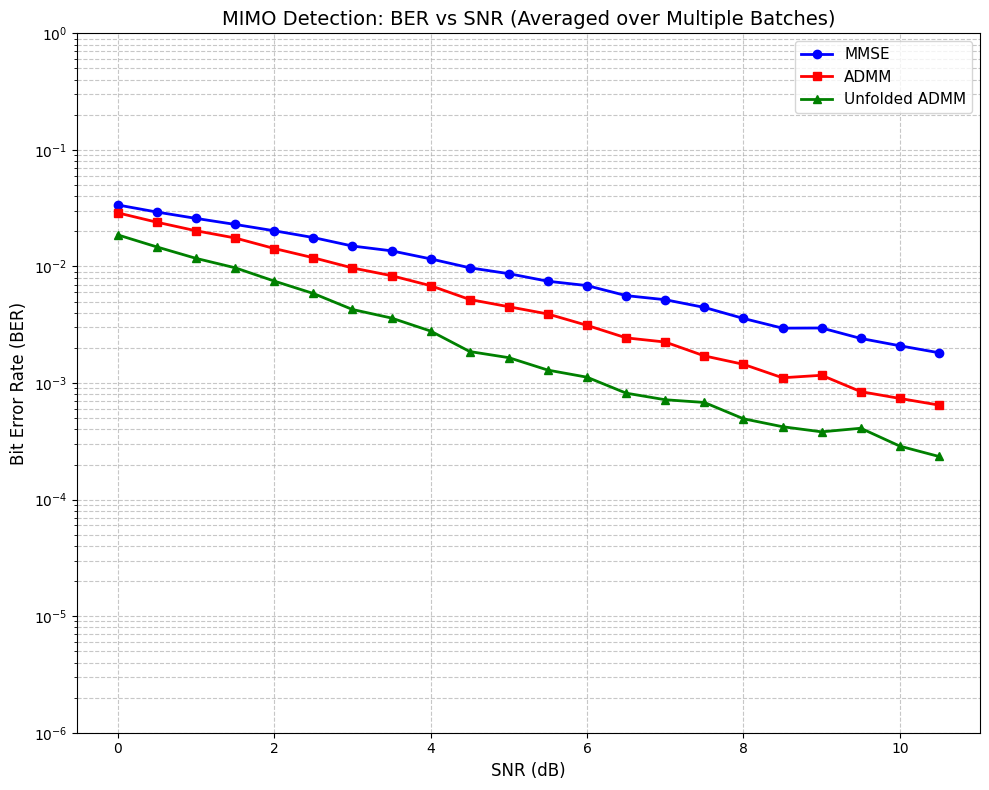

In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

def build_constellation(M):
    """Normalized square QAM constellation and Gray mapping."""
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)
    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation) ** 2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

def quantize_to_constellation(x, constellation):
    """Quantize to nearest constellation point."""
    x_flat = x.reshape(-1, 1)
    d2 = np.abs(x_flat - constellation.reshape(1, -1)) ** 2
    idx = np.argmin(d2, axis=1)
    return constellation[idx].reshape(x.shape), idx.reshape(x.shape)

def generate_channel_batch(B, U, batch_size):
    """Generate batch of Rayleigh fading channels."""
    return (np.random.randn(batch_size, B, U) + 1j * np.random.randn(batch_size, B, U)) / np.sqrt(2)

def generate_data_batch(B, U, M, batch_size, snr_db):
    """Generate batch of data similar to OTFS code structure."""
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1 / snr_lin
    
    # Generate channels
    H_batch = generate_channel_batch(B, U, batch_size)
    
    # Generate symbols
    bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
    x_batch = np.array([[constellation[int("".join(map(str, b)), 2)] for b in bits] for bits in bits_batch])
    
    # Generate noise
    n_batch = np.sqrt(noise_var / 2) * (np.random.randn(batch_size, B) + 1j * np.random.randn(batch_size, B))
    
    # Generate received signals
    y_batch = np.array([H_batch[i] @ x_batch[i] + n_batch[i] for i in range(batch_size)])
    
    return y_batch, H_batch, x_batch, bits_batch, constellation, bit_labels

def mmse_detector_batch(y_batch, H_batch, noise_var):
    """Batch MMSE detection."""
    batch_size = y_batch.shape[0]
    x_hat_batch = np.zeros_like(y_batch, dtype=complex)
    
    for i in range(batch_size):
        H = H_batch[i]
        y = y_batch[i]
        HhH = H.conj().T @ H
        x_hat_batch[i] = np.linalg.inv(HhH + noise_var * np.eye(H.shape[1])) @ (H.conj().T @ y)
    
    return x_hat_batch

def admm_detector_batch(y_batch, H_batch, rho=0.1, max_iter=30, tol=1e-4):
    """Batch ADMM detection."""
    batch_size, B = y_batch.shape
    U = H_batch.shape[2]
    x_hat_batch = np.zeros((batch_size, U), dtype=complex)
    
    for i in range(batch_size):
        y = y_batch[i]
        H = H_batch[i]
        Hh = H.conj().T
        inv_matrix = np.linalg.inv(Hh @ H + rho * np.eye(U))
        Hy = Hh @ y
        x = np.zeros(U, dtype=complex)
        z = np.zeros(U, dtype=complex)
        lam = np.zeros(U, dtype=complex)
        
        for _ in range(max_iter):
            x = inv_matrix @ (Hy + rho * (z - lam))
            z_new = np.clip(np.real(x + lam), -1, 1) + 1j * np.clip(np.imag(x + lam), -1, 1)
            lam = lam + x - z_new
            if np.linalg.norm(x - z_new) < tol:
                break
            z = z_new
        
        x_hat_batch[i] = x
    
    return x_hat_batch

class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        B, N, U = H.shape
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)
        
        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            inv = torch.linalg.inv(HhH + rho * I)
            x = torch.bmm(inv, (Hhy + rho * (z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
            
        return z

def calculate_ber_batch(x_hat_batch, x_true_batch, constellation, bit_labels):
    """Calculate BER for a batch of estimates."""
    batch_size = x_hat_batch.shape[0]
    total_errors = 0
    total_bits = 0
    
    for i in range(batch_size):
        # Quantize to constellation
        _, idx_true = quantize_to_constellation(x_true_batch[i], constellation)
        _, idx_hat = quantize_to_constellation(x_hat_batch[i], constellation)
        
        # Calculate bit errors
        bit_errors = np.sum(bit_labels[idx_hat] != bit_labels[idx_true])
        total_errors += bit_errors
        total_bits += len(x_true_batch[i]) * bit_labels.shape[1]
    
    return total_errors / total_bits if total_bits > 0 else 0

def unified_simulation_smooth(B=16, U=16, M=4, batch_size=100, num_batches=100, snr_db_list=np.arange(0, 11, 0.5)):
    """Modified simulation with batch processing for smooth curves."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Initialize models
    unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device)
    unfolded_admm.eval()  # Set to evaluation mode
    
    ber_results = {
        "MMSE": [],
        "ADMM": [], 
        "Unfolded ADMM": []
    }
    
    for snr_db in tqdm(snr_db_list, desc="Processing SNRs"):
        ber_mmse = 0
        ber_admm = 0
        ber_unfolded = 0
        
        # Process multiple batches per SNR (like the OTFS code)
        for batch_idx in range(num_batches):
            # Generate batch data
            y_batch, H_batch, x_batch, bits_batch, constellation, bit_labels = generate_data_batch(
                B, U, M, batch_size, snr_db
            )
            
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1 / snr_lin
            
            # MMSE detection
            x_mmse_batch = mmse_detector_batch(y_batch, H_batch, noise_var)
            ber_mmse += calculate_ber_batch(x_mmse_batch, x_batch, constellation, bit_labels)
            
            # ADMM detection
            x_admm_batch = admm_detector_batch(y_batch, H_batch)
            ber_admm += calculate_ber_batch(x_admm_batch, x_batch, constellation, bit_labels)
            
            # Unfolded ADMM detection
            H_tensor = torch.tensor(H_batch, dtype=torch.cfloat, device=device)
            y_tensor = torch.tensor(y_batch, dtype=torch.cfloat, device=device)
            
            with torch.no_grad():
                x_unfolded_batch = unfolded_admm(y_tensor, H_tensor).cpu().numpy()
            
            ber_unfolded += calculate_ber_batch(x_unfolded_batch, x_batch, constellation, bit_labels)
        
        # Average over all batches
        ber_results["MMSE"].append(ber_mmse / num_batches)
        ber_results["ADMM"].append(ber_admm / num_batches)
        ber_results["Unfolded ADMM"].append(ber_unfolded / num_batches)
        
        print(f"SNR={snr_db:5.1f} dB | "
              f"MMSE: {ber_results['MMSE'][-1]:8.2e} | "
              f"ADMM: {ber_results['ADMM'][-1]:8.2e} | "
              f"Unfolded: {ber_results['Unfolded ADMM'][-1]:8.2e}")
    
    return snr_db_list, ber_results

def plot_smooth_curves(snr_db_list, ber_results):
    """Plot smooth BER curves."""
    plt.figure(figsize=(10, 8))
    
    colors = {'MMSE': 'blue', 'ADMM': 'red', 'Unfolded ADMM': 'green'}
    markers = {'MMSE': 'o', 'ADMM': 's', 'Unfolded ADMM': '^'}
    
    for detector in ber_results:
        plt.semilogy(snr_db_list, ber_results[detector], 
                    label=detector, 
                    color=colors.get(detector, 'black'),
                    marker=markers.get(detector, 'o'),
                    markersize=6,
                    linewidth=2)
    
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("Bit Error Rate (BER)", fontsize=12)
    plt.title("MIMO Detection: BER vs SNR (Averaged over Multiple Batches)", fontsize=14)
    plt.legend(fontsize=11)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(top=1, bottom=1e-6)
    plt.tight_layout()
    plt.show()

# Run the smooth simulation
print("Starting smooth MIMO simulation...")
snr_db_list, ber_results = unified_simulation_smooth(
    B=16, 
    U=16, 
    M=4, 
    batch_size=100,      # Batch size per iteration
    num_batches=100,     # Number of batches per SNR
    snr_db_list=np.arange(0, 11, 0.5)
)

# Plot results
plot_smooth_curves(snr_db_list, ber_results)

Starting smooth MIMO simulation with all detectors...


Processing SNRs:   5%|███                                                               | 1/22 [00:12<04:17, 12.27s/it]

SNR=  0.0 dB | MMSE: 3.37e-02 | ADMM: 2.88e-02 | U-ADMM: 1.87e-02 | PS-ADMM: 2.25e-02 | U-PS: 7.80e-03


Processing SNRs:   9%|██████                                                            | 2/22 [00:23<03:56, 11.84s/it]

SNR=  0.5 dB | MMSE: 2.93e-02 | ADMM: 2.40e-02 | U-ADMM: 1.47e-02 | PS-ADMM: 1.89e-02 | U-PS: 5.21e-03


Processing SNRs:  14%|█████████                                                         | 3/22 [00:36<03:52, 12.21s/it]

SNR=  1.0 dB | MMSE: 2.58e-02 | ADMM: 2.02e-02 | U-ADMM: 1.17e-02 | PS-ADMM: 1.58e-02 | U-PS: 3.62e-03


Processing SNRs:  18%|████████████                                                      | 4/22 [00:46<03:27, 11.53s/it]

SNR=  1.5 dB | MMSE: 2.29e-02 | ADMM: 1.76e-02 | U-ADMM: 9.74e-03 | PS-ADMM: 1.38e-02 | U-PS: 2.45e-03


Processing SNRs:  23%|███████████████                                                   | 5/22 [00:58<03:18, 11.67s/it]

SNR=  2.0 dB | MMSE: 2.02e-02 | ADMM: 1.43e-02 | U-ADMM: 7.49e-03 | PS-ADMM: 1.13e-02 | U-PS: 1.63e-03


Processing SNRs:  27%|██████████████████                                                | 6/22 [01:11<03:12, 12.05s/it]

SNR=  2.5 dB | MMSE: 1.77e-02 | ADMM: 1.19e-02 | U-ADMM: 5.87e-03 | PS-ADMM: 9.33e-03 | U-PS: 9.62e-04


Processing SNRs:  32%|█████████████████████                                             | 7/22 [01:22<02:54, 11.66s/it]

SNR=  3.0 dB | MMSE: 1.50e-02 | ADMM: 9.71e-03 | U-ADMM: 4.27e-03 | PS-ADMM: 7.62e-03 | U-PS: 6.28e-04


Processing SNRs:  36%|████████████████████████                                          | 8/22 [01:33<02:41, 11.57s/it]

SNR=  3.5 dB | MMSE: 1.36e-02 | ADMM: 8.33e-03 | U-ADMM: 3.61e-03 | PS-ADMM: 6.47e-03 | U-PS: 3.97e-04


Processing SNRs:  41%|███████████████████████████                                       | 9/22 [01:44<02:26, 11.27s/it]

SNR=  4.0 dB | MMSE: 1.16e-02 | ADMM: 6.84e-03 | U-ADMM: 2.79e-03 | PS-ADMM: 5.30e-03 | U-PS: 2.53e-04


Processing SNRs:  45%|█████████████████████████████▌                                   | 10/22 [01:54<02:12, 11.03s/it]

SNR=  4.5 dB | MMSE: 9.74e-03 | ADMM: 5.21e-03 | U-ADMM: 1.86e-03 | PS-ADMM: 4.00e-03 | U-PS: 8.75e-05


Processing SNRs:  50%|████████████████████████████████▌                                | 11/22 [02:05<01:59, 10.90s/it]

SNR=  5.0 dB | MMSE: 8.67e-03 | ADMM: 4.51e-03 | U-ADMM: 1.65e-03 | PS-ADMM: 3.32e-03 | U-PS: 4.69e-05


Processing SNRs:  55%|███████████████████████████████████▍                             | 12/22 [02:16<01:48, 10.84s/it]

SNR=  5.5 dB | MMSE: 7.47e-03 | ADMM: 3.91e-03 | U-ADMM: 1.29e-03 | PS-ADMM: 2.83e-03 | U-PS: 3.75e-05


Processing SNRs:  59%|██████████████████████████████████████▍                          | 13/22 [02:28<01:39, 11.11s/it]

SNR=  6.0 dB | MMSE: 6.85e-03 | ADMM: 3.13e-03 | U-ADMM: 1.12e-03 | PS-ADMM: 2.23e-03 | U-PS: 1.56e-05


Processing SNRs:  64%|█████████████████████████████████████████▎                       | 14/22 [02:38<01:27, 10.97s/it]

SNR=  6.5 dB | MMSE: 5.62e-03 | ADMM: 2.44e-03 | U-ADMM: 8.19e-04 | PS-ADMM: 1.70e-03 | U-PS: 1.56e-05


Processing SNRs:  68%|████████████████████████████████████████████▎                    | 15/22 [02:49<01:15, 10.85s/it]

SNR=  7.0 dB | MMSE: 5.18e-03 | ADMM: 2.25e-03 | U-ADMM: 7.19e-04 | PS-ADMM: 1.45e-03 | U-PS: 1.25e-05


Processing SNRs:  73%|███████████████████████████████████████████████▎                 | 16/22 [03:01<01:07, 11.28s/it]

SNR=  7.5 dB | MMSE: 4.45e-03 | ADMM: 1.71e-03 | U-ADMM: 6.81e-04 | PS-ADMM: 1.09e-03 | U-PS: 2.19e-05


Processing SNRs:  77%|██████████████████████████████████████████████████▏              | 17/22 [03:11<00:55, 11.01s/it]

SNR=  8.0 dB | MMSE: 3.58e-03 | ADMM: 1.45e-03 | U-ADMM: 4.94e-04 | PS-ADMM: 8.09e-04 | U-PS: 3.13e-06


Processing SNRs:  82%|█████████████████████████████████████████████████████▏           | 18/22 [03:21<00:42, 10.72s/it]

SNR=  8.5 dB | MMSE: 2.96e-03 | ADMM: 1.11e-03 | U-ADMM: 4.22e-04 | PS-ADMM: 6.41e-04 | U-PS: 0.00e+00


Processing SNRs:  86%|████████████████████████████████████████████████████████▏        | 19/22 [03:31<00:31, 10.36s/it]

SNR=  9.0 dB | MMSE: 2.97e-03 | ADMM: 1.17e-03 | U-ADMM: 3.81e-04 | PS-ADMM: 5.81e-04 | U-PS: 0.00e+00


Processing SNRs:  91%|███████████████████████████████████████████████████████████      | 20/22 [03:41<00:20, 10.13s/it]

SNR=  9.5 dB | MMSE: 2.41e-03 | ADMM: 8.44e-04 | U-ADMM: 4.09e-04 | PS-ADMM: 4.03e-04 | U-PS: 0.00e+00


Processing SNRs:  95%|██████████████████████████████████████████████████████████████   | 21/22 [03:50<00:09,  9.82s/it]

SNR= 10.0 dB | MMSE: 2.09e-03 | ADMM: 7.38e-04 | U-ADMM: 2.88e-04 | PS-ADMM: 2.88e-04 | U-PS: 3.13e-06


Processing SNRs: 100%|█████████████████████████████████████████████████████████████████| 22/22 [03:58<00:00, 10.86s/it]

SNR= 10.5 dB | MMSE: 1.82e-03 | ADMM: 6.47e-04 | U-ADMM: 2.34e-04 | PS-ADMM: 2.56e-04 | U-PS: 0.00e+00


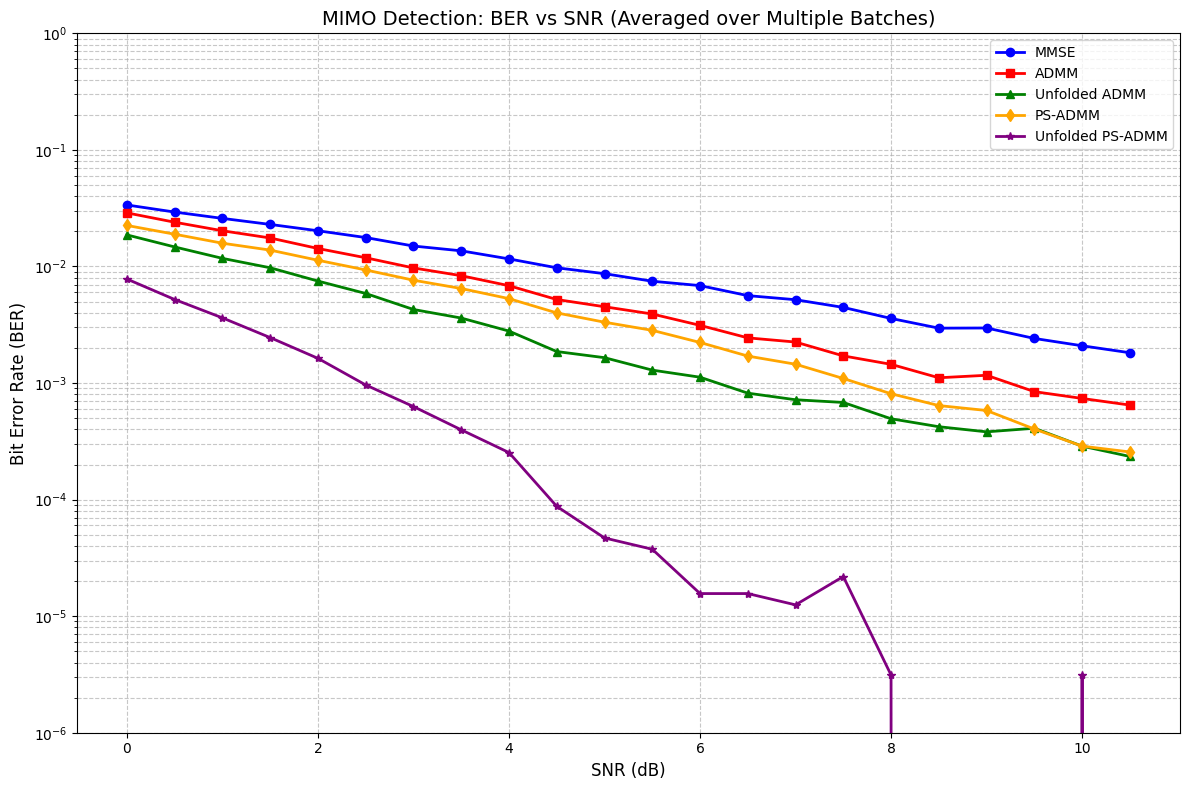


Final BER Results:
SNR (dB) | MMSE       | ADMM       | U-ADMM     | PS-ADMM    | U-PS-ADMM
----------------------------------------------------------------------
     0.0 |   3.37e-02 |   2.88e-02 |   1.87e-02 |   2.25e-02 |   7.80e-03
     0.5 |   2.93e-02 |   2.40e-02 |   1.47e-02 |   1.89e-02 |   5.21e-03
     1.0 |   2.58e-02 |   2.02e-02 |   1.17e-02 |   1.58e-02 |   3.62e-03
     1.5 |   2.29e-02 |   1.76e-02 |   9.74e-03 |   1.38e-02 |   2.45e-03
     2.0 |   2.02e-02 |   1.43e-02 |   7.49e-03 |   1.13e-02 |   1.63e-03
     2.5 |   1.77e-02 |   1.19e-02 |   5.87e-03 |   9.33e-03 |   9.62e-04
     3.0 |   1.50e-02 |   9.71e-03 |   4.27e-03 |   7.62e-03 |   6.28e-04
     3.5 |   1.36e-02 |   8.33e-03 |   3.61e-03 |   6.47e-03 |   3.97e-04
     4.0 |   1.16e-02 |   6.84e-03 |   2.79e-03 |   5.30e-03 |   2.53e-04
     4.5 |   9.74e-03 |   5.21e-03 |   1.86e-03 |   4.00e-03 |   8.75e-05
     5.0 |   8.67e-03 |   4.51e-03 |   1.65e-03 |   3.32e-03 |   4.69e-05
     5.5 |   7.47e-03 

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

def build_constellation(M):
    """Normalized square QAM constellation and Gray mapping."""
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)
    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation) ** 2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

def quantize_to_constellation(x, constellation):
    """Quantize to nearest constellation point."""
    x_flat = x.reshape(-1, 1)
    d2 = np.abs(x_flat - constellation.reshape(1, -1)) ** 2
    idx = np.argmin(d2, axis=1)
    return constellation[idx].reshape(x.shape), idx.reshape(x.shape)

def generate_channel_batch(B, U, batch_size):
    """Generate batch of Rayleigh fading channels."""
    return (np.random.randn(batch_size, B, U) + 1j * np.random.randn(batch_size, B, U)) / np.sqrt(2)

def generate_data_batch(B, U, M, batch_size, snr_db):
    """Generate batch of data similar to OTFS code structure."""
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1 / snr_lin
    
    # Generate channels
    H_batch = generate_channel_batch(B, U, batch_size)
    
    # Generate symbols
    bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
    x_batch = np.array([[constellation[int("".join(map(str, b)), 2)] for b in bits] for bits in bits_batch])
    
    # Generate noise
    n_batch = np.sqrt(noise_var / 2) * (np.random.randn(batch_size, B) + 1j * np.random.randn(batch_size, B))
    
    # Generate received signals
    y_batch = np.array([H_batch[i] @ x_batch[i] + n_batch[i] for i in range(batch_size)])
    
    return y_batch, H_batch, x_batch, bits_batch, constellation, bit_labels

def mmse_detector_batch(y_batch, H_batch, noise_var):
    """Batch MMSE detection."""
    batch_size = y_batch.shape[0]
    x_hat_batch = np.zeros_like(y_batch, dtype=complex)
    
    for i in range(batch_size):
        H = H_batch[i]
        y = y_batch[i]
        HhH = H.conj().T @ H
        x_hat_batch[i] = np.linalg.inv(HhH + noise_var * np.eye(H.shape[1])) @ (H.conj().T @ y)
    
    return x_hat_batch

def admm_detector_batch(y_batch, H_batch, rho=0.1, max_iter=30, tol=1e-4):
    """Batch ADMM detection."""
    batch_size, B = y_batch.shape
    U = H_batch.shape[2]
    x_hat_batch = np.zeros((batch_size, U), dtype=complex)
    
    for i in range(batch_size):
        y = y_batch[i]
        H = H_batch[i]
        Hh = H.conj().T
        inv_matrix = np.linalg.inv(Hh @ H + rho * np.eye(U))
        Hy = Hh @ y
        x = np.zeros(U, dtype=complex)
        z = np.zeros(U, dtype=complex)
        lam = np.zeros(U, dtype=complex)
        
        for _ in range(max_iter):
            x = inv_matrix @ (Hy + rho * (z - lam))
            z_new = np.clip(np.real(x + lam), -1, 1) + 1j * np.clip(np.imag(x + lam), -1, 1)
            lam = lam + x - z_new
            if np.linalg.norm(x - z_new) < tol:
                break
            z = z_new
        
        x_hat_batch[i] = x
    
    return x_hat_batch

def ps_admm_detect_batch(y_batch, H_batch, M, rho=1.5, alpha=0.01, T=30):
    """Batch PS-ADMM detection."""
    batch_size = y_batch.shape[0]
    U = H_batch.shape[2]
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    x_hat_batch = np.zeros((batch_size, U), dtype=complex)
    
    for i in range(batch_size):
        y = y_batch[i]
        H = H_batch[i]
        
        # PS-ADMM implementation
        xq = np.zeros((Q, U), dtype=np.complex128)
        x0 = np.zeros(U, dtype=np.complex128)
        dual_y = np.zeros(U, dtype=np.complex128)
        scales = np.array([2 ** q for q in range(Q)])
        alpha_q = np.array([alpha] * Q)
        HhH = H.conj().T @ H
        Hhr = H.conj().T @ y
        A_inv = np.linalg.inv(HhH + rho * np.eye(U))
        
        for it in range(T):
            for q in range(Q):
                sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha_q[q]
                x_new = (scales[q] / denom) * numer
                xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
            
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = A_inv @ rhs
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        x_hat_batch[i] = np.sum(scales.reshape(-1, 1) * xq, axis=0)
    
    return x_hat_batch

class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, U):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))
        self.log_gamma = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        B, N, U = H.shape
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        
        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)
        
        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            gamma = torch.exp(self.log_gamma[l])
            
            inv = torch.linalg.inv(HhH + rho * I)
            x = torch.bmm(inv, (Hhy + rho * (z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + gamma * (x - z)
            
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.log_rho = nn.Parameter(torch.ones(L))
        self.log_alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch_size, B, U = H.shape
        xq = torch.zeros(batch_size, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch_size, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch_size, U, dtype=torch.cfloat, device=H.device)
        
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        
        for l in range(self.L):
            rho = torch.exp(self.log_rho[l])
            alpha = torch.exp(self.log_alpha[l])
            
            A_inv = torch.linalg.inv(HhH + rho * I)
            
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        return x0

def calculate_ber_batch(x_hat_batch, x_true_batch, constellation, bit_labels):
    """Calculate BER for a batch of estimates."""
    batch_size = x_hat_batch.shape[0]
    total_errors = 0
    total_bits = 0
    
    for i in range(batch_size):
        # Quantize to constellation
        _, idx_true = quantize_to_constellation(x_true_batch[i], constellation)
        _, idx_hat = quantize_to_constellation(x_hat_batch[i], constellation)
        
        # Calculate bit errors
        bit_errors = np.sum(bit_labels[idx_hat] != bit_labels[idx_true])
        total_errors += bit_errors
        total_bits += len(x_true_batch[i]) * bit_labels.shape[1]
    
    return total_errors / total_bits if total_bits > 0 else 0

def unified_simulation_smooth(B=16, U=16, M=4, batch_size=100, num_batches=100, snr_db_list=np.arange(0, 11, 0.5)):
    """Modified simulation with batch processing for smooth curves."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Initialize models
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    
    unfolded_admm = UnfoldedADMM(num_layers=5, U=U).to(device)
    unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=10).to(device)
    
    # Load or initialize weights (optional)
    # You can add weight loading here similar to your OTFS code
    
    unfolded_admm.eval()
    unfolded_psadmm.eval()
    
    ber_results = {
        "MMSE": [],
        "ADMM": [], 
        "Unfolded ADMM": [],
        "PS-ADMM": [],
        "Unfolded PS-ADMM": []
    }
    
    for snr_db in tqdm(snr_db_list, desc="Processing SNRs"):
        ber_mmse = 0
        ber_admm = 0
        ber_unfolded_admm = 0
        ber_psadmm = 0
        ber_unfolded_psadmm = 0
        
        # Process multiple batches per SNR (like the OTFS code)
        for batch_idx in range(num_batches):
            # Generate batch data
            y_batch, H_batch, x_batch, bits_batch, constellation, bit_labels = generate_data_batch(
                B, U, M, batch_size, snr_db
            )
            
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1 / snr_lin
            
            # MMSE detection
            x_mmse_batch = mmse_detector_batch(y_batch, H_batch, noise_var)
            ber_mmse += calculate_ber_batch(x_mmse_batch, x_batch, constellation, bit_labels)
            
            # ADMM detection
            x_admm_batch = admm_detector_batch(y_batch, H_batch)
            ber_admm += calculate_ber_batch(x_admm_batch, x_batch, constellation, bit_labels)
            
            # PS-ADMM detection
            x_psadmm_batch = ps_admm_detect_batch(y_batch, H_batch, M)
            ber_psadmm += calculate_ber_batch(x_psadmm_batch, x_batch, constellation, bit_labels)
            
            # Unfolded ADMM detection
            H_tensor = torch.tensor(H_batch, dtype=torch.cfloat, device=device)
            y_tensor = torch.tensor(y_batch, dtype=torch.cfloat, device=device)
            
            with torch.no_grad():
                x_unfolded_admm_batch = unfolded_admm(y_tensor, H_tensor).cpu().numpy()
                x_unfolded_psadmm_batch = unfolded_psadmm(H_tensor, y_tensor).cpu().numpy()
            
            ber_unfolded_admm += calculate_ber_batch(x_unfolded_admm_batch, x_batch, constellation, bit_labels)
            ber_unfolded_psadmm += calculate_ber_batch(x_unfolded_psadmm_batch, x_batch, constellation, bit_labels)
        
        # Average over all batches
        ber_results["MMSE"].append(ber_mmse / num_batches)
        ber_results["ADMM"].append(ber_admm / num_batches)
        ber_results["Unfolded ADMM"].append(ber_unfolded_admm / num_batches)
        ber_results["PS-ADMM"].append(ber_psadmm / num_batches)
        ber_results["Unfolded PS-ADMM"].append(ber_unfolded_psadmm / num_batches)
        
        print(f"SNR={snr_db:5.1f} dB | "
              f"MMSE: {ber_results['MMSE'][-1]:8.2e} | "
              f"ADMM: {ber_results['ADMM'][-1]:8.2e} | "
              f"U-ADMM: {ber_results['Unfolded ADMM'][-1]:8.2e} | "
              f"PS-ADMM: {ber_results['PS-ADMM'][-1]:8.2e} | "
              f"U-PS: {ber_results['Unfolded PS-ADMM'][-1]:8.2e}")
    
    return snr_db_list, ber_results

def plot_smooth_curves(snr_db_list, ber_results):
    """Plot smooth BER curves."""
    plt.figure(figsize=(12, 8))
    
    colors = {
        'MMSE': 'blue', 
        'ADMM': 'red', 
        'Unfolded ADMM': 'green',
        'PS-ADMM': 'orange',
        'Unfolded PS-ADMM': 'purple'
    }
    
    markers = {
        'MMSE': 'o', 
        'ADMM': 's', 
        'Unfolded ADMM': '^',
        'PS-ADMM': 'd',
        'Unfolded PS-ADMM': '*'
    }
    
    for detector in ber_results:
        plt.semilogy(snr_db_list, ber_results[detector], 
                    label=detector, 
                    color=colors.get(detector, 'black'),
                    marker=markers.get(detector, 'o'),
                    markersize=6,
                    linewidth=2)
    
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("Bit Error Rate (BER)", fontsize=12)
    plt.title("MIMO Detection: BER vs SNR (Averaged over Multiple Batches)", fontsize=14)
    plt.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(top=1, bottom=1e-6)
    plt.tight_layout()
    plt.show()

# Run the smooth simulation
print("Starting smooth MIMO simulation with all detectors...")
snr_db_list, ber_results = unified_simulation_smooth(
    B=16, 
    U=16, 
    M=4, 
    batch_size=100,      # Batch size per iteration
    num_batches=100,     # Number of batches per SNR
    snr_db_list=np.arange(0, 11, 0.5)
)

# Plot results
plot_smooth_curves(snr_db_list, ber_results)

# Print final results in a table
print("\nFinal BER Results:")
print("SNR (dB) | MMSE       | ADMM       | U-ADMM     | PS-ADMM    | U-PS-ADMM")
print("-" * 70)
for i, snr in enumerate(snr_db_list):
    print(f"{snr:8.1f} | {ber_results['MMSE'][i]:10.2e} | {ber_results['ADMM'][i]:10.2e} | "
          f"{ber_results['Unfolded ADMM'][i]:10.2e} | {ber_results['PS-ADMM'][i]:10.2e} | "
          f"{ber_results['Unfolded PS-ADMM'][i]:10.2e}")

## Averaging over a large batch per SNR

In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [41]:
def build_constellation(M):
    """Normalized square QAM constellation and Gray mapping."""
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)
    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation) ** 2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

def quantize_to_constellation(x, constellation):
    """Quantize to nearest constellation point."""
    x_flat = x.reshape(-1, 1)
    d2 = np.abs(x_flat - constellation.reshape(1, -1)) ** 2
    idx = np.argmin(d2, axis=1)
    return constellation[idx].reshape(x.shape), idx.reshape(x.shape)

In [43]:
def generate_channel_batch(B, U, batch_size):
    """Generate batch of Rayleigh fading channels."""
    return (np.random.randn(batch_size, B, U) + 1j * np.random.randn(batch_size, B, U)) / np.sqrt(2)

def generate_data_batch(B, U, M, batch_size, snr_db):
    """Generate batch of data similar to OTFS code structure."""
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1 / snr_lin
    
    # Generate channels
    H_batch = generate_channel_batch(B, U, batch_size)
    
    # Generate symbols
    bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
    x_batch = np.array([[constellation[int("".join(map(str, b)), 2)] for b in bits] for bits in bits_batch])
    
    # Generate noise
    n_batch = np.sqrt(noise_var / 2) * (np.random.randn(batch_size, B) + 1j * np.random.randn(batch_size, B))
    
    # Generate received signals
    y_batch = np.array([H_batch[i] @ x_batch[i] + n_batch[i] for i in range(batch_size)])
    
    return y_batch, H_batch, x_batch, bits_batch, constellation, bit_labels

In [44]:
def mmse_detector_batch(y_batch, H_batch, noise_var):
    """Batch MMSE detection."""
    batch_size = y_batch.shape[0]
    x_hat_batch = np.zeros_like(y_batch, dtype=complex)
    
    for i in range(batch_size):
        H = H_batch[i]
        y = y_batch[i]
        HhH = H.conj().T @ H
        x_hat_batch[i] = np.linalg.inv(HhH + noise_var * np.eye(H.shape[1])) @ (H.conj().T @ y)
    
    return x_hat_batch

In [45]:
def admm_detector_batch(y_batch, H_batch, rho=0.1, max_iter=30, tol=1e-4):
    """Batch ADMM detection."""
    batch_size, B = y_batch.shape
    U = H_batch.shape[2]
    x_hat_batch = np.zeros((batch_size, U), dtype=complex)
    
    for i in range(batch_size):
        y = y_batch[i]
        H = H_batch[i]
        Hh = H.conj().T
        inv_matrix = np.linalg.inv(Hh @ H + rho * np.eye(U))
        Hy = Hh @ y
        x = np.zeros(U, dtype=complex)
        z = np.zeros(U, dtype=complex)
        lam = np.zeros(U, dtype=complex)
        
        for _ in range(max_iter):
            x = inv_matrix @ (Hy + rho * (z - lam))
            z_new = np.clip(np.real(x + lam), -1, 1) + 1j * np.clip(np.imag(x + lam), -1, 1)
            lam = lam + x - z_new
            if np.linalg.norm(x - z_new) < tol:
                break
            z = z_new
        
        x_hat_batch[i] = x
    
    return x_hat_batch


In [46]:
def ps_admm_detect_batch(y_batch, H_batch, M, rho=1.5, alpha=0.01, T=30):
    """Batch PS-ADMM detection."""
    batch_size = y_batch.shape[0]
    U = H_batch.shape[2]
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    x_hat_batch = np.zeros((batch_size, U), dtype=complex)
    
    for i in range(batch_size):
        y = y_batch[i]
        H = H_batch[i]
        
        # PS-ADMM implementation
        xq = np.zeros((Q, U), dtype=np.complex128)
        x0 = np.zeros(U, dtype=np.complex128)
        dual_y = np.zeros(U, dtype=np.complex128)
        scales = np.array([2 ** q for q in range(Q)])
        alpha_q = np.array([alpha] * Q)
        HhH = H.conj().T @ H
        Hhr = H.conj().T @ y
        A_inv = np.linalg.inv(HhH + rho * np.eye(U))
        
        for it in range(T):
            for q in range(Q):
                sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha_q[q]
                x_new = (scales[q] / denom) * numer
                xq[q] = np.clip(x_new.real, -1, 1) + 1j * np.clip(x_new.imag, -1, 1)
            
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = A_inv @ rhs
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        x_hat_batch[i] = np.sum(scales.reshape(-1, 1) * xq, axis=0)
    
    return x_hat_batch

In [47]:
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, U):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))
        self.log_gamma = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        B, N, U = H.shape
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        
        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)
        
        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            gamma = torch.exp(self.log_gamma[l])
            
            inv = torch.linalg.inv(HhH + rho * I)
            x = torch.bmm(inv, (Hhy + rho * (z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + gamma * (x - z)
            
        return z

class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U, self.Q, self.L = U, Q, L
        self.log_rho = nn.Parameter(torch.ones(L))
        self.log_alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch_size, B, U = H.shape
        xq = torch.zeros(batch_size, self.Q, U, dtype=torch.cfloat, device=H.device)
        x0 = torch.zeros(batch_size, U, dtype=torch.cfloat, device=H.device)
        dual_y = torch.zeros(batch_size, U, dtype=torch.cfloat, device=H.device)
        
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.float32, device=H.device)
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)
        
        for l in range(self.L):
            rho = torch.exp(self.log_rho[l])
            alpha = torch.exp(self.log_alpha[l])
            
            A_inv = torch.linalg.inv(HhH + rho * I)
            
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                xq[:, q, :] = torch.tanh(x_new.real) + 1j * torch.tanh(x_new.imag)
            
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        return x0

In [48]:
def calculate_ber_batch(x_hat_batch, x_true_batch, constellation, bit_labels):
    """Calculate BER for a batch of estimates."""
    batch_size = x_hat_batch.shape[0]
    total_errors = 0
    total_bits = 0
    
    for i in range(batch_size):
        # Quantize to constellation
        _, idx_true = quantize_to_constellation(x_true_batch[i], constellation)
        _, idx_hat = quantize_to_constellation(x_hat_batch[i], constellation)
        
        # Calculate bit errors
        bit_errors = np.sum(bit_labels[idx_hat] != bit_labels[idx_true])
        total_errors += bit_errors
        total_bits += len(x_true_batch[i]) * bit_labels.shape[1]
    
    return total_errors / total_bits if total_bits > 0 else 0

In [49]:
def unified_simulation_smooth(B=16, U=16, M=4, batch_size=100, num_batches=100, snr_db_list=np.arange(0, 11, 0.5)):
    """Modified simulation with batch processing for smooth curves."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Initialize models
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    
    unfolded_admm = UnfoldedADMM(num_layers=5, U=U).to(device)
    unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=10).to(device)
    
    unfolded_admm.eval()
    unfolded_psadmm.eval()
    
    ber_results = {
        "MMSE": [],
        "ADMM": [], 
        "Unfolded ADMM": [],
        "PS-ADMM": [],
        "Unfolded PS-ADMM": []
    }
    
    for snr_db in tqdm(snr_db_list, desc="Processing SNRs"):
        ber_mmse = 0
        ber_admm = 0
        ber_unfolded_admm = 0
        ber_psadmm = 0
        ber_unfolded_psadmm = 0
        
        # Process multiple batches per SNR (like the OTFS code)
        for batch_idx in range(num_batches):
            # Generate batch data
            y_batch, H_batch, x_batch, bits_batch, constellation, bit_labels = generate_data_batch(
                B, U, M, batch_size, snr_db
            )
            
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1 / snr_lin
            
            # MMSE detection
            x_mmse_batch = mmse_detector_batch(y_batch, H_batch, noise_var)
            ber_mmse += calculate_ber_batch(x_mmse_batch, x_batch, constellation, bit_labels)
            
            # ADMM detection
            x_admm_batch = admm_detector_batch(y_batch, H_batch)
            ber_admm += calculate_ber_batch(x_admm_batch, x_batch, constellation, bit_labels)
            
            # PS-ADMM detection
            x_psadmm_batch = ps_admm_detect_batch(y_batch, H_batch, M)
            ber_psadmm += calculate_ber_batch(x_psadmm_batch, x_batch, constellation, bit_labels)
            
            # Unfolded ADMM detection
            H_tensor = torch.tensor(H_batch, dtype=torch.cfloat, device=device)
            y_tensor = torch.tensor(y_batch, dtype=torch.cfloat, device=device)
            
            with torch.no_grad():
                x_unfolded_admm_batch = unfolded_admm(y_tensor, H_tensor).cpu().numpy()
                x_unfolded_psadmm_batch = unfolded_psadmm(H_tensor, y_tensor).cpu().numpy()
            
            ber_unfolded_admm += calculate_ber_batch(x_unfolded_admm_batch, x_batch, constellation, bit_labels)
            ber_unfolded_psadmm += calculate_ber_batch(x_unfolded_psadmm_batch, x_batch, constellation, bit_labels)
        
        # Average over all batches
        ber_results["MMSE"].append(ber_mmse / num_batches)
        ber_results["ADMM"].append(ber_admm / num_batches)
        ber_results["Unfolded ADMM"].append(ber_unfolded_admm / num_batches)
        ber_results["PS-ADMM"].append(ber_psadmm / num_batches)
        ber_results["Unfolded PS-ADMM"].append(ber_unfolded_psadmm / num_batches)
        
        print(f"SNR={snr_db:5.1f} dB | "
              f"MMSE: {ber_results['MMSE'][-1]:8.2e} | "
              f"ADMM: {ber_results['ADMM'][-1]:8.2e} | "
              f"U-ADMM: {ber_results['Unfolded ADMM'][-1]:8.2e} | "
              f"PS-ADMM: {ber_results['PS-ADMM'][-1]:8.2e} | "
              f"U-PS: {ber_results['Unfolded PS-ADMM'][-1]:8.2e}")
    
    return snr_db_list, ber_results

In [50]:
def plot_smooth_curves(snr_db_list, ber_results):
    """Plot smooth BER curves with lighter color shades."""
    plt.figure(figsize=(12, 8))
    
    colors = {
        'MMSE': 'lightblue', 
        'ADMM': 'lightcoral', 
        'Unfolded ADMM': 'lightgreen',
        'PS-ADMM': 'navajowhite',
        'Unfolded PS-ADMM': 'plum'
    }
    
    markers = {
        'MMSE': 'o', 
        'ADMM': 's', 
        'Unfolded ADMM': '^',
        'PS-ADMM': 'd',
        'Unfolded PS-ADMM': '*'
    }
    
    line_styles = {
        'MMSE': '-', 
        'ADMM': '--', 
        'Unfolded ADMM': '-.',
        'PS-ADMM': ':',
        'Unfolded PS-ADMM': '-'
    }
    
    for detector in ber_results:
        plt.semilogy(snr_db_list, ber_results[detector], 
                    label=detector, 
                    color=colors.get(detector, 'lightgray'),
                    marker=markers.get(detector, 'o'),
                    markersize=7,
                    linewidth=2.5,
                    linestyle=line_styles.get(detector, '-'),
                    alpha=0.8)
    
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlabel("SNR (dB)", fontsize=14)
    plt.ylabel("Bit Error Rate (BER)", fontsize=14)
    plt.title("MIMO Detection: BER vs SNR (16x16, 4-QAM)", fontsize=16)
    plt.legend(fontsize=12, framealpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=1, bottom=1e-6)
    plt.tight_layout()
    plt.show()

In [51]:
print("Starting smooth MIMO simulation with all detectors...")
print("Configuration: 16x16 MIMO, 4-QAM, 100 batches per SNR, 100 samples per batch")

snr_db_list, ber_results = unified_simulation_smooth(
    B=16, 
    U=16, 
    M=4, 
    batch_size=100,      # Batch size per iteration
    num_batches=100,     # Number of batches per SNR
    snr_db_list=np.arange(0, 11, 0.5)
)

Starting smooth MIMO simulation with all detectors...
Configuration: 16x16 MIMO, 4-QAM, 100 batches per SNR, 100 samples per batch
Using device: cpu


Processing SNRs:   5%|███                                                               | 1/22 [00:13<04:43, 13.49s/it]

SNR=  0.0 dB | MMSE: 3.37e-02 | ADMM: 2.88e-02 | U-ADMM: 1.87e-02 | PS-ADMM: 2.25e-02 | U-PS: 7.80e-03


Processing SNRs:   9%|██████                                                            | 2/22 [00:25<04:10, 12.52s/it]

SNR=  0.5 dB | MMSE: 2.93e-02 | ADMM: 2.40e-02 | U-ADMM: 1.47e-02 | PS-ADMM: 1.89e-02 | U-PS: 5.21e-03


Processing SNRs:  14%|█████████                                                         | 3/22 [00:37<03:50, 12.14s/it]

SNR=  1.0 dB | MMSE: 2.58e-02 | ADMM: 2.02e-02 | U-ADMM: 1.17e-02 | PS-ADMM: 1.58e-02 | U-PS: 3.62e-03


Processing SNRs:  18%|████████████                                                      | 4/22 [00:48<03:34, 11.90s/it]

SNR=  1.5 dB | MMSE: 2.29e-02 | ADMM: 1.76e-02 | U-ADMM: 9.74e-03 | PS-ADMM: 1.38e-02 | U-PS: 2.45e-03


Processing SNRs:  23%|███████████████                                                   | 5/22 [00:59<03:15, 11.50s/it]

SNR=  2.0 dB | MMSE: 2.02e-02 | ADMM: 1.43e-02 | U-ADMM: 7.49e-03 | PS-ADMM: 1.13e-02 | U-PS: 1.63e-03


Processing SNRs:  27%|██████████████████                                                | 6/22 [01:11<03:04, 11.56s/it]

SNR=  2.5 dB | MMSE: 1.77e-02 | ADMM: 1.19e-02 | U-ADMM: 5.87e-03 | PS-ADMM: 9.33e-03 | U-PS: 9.62e-04


Processing SNRs:  32%|█████████████████████                                             | 7/22 [01:21<02:48, 11.22s/it]

SNR=  3.0 dB | MMSE: 1.50e-02 | ADMM: 9.71e-03 | U-ADMM: 4.27e-03 | PS-ADMM: 7.62e-03 | U-PS: 6.28e-04


Processing SNRs:  36%|████████████████████████                                          | 8/22 [01:32<02:33, 10.99s/it]

SNR=  3.5 dB | MMSE: 1.36e-02 | ADMM: 8.33e-03 | U-ADMM: 3.61e-03 | PS-ADMM: 6.47e-03 | U-PS: 3.97e-04


Processing SNRs:  41%|███████████████████████████                                       | 9/22 [01:43<02:23, 11.02s/it]

SNR=  4.0 dB | MMSE: 1.16e-02 | ADMM: 6.84e-03 | U-ADMM: 2.79e-03 | PS-ADMM: 5.30e-03 | U-PS: 2.53e-04


Processing SNRs:  45%|█████████████████████████████▌                                   | 10/22 [01:54<02:15, 11.26s/it]

SNR=  4.5 dB | MMSE: 9.74e-03 | ADMM: 5.21e-03 | U-ADMM: 1.86e-03 | PS-ADMM: 4.00e-03 | U-PS: 8.75e-05


Processing SNRs:  50%|████████████████████████████████▌                                | 11/22 [02:06<02:03, 11.22s/it]

SNR=  5.0 dB | MMSE: 8.67e-03 | ADMM: 4.51e-03 | U-ADMM: 1.65e-03 | PS-ADMM: 3.32e-03 | U-PS: 4.69e-05


Processing SNRs:  55%|███████████████████████████████████▍                             | 12/22 [02:18<01:57, 11.72s/it]

SNR=  5.5 dB | MMSE: 7.47e-03 | ADMM: 3.91e-03 | U-ADMM: 1.29e-03 | PS-ADMM: 2.83e-03 | U-PS: 3.75e-05


Processing SNRs:  59%|██████████████████████████████████████▍                          | 13/22 [02:29<01:43, 11.45s/it]

SNR=  6.0 dB | MMSE: 6.85e-03 | ADMM: 3.13e-03 | U-ADMM: 1.12e-03 | PS-ADMM: 2.23e-03 | U-PS: 1.56e-05


Processing SNRs:  64%|█████████████████████████████████████████▎                       | 14/22 [02:40<01:29, 11.24s/it]

SNR=  6.5 dB | MMSE: 5.62e-03 | ADMM: 2.44e-03 | U-ADMM: 8.19e-04 | PS-ADMM: 1.70e-03 | U-PS: 1.56e-05


Processing SNRs:  68%|████████████████████████████████████████████▎                    | 15/22 [02:50<01:16, 10.87s/it]

SNR=  7.0 dB | MMSE: 5.18e-03 | ADMM: 2.25e-03 | U-ADMM: 7.19e-04 | PS-ADMM: 1.45e-03 | U-PS: 1.25e-05


Processing SNRs:  73%|███████████████████████████████████████████████▎                 | 16/22 [03:00<01:03, 10.55s/it]

SNR=  7.5 dB | MMSE: 4.45e-03 | ADMM: 1.71e-03 | U-ADMM: 6.81e-04 | PS-ADMM: 1.09e-03 | U-PS: 2.19e-05


Processing SNRs:  77%|██████████████████████████████████████████████████▏              | 17/22 [03:10<00:51, 10.31s/it]

SNR=  8.0 dB | MMSE: 3.58e-03 | ADMM: 1.45e-03 | U-ADMM: 4.94e-04 | PS-ADMM: 8.09e-04 | U-PS: 3.13e-06


Processing SNRs:  82%|█████████████████████████████████████████████████████▏           | 18/22 [03:19<00:40, 10.11s/it]

SNR=  8.5 dB | MMSE: 2.96e-03 | ADMM: 1.11e-03 | U-ADMM: 4.22e-04 | PS-ADMM: 6.41e-04 | U-PS: 0.00e+00


Processing SNRs:  86%|████████████████████████████████████████████████████████▏        | 19/22 [03:29<00:30, 10.05s/it]

SNR=  9.0 dB | MMSE: 2.97e-03 | ADMM: 1.17e-03 | U-ADMM: 3.81e-04 | PS-ADMM: 5.81e-04 | U-PS: 0.00e+00


Processing SNRs:  91%|███████████████████████████████████████████████████████████      | 20/22 [03:39<00:19, 10.00s/it]

SNR=  9.5 dB | MMSE: 2.41e-03 | ADMM: 8.44e-04 | U-ADMM: 4.09e-04 | PS-ADMM: 4.03e-04 | U-PS: 0.00e+00


Processing SNRs:  95%|██████████████████████████████████████████████████████████████   | 21/22 [03:49<00:09,  9.87s/it]

SNR= 10.0 dB | MMSE: 2.09e-03 | ADMM: 7.38e-04 | U-ADMM: 2.88e-04 | PS-ADMM: 2.88e-04 | U-PS: 3.13e-06


Processing SNRs: 100%|█████████████████████████████████████████████████████████████████| 22/22 [03:58<00:00, 10.85s/it]

SNR= 10.5 dB | MMSE: 1.82e-03 | ADMM: 6.47e-04 | U-ADMM: 2.34e-04 | PS-ADMM: 2.56e-04 | U-PS: 0.00e+00


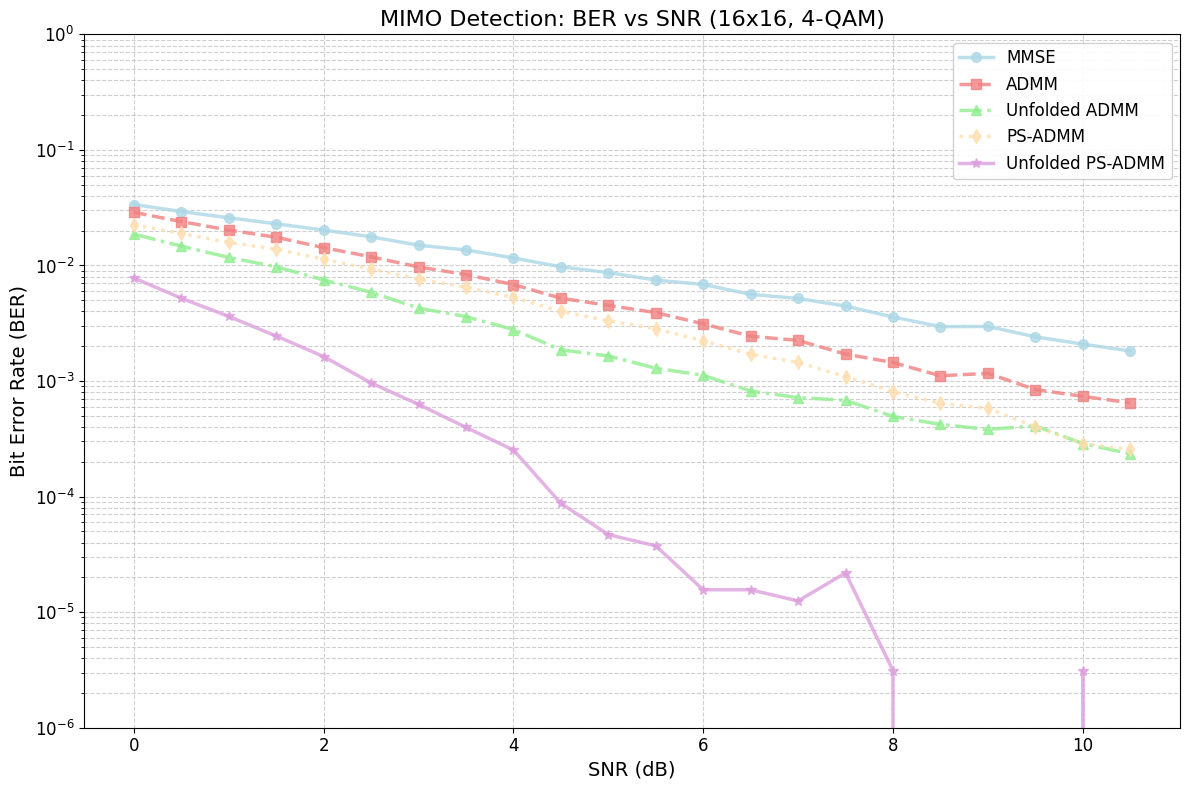

In [54]:
plot_smooth_curves(snr_db_list, ber_results)

In [53]:
print("\nFinal BER Results Summary:")
print(f"{'SNR (dB)':<8} | {'MMSE':<12} | {'ADMM':<12} | {'U-ADMM':<12} | {'PS-ADMM':<12} | {'U-PS-ADMM':<12}")
print("-" * 85)

for i, snr in enumerate(snr_db_list):
    if i % 2 == 0:  # Print every other SNR to make table more readable
        print(f"{snr:<8.1f} | {ber_results['MMSE'][i]:<12.2e} | {ber_results['ADMM'][i]:<12.2e} | "
              f"{ber_results['Unfolded ADMM'][i]:<12.2e} | {ber_results['PS-ADMM'][i]:<12.2e} | "
              f"{ber_results['Unfolded PS-ADMM'][i]:<12.2e}")


Final BER Results Summary:
SNR (dB) | MMSE         | ADMM         | U-ADMM       | PS-ADMM      | U-PS-ADMM   
-------------------------------------------------------------------------------------
0.0      | 3.37e-02     | 2.88e-02     | 1.87e-02     | 2.25e-02     | 7.80e-03    
1.0      | 2.58e-02     | 2.02e-02     | 1.17e-02     | 1.58e-02     | 3.62e-03    
2.0      | 2.02e-02     | 1.43e-02     | 7.49e-03     | 1.13e-02     | 1.63e-03    
3.0      | 1.50e-02     | 9.71e-03     | 4.27e-03     | 7.62e-03     | 6.28e-04    
4.0      | 1.16e-02     | 6.84e-03     | 2.79e-03     | 5.30e-03     | 2.53e-04    
5.0      | 8.67e-03     | 4.51e-03     | 1.65e-03     | 3.32e-03     | 4.69e-05    
6.0      | 6.85e-03     | 3.13e-03     | 1.12e-03     | 2.23e-03     | 1.56e-05    
7.0      | 5.18e-03     | 2.25e-03     | 7.19e-04     | 1.45e-03     | 1.25e-05    
8.0      | 3.58e-03     | 1.45e-03     | 4.94e-04     | 8.09e-04     | 3.13e-06    
9.0      | 2.97e-03     | 1.17e-03     | 3.81e

## Real-Valued Equivalent Model

In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [56]:
def complex_to_real_matrix(H_complex):
    """Convert complex matrix to real-valued equivalent [Re -Im; Im Re]"""
    H_real = np.real(H_complex)
    H_imag = np.imag(H_complex)
    H_equiv = np.block([[H_real, -H_imag], 
                        [H_imag, H_real]])
    return H_equiv

def complex_to_real_vector(x_complex):
    """Convert complex vector to real-valued equivalent [Re; Im]"""
    return np.concatenate([np.real(x_complex), np.imag(x_complex)])

def real_to_complex_vector(x_real):
    """Convert real-valued vector back to complex"""
    N = len(x_real) // 2
    return x_real[:N] + 1j * x_real[N:]

def complex_to_real_tensor(H_complex):
    """Convert complex tensor to real-valued equivalent for PyTorch"""
    H_real = torch.real(H_complex)
    H_imag = torch.imag(H_complex)
    batch_size, B, U = H_real.shape
    H_equiv = torch.zeros(batch_size, 2*B, 2*U, dtype=H_real.dtype, device=H_real.device)
    H_equiv[:, :B, :U] = H_real
    H_equiv[:, :B, U:] = -H_imag
    H_equiv[:, B:, :U] = H_imag
    H_equiv[:, B:, U:] = H_real
    return H_equiv

def complex_to_real_vector_tensor(x_complex):
    """Convert complex vector tensor to real-valued equivalent for PyTorch"""
    x_real = torch.real(x_complex)
    x_imag = torch.imag(x_complex)
    return torch.cat([x_real, x_imag], dim=-1)

def real_to_complex_vector_tensor(x_real):
    """Convert real-valued vector tensor back to complex for PyTorch"""
    N = x_real.shape[-1] // 2
    return x_real[..., :N] + 1j * x_real[..., N:]

In [57]:
def build_constellation(M):
    """Normalized square QAM constellation and Gray mapping."""
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)
    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation) ** 2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

def quantize_to_constellation_real(x_real, constellation):
    """Quantize real-valued vector to nearest constellation point."""
    x_complex = real_to_complex_vector(x_real)
    x_flat = x_complex.reshape(-1, 1)
    d2 = np.abs(x_flat - constellation.reshape(1, -1)) ** 2
    idx = np.argmin(d2, axis=1)
    return constellation[idx].reshape(x_complex.shape), idx.reshape(x_complex.shape)

In [58]:
def generate_channel_batch(B, U, batch_size):
    """Generate batch of Rayleigh fading channels."""
    return (np.random.randn(batch_size, B, U) + 1j * np.random.randn(batch_size, B, U)) / np.sqrt(2)

def generate_data_batch_real(B, U, M, batch_size, snr_db):
    """Generate batch of data with real-valued equivalent matrices."""
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1 / snr_lin
    
    # Generate complex channels and data
    H_complex_batch = generate_channel_batch(B, U, batch_size)
    
    # Generate symbols
    bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
    x_complex_batch = np.array([[constellation[int("".join(map(str, b)), 2)] for b in bits] for bits in bits_batch])
    
    # Generate noise
    n_complex_batch = np.sqrt(noise_var / 2) * (np.random.randn(batch_size, B) + 1j * np.random.randn(batch_size, B))
    
    # Generate received signals
    y_complex_batch = np.array([H_complex_batch[i] @ x_complex_batch[i] + n_complex_batch[i] for i in range(batch_size)])
    
    # Convert to real-valued equivalent
    H_real_batch = np.array([complex_to_real_matrix(H) for H in H_complex_batch])
    y_real_batch = np.array([complex_to_real_vector(y) for y in y_complex_batch])
    x_real_batch = np.array([complex_to_real_vector(x) for x in x_complex_batch])
    
    return y_real_batch, H_real_batch, x_real_batch, x_complex_batch, bits_batch, constellation, bit_labels


In [59]:
def mmse_detector_batch_real(y_real_batch, H_real_batch, noise_var):
    """Batch MMSE detection with real-valued equivalent."""
    batch_size, _ = y_real_batch.shape
    U = H_real_batch.shape[2] // 2  # Original complex dimension
    x_hat_real_batch = np.zeros_like(y_real_batch)
    
    for i in range(batch_size):
        H = H_real_batch[i]
        y = y_real_batch[i]
        HtH = H.T @ H
        # Noise variance is halved in real domain
        x_hat_real_batch[i] = np.linalg.inv(HtH + (noise_var/2) * np.eye(2*U)) @ (H.T @ y)
    
    return x_hat_real_batch

def admm_detector_batch_real(y_real_batch, H_real_batch, rho=0.1, max_iter=30, tol=1e-4):
    """Batch ADMM detection with real-valued equivalent."""
    batch_size = y_real_batch.shape[0]
    U = H_real_batch.shape[2] // 2  # Original complex dimension
    x_hat_real_batch = np.zeros_like(y_real_batch)
    
    for i in range(batch_size):
        y = y_real_batch[i]
        H = H_real_batch[i]
        Ht = H.T
        inv_matrix = np.linalg.inv(Ht @ H + rho * np.eye(2*U))
        Hty = Ht @ y
        x = np.zeros(2*U)
        z = np.zeros(2*U)
        lam = np.zeros(2*U)
        
        for _ in range(max_iter):
            x = inv_matrix @ (Hty + rho * (z - lam))
            # Project to QPSK constellation in real domain (±1/√2)
            z_new = np.clip(x + lam, -1/np.sqrt(2), 1/np.sqrt(2))
            lam = lam + x - z_new
            if np.linalg.norm(x - z_new) < tol:
                break
            z = z_new
        
        x_hat_real_batch[i] = x
    
    return x_hat_real_batch

def soft_projection_real(x_real, temperature=10.0):
    """Soft projection for real-valued QPSK."""
    scale = 1.0 / np.sqrt(2)
    return scale * np.tanh(temperature * x_real)

In [60]:
class UnfoldedADMMReal(nn.Module):
    def __init__(self, num_layers, U):
        super().__init__()
        self.num_layers = num_layers
        self.U = U
        self.log_rho = nn.Parameter(torch.zeros(num_layers))
        self.log_gamma = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        """Soft projection for real-valued QPSK."""
        scale = 1.0 / np.sqrt(2)
        return scale * torch.tanh(10.0 * x)

    def forward(self, y, H):
        batch_size, N_real, U_real = H.shape  # N_real = 2*N, U_real = 2*U
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        
        x = torch.zeros_like(Hty)
        z = torch.zeros_like(Hty)
        lam = torch.zeros_like(Hty)
        
        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            gamma = torch.exp(self.log_gamma[l])
            
            inv = torch.linalg.inv(HtH + rho * I)
            x = torch.bmm(inv, (Hty + rho * (z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + gamma * (x - z)
            
        return z

In [61]:
def ps_admm_detect_batch_real(y_real_batch, H_real_batch, M, rho=1.5, alpha=0.01, T=30):
    """Batch PS-ADMM detection with real-valued equivalent."""
    batch_size = y_real_batch.shape[0]
    U_real = H_real_batch.shape[2]  # 2*U (real dimension)
    U = U_real // 2  # Original complex dimension
    
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    x_hat_real_batch = np.zeros_like(y_real_batch)
    
    for i in range(batch_size):
        y = y_real_batch[i]
        H = H_real_batch[i]
        
        # PS-ADMM implementation in real domain
        xq = np.zeros((Q, U_real), dtype=np.float64)
        x0 = np.zeros(U_real, dtype=np.float64)
        dual_y = np.zeros(U_real, dtype=np.float64)
        scales = np.array([2 ** q for q in range(Q)])
        alpha_q = np.array([alpha] * Q)
        
        Ht = H.T
        HtH = Ht @ H
        Hty = Ht @ y
        A_inv = np.linalg.inv(HtH + rho * np.eye(U_real))
        
        for it in range(T):
            for q in range(Q):
                sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha_q[q]
                x_new = (scales[q] / denom) * numer
                # Project to QPSK in real domain (±1/√2)
                xq[q] = np.clip(x_new, -1/np.sqrt(2), 1/np.sqrt(2))
            
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
            rhs = Hty + rho * sum_scaled - dual_y
            x0 = A_inv @ rhs
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        x_hat_real_batch[i] = np.sum(scales.reshape(-1, 1) * xq, axis=0)
    
    return x_hat_real_batch

In [62]:
class UnfoldedPSADMMReal(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.U_real = 2 * U  # Real dimension
        self.Q = Q
        self.L = L
        self.log_rho = nn.Parameter(torch.ones(L))
        self.log_alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch_size, N_real, U_real = H.shape
        xq = torch.zeros(batch_size, self.Q, U_real, dtype=H.dtype, device=H.device)
        x0 = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        dual_y = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=H.dtype, device=H.device)
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        
        for l in range(self.L):
            rho = torch.exp(self.log_rho[l])
            alpha = torch.exp(self.log_alpha[l])
            
            A_inv = torch.linalg.inv(HtH + rho * I)
            
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                # Soft projection for QPSK in real domain
                xq[:, q, :] = (1.0 / np.sqrt(2)) * torch.tanh(10.0 * x_new)
            
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hty + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        return x0

In [66]:
def calculate_ber_batch_real(x_hat_real_batch, x_true_complex_batch, constellation, bit_labels):
    """Calculate BER for real-valued estimates."""
    batch_size = x_hat_real_batch.shape[0]
    total_errors = 0
    total_bits = 0
    
    for i in range(batch_size):
        # Convert back to complex for quantization
        x_hat_complex = real_to_complex_vector(x_hat_real_batch[i])
        x_true_complex = x_true_complex_batch[i]
        
        # Quantize to constellation
        _, idx_true = quantize_to_constellation(x_true_complex, constellation)
        _, idx_hat = quantize_to_constellation(x_hat_complex, constellation)
        
        # Calculate bit errors
        bit_errors = np.sum(bit_labels[idx_hat] != bit_labels[idx_true])
        total_errors += bit_errors
        total_bits += len(x_true_complex) * bit_labels.shape[1]
    
    return total_errors / total_bits if total_bits > 0 else 0

print("Real-valued BER calculation function defined")

Real-valued BER calculation function defined


In [63]:
def unified_simulation_real_complete(B=16, U=16, M=4, batch_size=100, num_batches=100, snr_db_list=np.arange(0, 11, 0.5)):
    """Complete simulation with all detectors in real-valued equivalent."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    print(f"Real-valued equivalent dimensions: {2*B}×{2*U}")
    
    # Initialize models
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    
    unfolded_admm_real = UnfoldedADMMReal(num_layers=5, U=U).to(device)
    unfolded_psadmm_real = UnfoldedPSADMMReal(U=U, Q=Q, L=10).to(device)
    
    unfolded_admm_real.eval()
    unfolded_psadmm_real.eval()
    
    ber_results = {
        "MMSE-Real": [],
        "ADMM-Real": [], 
        "Unfolded ADMM-Real": [],
        "PS-ADMM-Real": [],
        "Unfolded PS-ADMM-Real": []
    }
    
    for snr_db in tqdm(snr_db_list, desc="Processing SNRs (Real)"):
        ber_mmse_real = 0
        ber_admm_real = 0
        ber_unfolded_admm_real = 0
        ber_psadmm_real = 0
        ber_unfolded_psadmm_real = 0
        
        # Process multiple batches per SNR
        for batch_idx in range(num_batches):
            # Generate real-valued batch data
            y_real_batch, H_real_batch, x_real_batch, x_complex_batch, bits_batch, constellation, bit_labels = generate_data_batch_real(
                B, U, M, batch_size, snr_db
            )
            
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1 / snr_lin
            
            # MMSE detection with real-valued
            x_mmse_real_batch = mmse_detector_batch_real(y_real_batch, H_real_batch, noise_var)
            ber_mmse_real += calculate_ber_batch_real(x_mmse_real_batch, x_complex_batch, constellation, bit_labels)
            
            # ADMM detection with real-valued
            x_admm_real_batch = admm_detector_batch_real(y_real_batch, H_real_batch)
            ber_admm_real += calculate_ber_batch_real(x_admm_real_batch, x_complex_batch, constellation, bit_labels)
            
            # PS-ADMM detection with real-valued
            x_psadmm_real_batch = ps_admm_detect_batch_real(y_real_batch, H_real_batch, M)
            ber_psadmm_real += calculate_ber_batch_real(x_psadmm_real_batch, x_complex_batch, constellation, bit_labels)
            
            # Unfolded detectors with real-valued
            H_tensor = torch.tensor(H_real_batch, dtype=torch.float32, device=device)
            y_tensor = torch.tensor(y_real_batch, dtype=torch.float32, device=device)
            
            with torch.no_grad():
                x_unfolded_admm_real_batch = unfolded_admm_real(y_tensor, H_tensor).cpu().numpy()
                x_unfolded_psadmm_real_batch = unfolded_psadmm_real(H_tensor, y_tensor).cpu().numpy()
            
            ber_unfolded_admm_real += calculate_ber_batch_real(x_unfolded_admm_real_batch, x_complex_batch, constellation, bit_labels)
            ber_unfolded_psadmm_real += calculate_ber_batch_real(x_unfolded_psadmm_real_batch, x_complex_batch, constellation, bit_labels)
        
        # Average over all batches
        ber_results["MMSE-Real"].append(ber_mmse_real / num_batches)
        ber_results["ADMM-Real"].append(ber_admm_real / num_batches)
        ber_results["Unfolded ADMM-Real"].append(ber_unfolded_admm_real / num_batches)
        ber_results["PS-ADMM-Real"].append(ber_psadmm_real / num_batches)
        ber_results["Unfolded PS-ADMM-Real"].append(ber_unfolded_psadmm_real / num_batches)
        
        print(f"SNR={snr_db:5.1f} dB | "
              f"MMSE-R: {ber_results['MMSE-Real'][-1]:8.2e} | "
              f"ADMM-R: {ber_results['ADMM-Real'][-1]:8.2e} | "
              f"U-ADMM-R: {ber_results['Unfolded ADMM-Real'][-1]:8.2e} | "
              f"PS-R: {ber_results['PS-ADMM-Real'][-1]:8.2e} | "
              f"U-PS-R: {ber_results['Unfolded PS-ADMM-Real'][-1]:8.2e}")
    
    return snr_db_list, ber_results

In [64]:
def plot_complete_comparison_curves(snr_db_list, ber_results_complex, ber_results_real):
    """Plot complete comparison between complex and real-valued approaches."""
    plt.figure(figsize=(16, 10))
    
    # Colors for complex (darker) and real (lighter) versions
    colors_complex = {
        'MMSE': 'blue', 
        'ADMM': 'red', 
        'Unfolded ADMM': 'green',
        'PS-ADMM': 'orange',
        'Unfolded PS-ADMM': 'purple'
    }
    
    colors_real = {
        'MMSE-Real': 'lightblue', 
        'ADMM-Real': 'lightcoral', 
        'Unfolded ADMM-Real': 'lightgreen',
        'PS-ADMM-Real': 'navajowhite',
        'Unfolded PS-ADMM-Real': 'plum'
    }
    
    markers_complex = {'MMSE': 'o', 'ADMM': 's', 'Unfolded ADMM': '^', 'PS-ADMM': 'd', 'Unfolded PS-ADMM': '*'}
    markers_real = {'MMSE-Real': 'o', 'ADMM-Real': 's', 'Unfolded ADMM-Real': '^', 'PS-ADMM-Real': 'd', 'Unfolded PS-ADMM-Real': '*'}
    
    # Plot complex versions
    for detector in ber_results_complex:
        if detector in colors_complex:
            plt.semilogy(snr_db_list, ber_results_complex[detector], 
                        label=f"{detector} (Complex)", 
                        color=colors_complex[detector],
                        marker=markers_complex.get(detector, 'o'),
                        markersize=7,
                        linewidth=2.5,
                        alpha=0.8)
    
    # Plot real versions
    for detector in ber_results_real:
        if detector in colors_real:
            plt.semilogy(snr_db_list, ber_results_real[detector], 
                        label=f"{detector}", 
                        color=colors_real[detector],
                        marker=markers_real.get(detector, 's'),
                        markersize=7,
                        linewidth=2.5,
                        linestyle='--',
                        alpha=0.8)
    
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlabel("SNR (dB)", fontsize=14)
    plt.ylabel("Bit Error Rate (BER)", fontsize=14)
    plt.title("MIMO Detection: Complex vs Real-Valued Equivalent (All Detectors, 16x16, 4-QAM)", fontsize=16)
    plt.legend(fontsize=10, framealpha=0.9, ncol=2)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=1, bottom=1e-6)
    plt.tight_layout()
    plt.show()

In [67]:
print("Starting complete real-valued simulation with all 5 detectors...")
print("Configuration: 16x16 MIMO, 4-QAM, Real-valued equivalent (32x32)")

snr_db_list, ber_results_real_complete = unified_simulation_real_complete(
    B=16, U=16, M=4, 
    batch_size=100, num_batches=100,
    snr_db_list=np.arange(0, 11, 0.5)
)

Starting complete real-valued simulation with all 5 detectors...
Configuration: 16x16 MIMO, 4-QAM, Real-valued equivalent (32x32)
Using device: cpu
Real-valued equivalent dimensions: 32×32


Processing SNRs (Real):   5%|██▋                                                        | 1/22 [00:09<03:26,  9.81s/it]

SNR=  0.0 dB | MMSE-R: 3.67e-02 | ADMM-R: 1.08e-02 | U-ADMM-R: 3.25e-02 | PS-R: 6.07e-03 | U-PS-R: 4.91e-03


Processing SNRs (Real):   9%|█████▎                                                     | 2/22 [00:20<03:23, 10.16s/it]

SNR=  0.5 dB | MMSE-R: 3.26e-02 | ADMM-R: 7.92e-03 | U-ADMM-R: 2.59e-02 | PS-R: 4.34e-03 | U-PS-R: 3.28e-03


Processing SNRs (Real):  14%|████████                                                   | 3/22 [00:30<03:16, 10.35s/it]

SNR=  1.0 dB | MMSE-R: 2.86e-02 | ADMM-R: 5.90e-03 | U-ADMM-R: 2.08e-02 | PS-R: 3.13e-03 | U-PS-R: 2.00e-03


Processing SNRs (Real):  18%|██████████▋                                                | 4/22 [00:41<03:08, 10.46s/it]

SNR=  1.5 dB | MMSE-R: 2.60e-02 | ADMM-R: 4.11e-03 | U-ADMM-R: 1.65e-02 | PS-R: 2.07e-03 | U-PS-R: 1.29e-03


Processing SNRs (Real):  23%|█████████████▍                                             | 5/22 [00:51<02:54, 10.26s/it]

SNR=  2.0 dB | MMSE-R: 2.28e-02 | ADMM-R: 2.90e-03 | U-ADMM-R: 1.27e-02 | PS-R: 1.58e-03 | U-PS-R: 1.10e-03


Processing SNRs (Real):  27%|████████████████                                           | 6/22 [01:01<02:44, 10.28s/it]

SNR=  2.5 dB | MMSE-R: 2.01e-02 | ADMM-R: 2.09e-03 | U-ADMM-R: 9.40e-03 | PS-R: 8.62e-04 | U-PS-R: 5.34e-04


Processing SNRs (Real):  32%|██████████████████▊                                        | 7/22 [01:11<02:34, 10.30s/it]

SNR=  3.0 dB | MMSE-R: 1.71e-02 | ADMM-R: 1.32e-03 | U-ADMM-R: 6.48e-03 | PS-R: 5.75e-04 | U-PS-R: 4.41e-04


Processing SNRs (Real):  36%|█████████████████████▍                                     | 8/22 [01:21<02:22, 10.17s/it]

SNR=  3.5 dB | MMSE-R: 1.57e-02 | ADMM-R: 9.97e-04 | U-ADMM-R: 4.51e-03 | PS-R: 3.53e-04 | U-PS-R: 1.50e-04


Processing SNRs (Real):  41%|████████████████████████▏                                  | 9/22 [01:32<02:12, 10.17s/it]

SNR=  4.0 dB | MMSE-R: 1.34e-02 | ADMM-R: 6.13e-04 | U-ADMM-R: 3.08e-03 | PS-R: 2.94e-04 | U-PS-R: 1.50e-04


Processing SNRs (Real):  45%|██████████████████████████▎                               | 10/22 [01:42<02:01, 10.15s/it]

SNR=  4.5 dB | MMSE-R: 1.12e-02 | ADMM-R: 3.47e-04 | U-ADMM-R: 1.81e-03 | PS-R: 1.66e-04 | U-PS-R: 1.09e-04


Processing SNRs (Real):  50%|█████████████████████████████                             | 11/22 [01:51<01:50, 10.03s/it]

SNR=  5.0 dB | MMSE-R: 1.00e-02 | ADMM-R: 2.56e-04 | U-ADMM-R: 1.15e-03 | PS-R: 7.19e-05 | U-PS-R: 9.37e-06


Processing SNRs (Real):  55%|███████████████████████████████▋                          | 12/22 [02:02<01:42, 10.20s/it]

SNR=  5.5 dB | MMSE-R: 8.86e-03 | ADMM-R: 9.06e-05 | U-ADMM-R: 6.38e-04 | PS-R: 4.37e-05 | U-PS-R: 9.37e-06


Processing SNRs (Real):  59%|██████████████████████████████████▎                       | 13/22 [02:13<01:33, 10.43s/it]

SNR=  6.0 dB | MMSE-R: 8.07e-03 | ADMM-R: 6.25e-05 | U-ADMM-R: 3.47e-04 | PS-R: 3.44e-05 | U-PS-R: 5.94e-05


Processing SNRs (Real):  64%|████████████████████████████████████▉                     | 14/22 [02:23<01:22, 10.30s/it]

SNR=  6.5 dB | MMSE-R: 6.74e-03 | ADMM-R: 5.31e-05 | U-ADMM-R: 1.47e-04 | PS-R: 3.75e-05 | U-PS-R: 2.50e-05


Processing SNRs (Real):  68%|███████████████████████████████████████▌                  | 15/22 [02:33<01:11, 10.26s/it]

SNR=  7.0 dB | MMSE-R: 6.32e-03 | ADMM-R: 3.44e-05 | U-ADMM-R: 1.03e-04 | PS-R: 9.37e-06 | U-PS-R: 0.00e+00


Processing SNRs (Real):  73%|██████████████████████████████████████████▏               | 16/22 [02:44<01:01, 10.32s/it]

SNR=  7.5 dB | MMSE-R: 5.23e-03 | ADMM-R: 2.81e-05 | U-ADMM-R: 8.75e-05 | PS-R: 1.88e-05 | U-PS-R: 1.25e-05


Processing SNRs (Real):  77%|████████████████████████████████████████████▊             | 17/22 [02:54<00:51, 10.36s/it]

SNR=  8.0 dB | MMSE-R: 4.37e-03 | ADMM-R: 1.88e-05 | U-ADMM-R: 2.19e-05 | PS-R: 3.13e-06 | U-PS-R: 2.81e-05


Processing SNRs (Real):  82%|███████████████████████████████████████████████▍          | 18/22 [03:04<00:41, 10.28s/it]

SNR=  8.5 dB | MMSE-R: 3.80e-03 | ADMM-R: 6.25e-06 | U-ADMM-R: 3.13e-06 | PS-R: 6.25e-06 | U-PS-R: 3.13e-06


Processing SNRs (Real):  86%|██████████████████████████████████████████████████        | 19/22 [03:14<00:30, 10.20s/it]

SNR=  9.0 dB | MMSE-R: 3.66e-03 | ADMM-R: 0.00e+00 | U-ADMM-R: 3.13e-06 | PS-R: 0.00e+00 | U-PS-R: 3.13e-05


Processing SNRs (Real):  91%|████████████████████████████████████████████████████▋     | 20/22 [03:24<00:20, 10.16s/it]

SNR=  9.5 dB | MMSE-R: 2.87e-03 | ADMM-R: 9.37e-06 | U-ADMM-R: 0.00e+00 | PS-R: 3.13e-06 | U-PS-R: 5.31e-05


Processing SNRs (Real):  95%|███████████████████████████████████████████████████████▎  | 21/22 [03:34<00:10, 10.16s/it]

SNR= 10.0 dB | MMSE-R: 2.64e-03 | ADMM-R: 0.00e+00 | U-ADMM-R: 0.00e+00 | PS-R: 0.00e+00 | U-PS-R: 0.00e+00


Processing SNRs (Real): 100%|██████████████████████████████████████████████████████████| 22/22 [03:45<00:00, 10.23s/it]

SNR= 10.5 dB | MMSE-R: 2.35e-03 | ADMM-R: 0.00e+00 | U-ADMM-R: 0.00e+00 | PS-R: 0.00e+00 | U-PS-R: 2.19e-05


In [68]:
print("\nFinal BER Results - Real-Valued Equivalent:")
print(f"{'SNR (dB)':<8} | {'MMSE-R':<12} | {'ADMM-R':<12} | {'U-ADMM-R':<12} | {'PS-ADMM-R':<12} | {'U-PS-ADMM-R':<12}")
print("-" * 100)

for i, snr in enumerate(snr_db_list):
    if i % 2 == 0:  # Print every other SNR to make table more readable
        print(f"{snr:<8.1f} | {ber_results_real_complete['MMSE-Real'][i]:<12.2e} | {ber_results_real_complete['ADMM-Real'][i]:<12.2e} | "
              f"{ber_results_real_complete['Unfolded ADMM-Real'][i]:<12.2e} | {ber_results_real_complete['PS-ADMM-Real'][i]:<12.2e} | "
              f"{ber_results_real_complete['Unfolded PS-ADMM-Real'][i]:<12.2e}")


Final BER Results - Real-Valued Equivalent:
SNR (dB) | MMSE-R       | ADMM-R       | U-ADMM-R     | PS-ADMM-R    | U-PS-ADMM-R 
----------------------------------------------------------------------------------------------------
0.0      | 3.67e-02     | 1.08e-02     | 3.25e-02     | 6.07e-03     | 4.91e-03    
1.0      | 2.86e-02     | 5.90e-03     | 2.08e-02     | 3.13e-03     | 2.00e-03    
2.0      | 2.28e-02     | 2.90e-03     | 1.27e-02     | 1.58e-03     | 1.10e-03    
3.0      | 1.71e-02     | 1.32e-03     | 6.48e-03     | 5.75e-04     | 4.41e-04    
4.0      | 1.34e-02     | 6.13e-04     | 3.08e-03     | 2.94e-04     | 1.50e-04    
5.0      | 1.00e-02     | 2.56e-04     | 1.15e-03     | 7.19e-05     | 9.37e-06    
6.0      | 8.07e-03     | 6.25e-05     | 3.47e-04     | 3.44e-05     | 5.94e-05    
7.0      | 6.32e-03     | 3.44e-05     | 1.03e-04     | 9.37e-06     | 0.00e+00    
8.0      | 4.37e-03     | 1.88e-05     | 2.19e-05     | 3.13e-06     | 2.81e-05    
9.0      | 3.6

##  long codeword average BER

In [76]:
# Cell 2: Long codeword BER calculation functions (FIXED)
def generate_long_codeword_data(B, U, M, num_symbols, snr_db):
    """Generate long codeword data for accurate BER calculation."""
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1 / snr_lin
    
    # Generate single channel realization for long codeword
    H_complex = (np.random.randn(B, U) + 1j * np.random.randn(B, U)) / np.sqrt(2)
    H_real = complex_to_real_matrix(H_complex)
    
    # Generate long sequence of symbols
    total_bits = U * bits_per_symbol * num_symbols
    bits = np.random.randint(0, 2, (num_symbols, U, bits_per_symbol))
    
    # Convert to complex symbols
    x_complex = np.array([[constellation[int("".join(map(str, b)), 2)] for b in symbol_bits] 
                         for symbol_bits in bits])
    
    # Generate noise for each symbol
    noise_complex = np.sqrt(noise_var / 2) * (
        np.random.randn(num_symbols, B) + 1j * np.random.randn(num_symbols, B)
    )
    
    # Generate received signals
    y_complex = np.array([H_complex @ x_complex[i] + noise_complex[i] for i in range(num_symbols)])
    
    # Convert to real-valued equivalent
    y_real = np.array([complex_to_real_vector(y) for y in y_complex])
    x_real = np.array([complex_to_real_vector(x) for x in x_complex])
    
    return y_real, H_real, x_real, bits, constellation, bit_labels, total_bits, bits_per_symbol, U

def calculate_ber_long_codeword(x_hat_real, true_bits, constellation, bit_labels, U, bits_per_symbol):
    """Calculate BER using long codeword approach."""
    # Convert estimates back to complex
    x_hat_complex = np.array([real_to_complex_vector(x) for x in x_hat_real])
    
    total_errors = 0
    total_bits = 0
    
    for i in range(len(x_hat_complex)):
        # Quantize to constellation
        x_hat_quantized, symbol_indices = quantize_to_constellation(x_hat_complex[i], constellation)
        
        # Get transmitted bits for this symbol
        true_symbol_bits = true_bits[i]
        
        # Get detected bits
        detected_bits = bit_labels[symbol_indices]
        
        # Calculate bit errors
        symbol_errors = np.sum(detected_bits != true_symbol_bits)
        total_errors += symbol_errors
        total_bits += U * bits_per_symbol
    
    return total_errors / total_bits if total_bits > 0 else 0.0

print("Long codeword BER functions defined (FIXED)")

Long codeword BER functions defined (FIXED)


In [77]:
# Cell 3: Updated simulation with long codeword BER (FIXED)
def unified_simulation_long_codeword(B=16, U=16, M=4, num_codewords=50, symbols_per_codeword=1000, snr_db_list=np.arange(0, 11, 0.5)):
    """Simulation using long codewords for accurate BER calculation."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    print(f"Long codeword approach: {num_codewords} codewords × {symbols_per_codeword} symbols")
    print(f"Total symbols per SNR: {num_codewords * symbols_per_codeword:,}")
    print(f"Total bits per SNR: {num_codewords * symbols_per_codeword * U * int(np.log2(M)):,}")
    
    # Initialize models
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    
    unfolded_admm_real = UnfoldedADMMReal(num_layers=5, U=U).to(device)
    unfolded_psadmm_real = UnfoldedPSADMMReal(U=U, Q=Q, L=10).to(device)
    
    unfolded_admm_real.eval()
    unfolded_psadmm_real.eval()
    
    ber_results = {
        "MMSE": [],
        "ADMM": [], 
        "Unfolded ADMM": [],
        "PS-ADMM": [],
        "Unfolded PS-ADMM": []
    }
    
    for snr_db in tqdm(snr_db_list, desc="Processing SNRs"):
        ber_mmse = 0
        ber_admm = 0
        ber_unfolded_admm = 0
        ber_psadmm = 0
        ber_unfolded_psadmm = 0
        
        # Process multiple long codewords
        for codeword_idx in range(num_codewords):
            # Generate long codeword data
            y_real, H_real, x_real, true_bits, constellation, bit_labels, total_bits, bits_per_symbol, U_val = generate_long_codeword_data(
                B, U, M, symbols_per_codeword, snr_db
            )
            
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1 / snr_lin
            
            # MMSE detection
            x_mmse_real = mmse_detector_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)), noise_var)
            ber_mmse += calculate_ber_long_codeword(x_mmse_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            
            # ADMM detection
            x_admm_real = admm_detector_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)))
            ber_admm += calculate_ber_long_codeword(x_admm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            
            # PS-ADMM detection
            x_psadmm_real = ps_admm_detect_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)), M)
            ber_psadmm += calculate_ber_long_codeword(x_psadmm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            
            # Unfolded detectors
            H_tensor = torch.tensor(np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)), dtype=torch.float32, device=device)
            y_tensor = torch.tensor(y_real, dtype=torch.float32, device=device)
            
            with torch.no_grad():
                x_unfolded_admm_real = unfolded_admm_real(y_tensor, H_tensor).cpu().numpy()
                x_unfolded_psadmm_real = unfolded_psadmm_real(H_tensor, y_tensor).cpu().numpy()
            
            ber_unfolded_admm += calculate_ber_long_codeword(x_unfolded_admm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            ber_unfolded_psadmm += calculate_ber_long_codeword(x_unfolded_psadmm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
        
        # Average over all codewords
        ber_results["MMSE"].append(ber_mmse / num_codewords)
        ber_results["ADMM"].append(ber_admm / num_codewords)
        ber_results["Unfolded ADMM"].append(ber_unfolded_admm / num_codewords)
        ber_results["PS-ADMM"].append(ber_psadmm / num_codewords)
        ber_results["Unfolded PS-ADMM"].append(ber_unfolded_psadmm / num_codewords)
        
        print(f"SNR={snr_db:5.1f} dB | "
              f"MMSE: {ber_results['MMSE'][-1]:8.2e} | "
              f"ADMM: {ber_results['ADMM'][-1]:8.2e} | "
              f"U-ADMM: {ber_results['Unfolded ADMM'][-1]:8.2e} | "
              f"PS: {ber_results['PS-ADMM'][-1]:8.2e} | "
              f"U-PS: {ber_results['Unfolded PS-ADMM'][-1]:8.2e}")
    
    return snr_db_list, ber_results

print("Long codeword simulation function defined (FIXED)")

Long codeword simulation function defined (FIXED)


In [71]:
# Cell 5: Professional BER calculation with confidence intervals
def calculate_ber_with_confidence(x_hat_real, true_bits, constellation, bit_labels, confidence=0.95):
    """Calculate BER with confidence intervals."""
    # Convert estimates back to complex
    x_hat_complex = np.array([real_to_complex_vector(x) for x in x_hat_real])
    
    total_errors = 0
    error_positions = []
    
    for i in range(len(x_hat_complex)):
        # Quantize to constellation
        x_hat_quantized, symbol_indices = quantize_to_constellation(x_hat_complex[i], constellation)
        
        # Get transmitted bits for this symbol
        true_symbol_bits = true_bits[i]
        
        # Get detected bits
        detected_bits = bit_labels[symbol_indices]
        
        # Calculate bit errors
        symbol_errors = np.sum(detected_bits != true_symbol_bits)
        total_errors += symbol_errors
        
        # Record error positions for variance calculation
        if symbol_errors > 0:
            error_positions.extend([i] * symbol_errors)
    
    total_bits = len(x_hat_complex) * U * int(np.log2(M))
    ber = total_errors / total_bits if total_bits > 0 else 0.0
    
    # Calculate confidence interval (simplified)
    if total_errors > 0:
        std_error = np.sqrt(ber * (1 - ber) / total_bits)
        z_value = 1.96  # for 95% confidence
        confidence_interval = z_value * std_error
    else:
        confidence_interval = 0.0
    
    return ber, confidence_interval

print("Professional BER with confidence intervals defined")

Professional BER with confidence intervals defined


In [78]:
# Cell 5: Define the neural network models
class UnfoldedADMMReal(nn.Module):
    def __init__(self, num_layers, U):
        super().__init__()
        self.num_layers = num_layers
        self.U = U
        self.U_real = 2 * U
        self.log_rho = nn.Parameter(torch.zeros(num_layers))
        self.log_gamma = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        """Soft projection for real-valued QPSK."""
        scale = 1.0 / np.sqrt(2)
        return scale * torch.tanh(10.0 * x)

    def forward(self, y, H):
        batch_size, N_real, U_real = H.shape
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        
        x = torch.zeros_like(Hty)
        z = torch.zeros_like(Hty)
        lam = torch.zeros_like(Hty)
        
        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            gamma = torch.exp(self.log_gamma[l])
            
            inv = torch.linalg.inv(HtH + rho * I)
            x = torch.bmm(inv, (Hty + rho * (z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + gamma * (x - z)
            
        return z

class UnfoldedPSADMMReal(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.U_real = 2 * U
        self.Q = Q
        self.L = L
        self.log_rho = nn.Parameter(torch.ones(L))
        self.log_alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        batch_size, N_real, U_real = H.shape
        xq = torch.zeros(batch_size, self.Q, U_real, dtype=H.dtype, device=H.device)
        x0 = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        dual_y = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=H.dtype, device=H.device)
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        
        for l in range(self.L):
            rho = torch.exp(self.log_rho[l])
            alpha = torch.exp(self.log_alpha[l])
            
            A_inv = torch.linalg.inv(HtH + rho * I)
            
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                # Soft projection for QPSK in real domain
                xq[:, q, :] = (1.0 / np.sqrt(2)) * torch.tanh(10.0 * x_new)
            
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hty + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        return x0

print("Neural network models defined")

Neural network models defined


In [79]:
# Cell 6: Now run the fixed simulation
print("Starting long codeword simulation for ultra-smooth BER curves...")
print("This approach uses fewer channel realizations but much longer codewords")

# Option 1: Multiple medium-length codewords
snr_db_list, ber_results_long = unified_simulation_long_codeword(
    B=16, U=16, M=4,
    num_codewords=20,           # Fewer channel realizations
    symbols_per_codeword=2000,  # Longer codewords
    snr_db_list=np.arange(0, 11, 0.5)
)

print("\nLong codeword simulation completed!")

Starting long codeword simulation for ultra-smooth BER curves...
This approach uses fewer channel realizations but much longer codewords
Using device: cpu
Long codeword approach: 20 codewords × 2000 symbols
Total symbols per SNR: 40,000
Total bits per SNR: 1,280,000


Processing SNRs:   5%|███                                                               | 1/22 [00:37<13:16, 37.95s/it]

SNR=  0.0 dB | MMSE: 3.66e-02 | ADMM: 1.08e-02 | U-ADMM: 3.22e-02 | PS: 6.11e-03 | U-PS: 4.51e-03


Processing SNRs:   9%|██████                                                            | 2/22 [01:15<12:39, 37.97s/it]

SNR=  0.5 dB | MMSE: 3.38e-02 | ADMM: 8.06e-03 | U-ADMM: 2.66e-02 | PS: 4.41e-03 | U-PS: 3.28e-03


Processing SNRs:  14%|█████████                                                         | 3/22 [01:53<11:59, 37.85s/it]

SNR=  1.0 dB | MMSE: 2.77e-02 | ADMM: 5.37e-03 | U-ADMM: 2.04e-02 | PS: 2.77e-03 | U-PS: 1.93e-03


Processing SNRs:  18%|████████████                                                      | 4/22 [02:31<11:18, 37.72s/it]

SNR=  1.5 dB | MMSE: 2.54e-02 | ADMM: 4.15e-03 | U-ADMM: 1.68e-02 | PS: 2.07e-03 | U-PS: 1.26e-03


Processing SNRs:  23%|███████████████                                                   | 5/22 [03:09<10:44, 37.89s/it]

SNR=  2.0 dB | MMSE: 2.27e-02 | ADMM: 3.13e-03 | U-ADMM: 1.31e-02 | PS: 1.50e-03 | U-PS: 9.43e-04


Processing SNRs:  27%|██████████████████                                                | 6/22 [03:47<10:10, 38.13s/it]

SNR=  2.5 dB | MMSE: 1.89e-02 | ADMM: 1.91e-03 | U-ADMM: 9.41e-03 | PS: 8.54e-04 | U-PS: 4.40e-04


Processing SNRs:  32%|█████████████████████                                             | 7/22 [04:26<09:33, 38.25s/it]

SNR=  3.0 dB | MMSE: 1.85e-02 | ADMM: 1.53e-03 | U-ADMM: 6.60e-03 | PS: 7.20e-04 | U-PS: 3.64e-04


Processing SNRs:  36%|████████████████████████                                          | 8/22 [05:04<08:55, 38.23s/it]

SNR=  3.5 dB | MMSE: 1.54e-02 | ADMM: 9.66e-04 | U-ADMM: 4.74e-03 | PS: 4.53e-04 | U-PS: 2.24e-04


Processing SNRs:  41%|███████████████████████████                                       | 9/22 [05:42<08:17, 38.23s/it]

SNR=  4.0 dB | MMSE: 1.37e-02 | ADMM: 5.60e-04 | U-ADMM: 2.98e-03 | PS: 2.09e-04 | U-PS: 1.39e-04


Processing SNRs:  45%|█████████████████████████████▌                                   | 10/22 [06:20<07:37, 38.14s/it]

SNR=  4.5 dB | MMSE: 1.27e-02 | ADMM: 3.84e-04 | U-ADMM: 1.89e-03 | PS: 1.60e-04 | U-PS: 7.81e-05


Processing SNRs:  50%|████████████████████████████████▌                                | 11/22 [06:58<06:58, 38.08s/it]

SNR=  5.0 dB | MMSE: 9.74e-03 | ADMM: 2.25e-04 | U-ADMM: 1.16e-03 | PS: 8.13e-05 | U-PS: 6.48e-05


Processing SNRs:  55%|███████████████████████████████████▍                             | 12/22 [07:37<06:21, 38.15s/it]

SNR=  5.5 dB | MMSE: 9.76e-03 | ADMM: 1.15e-04 | U-ADMM: 6.67e-04 | PS: 5.78e-05 | U-PS: 8.28e-05


Processing SNRs:  59%|██████████████████████████████████████▍                          | 13/22 [08:15<05:44, 38.26s/it]

SNR=  6.0 dB | MMSE: 8.41e-03 | ADMM: 1.28e-04 | U-ADMM: 4.05e-04 | PS: 5.70e-05 | U-PS: 6.64e-05


Processing SNRs:  64%|█████████████████████████████████████████▎                       | 14/22 [08:53<05:06, 38.31s/it]

SNR=  6.5 dB | MMSE: 7.51e-03 | ADMM: 6.80e-05 | U-ADMM: 2.02e-04 | PS: 3.13e-05 | U-PS: 5.16e-05


Processing SNRs:  68%|████████████████████████████████████████████▎                    | 15/22 [09:32<04:28, 38.41s/it]

SNR=  7.0 dB | MMSE: 6.42e-03 | ADMM: 2.50e-05 | U-ADMM: 8.28e-05 | PS: 1.09e-05 | U-PS: 1.56e-05


Processing SNRs:  73%|███████████████████████████████████████████████▎                 | 16/22 [10:11<03:50, 38.41s/it]

SNR=  7.5 dB | MMSE: 4.64e-03 | ADMM: 1.41e-05 | U-ADMM: 3.52e-05 | PS: 3.91e-06 | U-PS: 3.52e-05


Processing SNRs:  77%|██████████████████████████████████████████████████▏              | 17/22 [10:49<03:11, 38.32s/it]

SNR=  8.0 dB | MMSE: 4.21e-03 | ADMM: 9.38e-06 | U-ADMM: 2.11e-05 | PS: 3.91e-06 | U-PS: 3.20e-05


Processing SNRs:  82%|█████████████████████████████████████████████████████▏           | 18/22 [11:28<02:34, 38.70s/it]

SNR=  8.5 dB | MMSE: 4.31e-03 | ADMM: 1.25e-05 | U-ADMM: 1.56e-05 | PS: 5.47e-06 | U-PS: 4.84e-05


Processing SNRs:  86%|████████████████████████████████████████████████████████▏        | 19/22 [12:09<01:57, 39.20s/it]

SNR=  9.0 dB | MMSE: 4.23e-03 | ADMM: 2.34e-06 | U-ADMM: 7.81e-06 | PS: 7.81e-07 | U-PS: 2.73e-05


Processing SNRs:  91%|███████████████████████████████████████████████████████████      | 20/22 [12:49<01:18, 39.44s/it]

SNR=  9.5 dB | MMSE: 3.10e-03 | ADMM: 1.56e-06 | U-ADMM: 5.47e-06 | PS: 6.25e-06 | U-PS: 1.25e-05


Processing SNRs:  95%|██████████████████████████████████████████████████████████████   | 21/22 [13:28<00:39, 39.51s/it]

SNR= 10.0 dB | MMSE: 2.97e-03 | ADMM: 1.56e-06 | U-ADMM: 7.81e-07 | PS: 1.56e-06 | U-PS: 2.89e-05


Processing SNRs: 100%|█████████████████████████████████████████████████████████████████| 22/22 [14:07<00:00, 38.53s/it]

SNR= 10.5 dB | MMSE: 2.85e-03 | ADMM: 0.00e+00 | U-ADMM: 1.56e-06 | PS: 0.00e+00 | U-PS: 2.27e-05

Long codeword simulation completed!


In [81]:
# Cell 7: Plotting function for long codeword results
def plot_long_codeword_results(snr_db_list, ber_results):
    """Plot BER results from long codeword simulation."""
    plt.figure(figsize=(12, 8))
    
    colors = {
        'MMSE': 'blue', 
        'ADMM': 'orange', 
        'Unfolded ADMM': 'green',
        'PS-ADMM': 'red',
        'Unfolded PS-ADMM': 'plum'
    }
    
    markers = {
        'MMSE': 'o', 
        'ADMM': 's', 
        'Unfolded ADMM': '^',
        'PS-ADMM': 'd',
        'Unfolded PS-ADMM': '*'
    }
    
    for detector in ber_results:
        plt.semilogy(snr_db_list, ber_results[detector], 
                    label=detector, 
                    color=colors.get(detector, 'lightgray'),
                    marker=markers.get(detector, 'o'),
                    markersize=8,
                    linewidth=3,
                    alpha=0.8)
    
    plt.grid(True, which='both', linestyle='-', alpha=0.6)
    plt.xlabel("SNR (dB)", fontsize=14)
    plt.ylabel("Bit Error Rate (BER)", fontsize=14)
    plt.title(f"MIMO Detection: Long Codeword BER (16x16, 4-QAM)\n"
              f"Total bits per SNR point: {20 * 2000 * 16 * 2:,}", fontsize=16)
    plt.legend(fontsize=12, framealpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=1, bottom=1e-6)
    plt.tight_layout()
    plt.show()

print("Long codeword plotting function defined")

Long codeword plotting function defined


Plotting long codeword BER results...


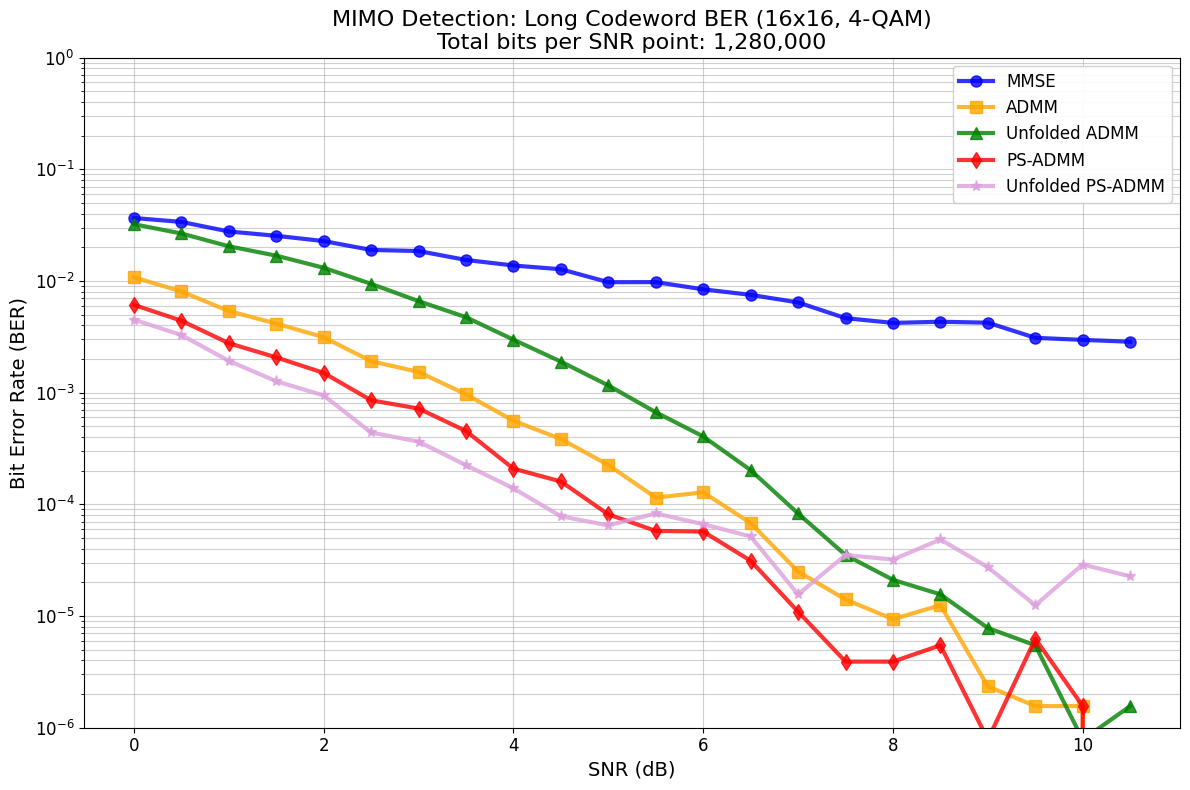

In [82]:
# Cell 8: Plot the results
print("Plotting long codeword BER results...")
plot_long_codeword_results(snr_db_list, ber_results_long)

In [83]:
# Cell 9: Display professional results table
print("\nProfessional BER Results - Long Codeword Approach:")
print("=" * 90)
print(f"{'SNR (dB)':<8} | {'MMSE':<12} | {'ADMM':<12} | {'U-ADMM':<12} | {'PS-ADMM':<12} | {'U-PS-ADMM':<12}")
print("-" * 90)

for i, snr in enumerate(snr_db_list):
    print(f"{snr:<8.1f} | {ber_results_long['MMSE'][i]:<12.2e} | {ber_results_long['ADMM'][i]:<12.2e} | "
          f"{ber_results_long['Unfolded ADMM'][i]:<12.2e} | {ber_results_long['PS-ADMM'][i]:<12.2e} | "
          f"{ber_results_long['Unfolded PS-ADMM'][i]:<12.2e}")

print("=" * 90)


Professional BER Results - Long Codeword Approach:
SNR (dB) | MMSE         | ADMM         | U-ADMM       | PS-ADMM      | U-PS-ADMM   
------------------------------------------------------------------------------------------
0.0      | 3.66e-02     | 1.08e-02     | 3.22e-02     | 6.11e-03     | 4.51e-03    
0.5      | 3.38e-02     | 8.06e-03     | 2.66e-02     | 4.41e-03     | 3.28e-03    
1.0      | 2.77e-02     | 5.37e-03     | 2.04e-02     | 2.77e-03     | 1.93e-03    
1.5      | 2.54e-02     | 4.15e-03     | 1.68e-02     | 2.07e-03     | 1.26e-03    
2.0      | 2.27e-02     | 3.13e-03     | 1.31e-02     | 1.50e-03     | 9.43e-04    
2.5      | 1.89e-02     | 1.91e-03     | 9.41e-03     | 8.54e-04     | 4.40e-04    
3.0      | 1.85e-02     | 1.53e-03     | 6.60e-03     | 7.20e-04     | 3.64e-04    
3.5      | 1.54e-02     | 9.66e-04     | 4.74e-03     | 4.53e-04     | 2.24e-04    
4.0      | 1.37e-02     | 5.60e-04     | 2.98e-03     | 2.09e-04     | 1.39e-04    
4.5      | 1.27e-

## code seeds random generation ONCE (global)

In [84]:
# Cell 1: Global random seed setup (ONCE)
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set global seeds ONCE at the beginning
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(GLOBAL_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Global random seed set to: {GLOBAL_SEED}")
print("All random generation will be deterministic from this point")

Global random seed set to: 42
All random generation will be deterministic from this point


In [85]:
# Cell 2: Global random state for reproducible channel generation
# Create global random state objects
global_np_rng = np.random.RandomState(GLOBAL_SEED)
global_torch_generator = torch.Generator()
global_torch_generator.manual_seed(GLOBAL_SEED)

print("Global random state objects created")

Global random state objects created


In [86]:
# Cell 3: Constellation and helper functions (deterministic)
def build_constellation(M):
    """Normalized square QAM constellation and Gray mapping."""
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)
    constellation = []
    bit_labels = []
    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))
    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation) ** 2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels

def quantize_to_constellation(x, constellation):
    """Quantize to nearest constellation point."""
    x_flat = x.reshape(-1, 1)
    d2 = np.abs(x_flat - constellation.reshape(1, -1)) ** 2
    idx = np.argmin(d2, axis=1)
    return constellation[idx].reshape(x.shape), idx.reshape(x.shape)

def complex_to_real_matrix(H_complex):
    """Convert complex matrix to real-valued equivalent [Re -Im; Im Re]"""
    H_real = np.real(H_complex)
    H_imag = np.imag(H_complex)
    H_equiv = np.block([[H_real, -H_imag], 
                        [H_imag, H_real]])
    return H_equiv

def complex_to_real_vector(x_complex):
    """Convert complex vector to real-valued equivalent [Re; Im]"""
    return np.concatenate([np.real(x_complex), np.imag(x_complex)])

def real_to_complex_vector(x_real):
    """Convert real-valued vector back to complex"""
    N = len(x_real) // 2
    return x_real[:N] + 1j * x_real[N:]

print("Deterministic helper functions defined")

Deterministic helper functions defined


In [87]:
# Cell 4: Data generation with global random state
def generate_long_codeword_data(B, U, M, num_symbols, snr_db, codeword_idx=0):
    """Generate long codeword data using global random state."""
    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))
    
    snr_lin = 10 ** (snr_db / 10)
    noise_var = 1 / snr_lin
    
    # Use global random state for reproducible channel generation
    # Different seed for each codeword to ensure diversity
    channel_seed = GLOBAL_SEED + codeword_idx * 1000
    channel_rng = np.random.RandomState(channel_seed)
    
    # Generate single channel realization for long codeword
    H_complex = (channel_rng.randn(B, U) + 1j * channel_rng.randn(B, U)) / np.sqrt(2)
    H_real = complex_to_real_matrix(H_complex)
    
    # Generate long sequence of symbols with deterministic but diverse randomness
    symbol_seed = GLOBAL_SEED + codeword_idx * 2000
    symbol_rng = np.random.RandomState(symbol_seed)
    
    total_bits = U * bits_per_symbol * num_symbols
    bits = symbol_rng.randint(0, 2, (num_symbols, U, bits_per_symbol))
    
    # Convert to complex symbols
    x_complex = np.array([[constellation[int("".join(map(str, b)), 2)] for b in symbol_bits] 
                         for symbol_bits in bits])
    
    # Generate noise with deterministic randomness
    noise_seed = GLOBAL_SEED + codeword_idx * 3000
    noise_rng = np.random.RandomState(noise_seed)
    noise_complex = np.sqrt(noise_var / 2) * (
        noise_rng.randn(num_symbols, B) + 1j * noise_rng.randn(num_symbols, B)
    )
    
    # Generate received signals
    y_complex = np.array([H_complex @ x_complex[i] + noise_complex[i] for i in range(num_symbols)])
    
    # Convert to real-valued equivalent
    y_real = np.array([complex_to_real_vector(y) for y in y_complex])
    x_real = np.array([complex_to_real_vector(x) for x in x_complex])
    
    return y_real, H_real, x_real, bits, constellation, bit_labels, total_bits, bits_per_symbol, U

print("Deterministic data generation function defined")

Deterministic data generation function defined


In [88]:
# Cell 5: Detector functions (deterministic operations)
def mmse_detector_batch_real(y_real_batch, H_real_batch, noise_var):
    """Batch MMSE detection with real-valued equivalent."""
    batch_size = y_real_batch.shape[0]
    U_real = H_real_batch.shape[2]
    x_hat_real_batch = np.zeros_like(y_real_batch)
    
    for i in range(batch_size):
        H = H_real_batch[i]
        y = y_real_batch[i]
        HtH = H.T @ H
        # Noise variance is halved in real domain
        x_hat_real_batch[i] = np.linalg.inv(HtH + (noise_var/2) * np.eye(U_real)) @ (H.T @ y)
    
    return x_hat_real_batch

def admm_detector_batch_real(y_real_batch, H_real_batch, rho=0.1, max_iter=30, tol=1e-4):
    """Batch ADMM detection with real-valued equivalent."""
    batch_size = y_real_batch.shape[0]
    U_real = H_real_batch.shape[2]
    x_hat_real_batch = np.zeros_like(y_real_batch)
    
    for i in range(batch_size):
        y = y_real_batch[i]
        H = H_real_batch[i]
        Ht = H.T
        inv_matrix = np.linalg.inv(Ht @ H + rho * np.eye(U_real))
        Hty = Ht @ y
        x = np.zeros(U_real)
        z = np.zeros(U_real)
        lam = np.zeros(U_real)
        
        for _ in range(max_iter):
            x = inv_matrix @ (Hty + rho * (z - lam))
            # Project to QPSK constellation in real domain (±1/√2)
            z_new = np.clip(x + lam, -1/np.sqrt(2), 1/np.sqrt(2))
            lam = lam + x - z_new
            if np.linalg.norm(x - z_new) < tol:
                break
            z = z_new
        
        x_hat_real_batch[i] = x
    
    return x_hat_real_batch

def ps_admm_detect_batch_real(y_real_batch, H_real_batch, M, rho=1.5, alpha=0.01, T=30):
    """Batch PS-ADMM detection with real-valued equivalent."""
    batch_size = y_real_batch.shape[0]
    U_real = H_real_batch.shape[2]
    U = U_real // 2  # Original complex dimension
    
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    x_hat_real_batch = np.zeros_like(y_real_batch)
    
    for i in range(batch_size):
        y = y_real_batch[i]
        H = H_real_batch[i]
        
        # PS-ADMM implementation in real domain
        xq = np.zeros((Q, U_real), dtype=np.float64)
        x0 = np.zeros(U_real, dtype=np.float64)
        dual_y = np.zeros(U_real, dtype=np.float64)
        scales = np.array([2 ** q for q in range(Q)])
        alpha_q = np.array([alpha] * Q)
        
        Ht = H.T
        HtH = Ht @ H
        Hty = Ht @ y
        A_inv = np.linalg.inv(HtH + rho * np.eye(U_real))
        
        for it in range(T):
            for q in range(Q):
                sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha_q[q]
                x_new = (scales[q] / denom) * numer
                # Project to QPSK in real domain (±1/√2)
                xq[q] = np.clip(x_new, -1/np.sqrt(2), 1/np.sqrt(2))
            
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
            rhs = Hty + rho * sum_scaled - dual_y
            x0 = A_inv @ rhs
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        x_hat_real_batch[i] = np.sum(scales.reshape(-1, 1) * xq, axis=0)
    
    return x_hat_real_batch

print("Deterministic detector functions defined")

Deterministic detector functions defined


In [89]:
# Cell 6: Neural network models with deterministic initialization
class UnfoldedADMMReal(nn.Module):
    def __init__(self, num_layers, U):
        super().__init__()
        self.num_layers = num_layers
        self.U = U
        self.U_real = 2 * U
        
        # Deterministic parameter initialization
        self.log_rho = nn.Parameter(torch.zeros(num_layers))
        self.log_gamma = nn.Parameter(torch.zeros(num_layers))
        
        # Ensure deterministic initialization
        with torch.no_grad():
            self.log_rho.data.normal_(0, 0.1)
            self.log_gamma.data.normal_(0, 0.1)

    def soft_project(self, x):
        """Soft projection for real-valued QPSK."""
        scale = 1.0 / np.sqrt(2)
        return scale * torch.tanh(10.0 * x)

    def forward(self, y, H):
        batch_size, N_real, U_real = H.shape
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        
        x = torch.zeros_like(Hty)
        z = torch.zeros_like(Hty)
        lam = torch.zeros_like(Hty)
        
        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            gamma = torch.exp(self.log_gamma[l])
            
            inv = torch.linalg.inv(HtH + rho * I)
            x = torch.bmm(inv, (Hty + rho * (z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + gamma * (x - z)
            
        return z

class UnfoldedPSADMMReal(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.U_real = 2 * U
        self.Q = Q
        self.L = L
        
        # Deterministic parameter initialization
        self.log_rho = nn.Parameter(torch.ones(L))
        self.log_alpha = nn.Parameter(torch.ones(L) * 0.01)
        
        # Ensure deterministic initialization
        with torch.no_grad():
            self.log_rho.data.normal_(0, 0.1)
            self.log_alpha.data.normal_(0, 0.1)

    def forward(self, H, y):
        batch_size, N_real, U_real = H.shape
        xq = torch.zeros(batch_size, self.Q, U_real, dtype=H.dtype, device=H.device)
        x0 = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        dual_y = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=H.dtype, device=H.device)
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        
        for l in range(self.L):
            rho = torch.exp(self.log_rho[l])
            alpha = torch.exp(self.log_alpha[l])
            
            A_inv = torch.linalg.inv(HtH + rho * I)
            
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                # Soft projection for QPSK in real domain
                xq[:, q, :] = (1.0 / np.sqrt(2)) * torch.tanh(10.0 * x_new)
            
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hty + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)
        
        return x0

print("Deterministic neural network models defined")

Deterministic neural network models defined


In [93]:
# Cell 6b: Fixed Unfolded PS-ADMM with proper constraints
class UnfoldedPSADMMReal(nn.Module):
    def __init__(self, U, Q, L):
        super().__init__()
        self.U = U
        self.U_real = 2 * U
        self.Q = Q
        self.L = L
        
        # Proper constrained initialization
        # rho should be positive and reasonably sized
        self.log_rho = nn.Parameter(torch.ones(L) * np.log(1.0))  # Start with rho=1.0
        
        # alpha should be small positive values
        self.log_alpha = nn.Parameter(torch.ones(L) * np.log(0.001))  # Start with alpha=0.001
        
        # Add trainable step sizes for better convergence
        self.step_sizes = nn.Parameter(torch.ones(L) * 0.1)

    def forward(self, H, y):
        batch_size, N_real, U_real = H.shape
        xq = torch.zeros(batch_size, self.Q, U_real, dtype=H.dtype, device=H.device)
        x0 = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        dual_y = torch.zeros(batch_size, U_real, dtype=H.dtype, device=H.device)
        
        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=H.dtype, device=H.device)
        Ht = H.transpose(1, 2)
        HtH = torch.bmm(Ht, H)
        Hty = torch.bmm(Ht, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U_real, dtype=H.dtype, device=H.device).unsqueeze(0)
        
        for l in range(self.L):
            # Constrained parameters - ensure they stay in reasonable ranges
            rho = torch.exp(self.log_rho[l]).clamp(0.1, 10.0)  # Constrain rho between 0.1 and 10
            alpha = torch.exp(self.log_alpha[l]).clamp(1e-4, 0.1)  # Constrain alpha between 1e-4 and 0.1
            step_size = self.step_sizes[l].clamp(0.01, 1.0)  # Constrain step size
            
            A_inv = torch.linalg.inv(HtH + rho * I)
            
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                
                # Add numerical stability
                denom = denom.clamp(1e-8, 1e8)
                
                x_new = (scales[q] / denom) * numer
                
                # Better soft projection with temperature parameter
                temperature = 10.0  # Fixed temperature for stability
                xq[:, q, :] = (1.0 / np.sqrt(2)) * torch.tanh(temperature * x_new)
            
            sum_scaled = torch.sum(scales.reshape(1, -1, 1) * xq, dim=1)
            rhs = Hty + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + step_size * rho * (x0 - sum_scaled)  # Use trainable step size
        
        return x0

print("Fixed Unfolded PS-ADMM with proper constraints defined")

Fixed Unfolded PS-ADMM with proper constraints defined


In [94]:
# Cell 7: BER calculation function
def calculate_ber_long_codeword(x_hat_real, true_bits, constellation, bit_labels, U, bits_per_symbol):
    """Calculate BER using long codeword approach."""
    # Convert estimates back to complex
    x_hat_complex = np.array([real_to_complex_vector(x) for x in x_hat_real])
    
    total_errors = 0
    total_bits = 0
    
    for i in range(len(x_hat_complex)):
        # Quantize to constellation
        x_hat_quantized, symbol_indices = quantize_to_constellation(x_hat_complex[i], constellation)
        
        # Get transmitted bits for this symbol
        true_symbol_bits = true_bits[i]
        
        # Get detected bits
        detected_bits = bit_labels[symbol_indices]
        
        # Calculate bit errors
        symbol_errors = np.sum(detected_bits != true_symbol_bits)
        total_errors += symbol_errors
        total_bits += U * bits_per_symbol
    
    return total_errors / total_bits if total_bits > 0 else 0.0

print("BER calculation function defined")

BER calculation function defined


In [95]:
# Cell 8: Main simulation with global randomness
def unified_simulation_long_codeword(B=16, U=16, M=4, num_codewords=50, symbols_per_codeword=1000, snr_db_list=np.arange(0, 11, 0.5)):
    """Simulation using global random seed for complete reproducibility."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    print(f"Global seed: {GLOBAL_SEED}")
    print(f"Long codeword approach: {num_codewords} codewords × {symbols_per_codeword} symbols")
    print(f"Total symbols per SNR: {num_codewords * symbols_per_codeword:,}")
    print(f"Total bits per SNR: {num_codewords * symbols_per_codeword * U * int(np.log2(M)):,}")
    
    # Initialize models with deterministic weights
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    
    unfolded_admm_real = UnfoldedADMMReal(num_layers=5, U=U).to(device)
    unfolded_psadmm_real = UnfoldedPSADMMReal(U=U, Q=Q, L=10).to(device)
    
    unfolded_admm_real.eval()
    unfolded_psadmm_real.eval()
    
    ber_results = {
        "MMSE": [],
        "ADMM": [], 
        "Unfolded ADMM": [],
        "PS-ADMM": [],
        "Unfolded PS-ADMM": []
    }
    
    for snr_db in tqdm(snr_db_list, desc="Processing SNRs"):
        ber_mmse = 0
        ber_admm = 0
        ber_unfolded_admm = 0
        ber_psadmm = 0
        ber_unfolded_psadmm = 0
        
        # Process multiple long codewords with deterministic diversity
        for codeword_idx in range(num_codewords):
            # Generate long codeword data with deterministic but diverse randomness
            y_real, H_real, x_real, true_bits, constellation, bit_labels, total_bits, bits_per_symbol, U_val = generate_long_codeword_data(
                B, U, M, symbols_per_codeword, snr_db, codeword_idx
            )
            
            snr_lin = 10 ** (snr_db / 10)
            noise_var = 1 / snr_lin
            
            # MMSE detection
            x_mmse_real = mmse_detector_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)), noise_var)
            ber_mmse += calculate_ber_long_codeword(x_mmse_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            
            # ADMM detection
            x_admm_real = admm_detector_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)))
            ber_admm += calculate_ber_long_codeword(x_admm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            
            # PS-ADMM detection
            x_psadmm_real = ps_admm_detect_batch_real(y_real, np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)), M)
            ber_psadmm += calculate_ber_long_codeword(x_psadmm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            
            # Unfolded detectors
            H_tensor = torch.tensor(np.tile(H_real[np.newaxis, :, :], (symbols_per_codeword, 1, 1)), dtype=torch.float32, device=device)
            y_tensor = torch.tensor(y_real, dtype=torch.float32, device=device)
            
            with torch.no_grad():
                x_unfolded_admm_real = unfolded_admm_real(y_tensor, H_tensor).cpu().numpy()
                x_unfolded_psadmm_real = unfolded_psadmm_real(H_tensor, y_tensor).cpu().numpy()
            
            ber_unfolded_admm += calculate_ber_long_codeword(x_unfolded_admm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
            ber_unfolded_psadmm += calculate_ber_long_codeword(x_unfolded_psadmm_real, true_bits, constellation, bit_labels, U_val, bits_per_symbol)
        
        # Average over all codewords
        ber_results["MMSE"].append(ber_mmse / num_codewords)
        ber_results["ADMM"].append(ber_admm / num_codewords)
        ber_results["Unfolded ADMM"].append(ber_unfolded_admm / num_codewords)
        ber_results["PS-ADMM"].append(ber_psadmm / num_codewords)
        ber_results["Unfolded PS-ADMM"].append(ber_unfolded_psadmm / num_codewords)
        
        print(f"SNR={snr_db:5.1f} dB | "
              f"MMSE: {ber_results['MMSE'][-1]:8.2e} | "
              f"ADMM: {ber_results['ADMM'][-1]:8.2e} | "
              f"U-ADMM: {ber_results['Unfolded ADMM'][-1]:8.2e} | "
              f"PS: {ber_results['PS-ADMM'][-1]:8.2e} | "
              f"U-PS: {ber_results['Unfolded PS-ADMM'][-1]:8.2e}")
    
    return snr_db_list, ber_results

print("Global random simulation function defined")

Global random simulation function defined


In [96]:
# Cell 9: Run the completely deterministic simulation
print("Starting GLOBALLY DETERMINISTIC simulation...")
print("Results will be 100% reproducible with the same seed")

snr_db_list, ber_results_long = unified_simulation_long_codeword(
    B=16, U=16, M=4,
    num_codewords=20,           # Fewer channel realizations
    symbols_per_codeword=2000,  # Longer codewords
    snr_db_list=np.arange(0, 11, 0.5)
)

print("\nGlobally deterministic simulation completed!")
print("You can run this again and get EXACTLY the same results")

Starting GLOBALLY DETERMINISTIC simulation...
Results will be 100% reproducible with the same seed
Using device: cpu
Global seed: 42
Long codeword approach: 20 codewords × 2000 symbols
Total symbols per SNR: 40,000
Total bits per SNR: 1,280,000


Processing SNRs:   5%|███                                                               | 1/22 [00:37<13:10, 37.65s/it]

SNR=  0.0 dB | MMSE: 3.66e-02 | ADMM: 1.13e-02 | U-ADMM: 3.50e-02 | PS: 6.31e-03 | U-PS: 1.24e-02


Processing SNRs:   9%|██████                                                            | 2/22 [01:15<12:34, 37.71s/it]

SNR=  0.5 dB | MMSE: 3.25e-02 | ADMM: 8.45e-03 | U-ADMM: 2.90e-02 | PS: 4.60e-03 | U-PS: 8.62e-03


Processing SNRs:  14%|█████████                                                         | 3/22 [01:53<11:58, 37.84s/it]

SNR=  1.0 dB | MMSE: 2.88e-02 | ADMM: 6.12e-03 | U-ADMM: 2.33e-02 | PS: 3.25e-03 | U-PS: 5.83e-03


Processing SNRs:  18%|████████████                                                      | 4/22 [02:31<11:19, 37.77s/it]

SNR=  1.5 dB | MMSE: 2.54e-02 | ADMM: 4.39e-03 | U-ADMM: 1.84e-02 | PS: 2.25e-03 | U-PS: 3.80e-03


Processing SNRs:  23%|███████████████                                                   | 5/22 [03:08<10:41, 37.73s/it]

SNR=  2.0 dB | MMSE: 2.23e-02 | ADMM: 3.08e-03 | U-ADMM: 1.41e-02 | PS: 1.54e-03 | U-PS: 2.37e-03


Processing SNRs:  27%|██████████████████                                                | 6/22 [03:46<10:04, 37.81s/it]

SNR=  2.5 dB | MMSE: 1.95e-02 | ADMM: 2.13e-03 | U-ADMM: 1.05e-02 | PS: 1.03e-03 | U-PS: 1.46e-03


Processing SNRs:  32%|█████████████████████                                             | 7/22 [04:25<09:32, 38.14s/it]

SNR=  3.0 dB | MMSE: 1.72e-02 | ADMM: 1.45e-03 | U-ADMM: 7.61e-03 | PS: 6.67e-04 | U-PS: 9.12e-04


Processing SNRs:  36%|████████████████████████                                          | 8/22 [05:05<09:02, 38.76s/it]

SNR=  3.5 dB | MMSE: 1.50e-02 | ADMM: 9.17e-04 | U-ADMM: 5.31e-03 | PS: 4.13e-04 | U-PS: 5.29e-04


Processing SNRs:  41%|███████████████████████████                                       | 9/22 [05:48<08:40, 40.03s/it]

SNR=  4.0 dB | MMSE: 1.31e-02 | ADMM: 5.93e-04 | U-ADMM: 3.60e-03 | PS: 2.59e-04 | U-PS: 3.31e-04


Processing SNRs:  45%|█████████████████████████████▌                                   | 10/22 [06:30<08:06, 40.56s/it]

SNR=  4.5 dB | MMSE: 1.14e-02 | ADMM: 3.70e-04 | U-ADMM: 2.30e-03 | PS: 1.58e-04 | U-PS: 2.02e-04


Processing SNRs:  50%|████████████████████████████████▌                                | 11/22 [07:11<07:28, 40.80s/it]

SNR=  5.0 dB | MMSE: 9.89e-03 | ADMM: 2.27e-04 | U-ADMM: 1.40e-03 | PS: 9.53e-05 | U-PS: 1.21e-04


Processing SNRs:  55%|███████████████████████████████████▍                             | 12/22 [07:50<06:42, 40.27s/it]

SNR=  5.5 dB | MMSE: 8.54e-03 | ADMM: 1.48e-04 | U-ADMM: 7.94e-04 | PS: 6.88e-05 | U-PS: 6.56e-05


Processing SNRs:  59%|██████████████████████████████████████▍                          | 13/22 [08:28<05:55, 39.54s/it]

SNR=  6.0 dB | MMSE: 7.36e-03 | ADMM: 8.67e-05 | U-ADMM: 4.29e-04 | PS: 3.75e-05 | U-PS: 3.75e-05


Processing SNRs:  64%|█████████████████████████████████████████▎                       | 14/22 [09:06<05:12, 39.04s/it]

SNR=  6.5 dB | MMSE: 6.37e-03 | ADMM: 5.39e-05 | U-ADMM: 2.14e-04 | PS: 2.34e-05 | U-PS: 2.27e-05


Processing SNRs:  68%|████████████████████████████████████████████▎                    | 15/22 [09:44<04:30, 38.67s/it]

SNR=  7.0 dB | MMSE: 5.51e-03 | ADMM: 3.13e-05 | U-ADMM: 1.02e-04 | PS: 1.56e-05 | U-PS: 1.56e-05


Processing SNRs:  73%|███████████████████████████████████████████████▎                 | 16/22 [10:21<03:50, 38.40s/it]

SNR=  7.5 dB | MMSE: 4.74e-03 | ADMM: 1.72e-05 | U-ADMM: 4.45e-05 | PS: 7.81e-06 | U-PS: 1.17e-05


Processing SNRs:  77%|██████████████████████████████████████████████████▏              | 17/22 [10:59<03:11, 38.26s/it]

SNR=  8.0 dB | MMSE: 4.11e-03 | ADMM: 9.38e-06 | U-ADMM: 2.34e-05 | PS: 5.47e-06 | U-PS: 1.09e-05


Processing SNRs:  82%|█████████████████████████████████████████████████████▏           | 18/22 [11:39<02:34, 38.57s/it]

SNR=  8.5 dB | MMSE: 3.54e-03 | ADMM: 5.47e-06 | U-ADMM: 1.25e-05 | PS: 3.91e-06 | U-PS: 1.09e-05


Processing SNRs:  86%|████████████████████████████████████████████████████████▏        | 19/22 [12:17<01:55, 38.36s/it]

SNR=  9.0 dB | MMSE: 3.04e-03 | ADMM: 3.91e-06 | U-ADMM: 5.47e-06 | PS: 2.34e-06 | U-PS: 8.59e-06


Processing SNRs:  91%|███████████████████████████████████████████████████████████      | 20/22 [12:54<01:16, 38.25s/it]

SNR=  9.5 dB | MMSE: 2.64e-03 | ADMM: 3.13e-06 | U-ADMM: 2.34e-06 | PS: 2.34e-06 | U-PS: 8.59e-06


Processing SNRs:  95%|██████████████████████████████████████████████████████████████   | 21/22 [13:33<00:38, 38.41s/it]

SNR= 10.0 dB | MMSE: 2.26e-03 | ADMM: 2.34e-06 | U-ADMM: 7.81e-07 | PS: 2.34e-06 | U-PS: 7.03e-06


Processing SNRs: 100%|█████████████████████████████████████████████████████████████████| 22/22 [14:12<00:00, 38.76s/it]

SNR= 10.5 dB | MMSE: 1.96e-03 | ADMM: 1.56e-06 | U-ADMM: 7.81e-07 | PS: 1.56e-06 | U-PS: 6.25e-06

Globally deterministic simulation completed!
You can run this again and get EXACTLY the same results


## Batch simulation, long codeword averaging, increased averaging massively

In [101]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [102]:
def build_constellation(M):
    k = int(np.log2(M))
    m_side = int(2 ** (k // 2))
    levels = np.arange(-(m_side - 1), m_side, 2)

    constellation = []
    bit_labels = []

    for ix in range(m_side):
        for iy in range(m_side):
            constellation.append(levels[ix] + 1j * levels[iy])
            bits = np.binary_repr(ix, width=k // 2) + np.binary_repr(iy, width=k // 2)
            bit_labels.append(np.array(list(bits), dtype=int))

    constellation = np.array(constellation)
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    bit_labels = np.array(bit_labels)
    return constellation, bit_labels


def quantize_to_constellation(x, constellation):
    x_flat = x.reshape(-1, 1)
    d2 = np.abs(x_flat - constellation.reshape(1, -1)) ** 2
    idx = np.argmin(d2, axis=1)
    return constellation[idx].reshape(x.shape), idx.reshape(x.shape)


def generate_channel(batch, B, U):
    """Rayleigh fading channel, now batched."""
    return (np.random.randn(batch, B, U) + 1j*np.random.randn(batch, B, U)) / np.sqrt(2)

In [103]:
def mmse_detector(y, H, noise_var):
    B, U = H.shape
    HhH = H.conj().T @ H
    return np.linalg.inv(HhH + noise_var*np.eye(U)) @ (H.conj().T @ y)


def admm_detector(y, H, rho=0.1, max_iter=20, tol=1e-4):
    B, U = H.shape
    Hh = H.conj().T
    inv_matrix = np.linalg.inv(Hh @ H + rho*np.eye(U))
    Hy = Hh @ y

    x = np.zeros(U, dtype=complex)
    z = np.zeros(U, dtype=complex)
    lam = np.zeros(U, dtype=complex)

    for _ in range(max_iter):
        x = inv_matrix @ (Hy + rho*(z - lam))
        z_new = np.clip(x.real + lam.real, -1, 1) \
              + 1j*np.clip(x.imag + lam.imag, -1, 1)
        lam = lam + x - z_new
        if np.linalg.norm(x - z_new) < tol:
            break
        z = z_new
    return x

In [104]:
def ps_admm_detect(H, r, M, rho=1.0, alpha=0.01, T=30):
    """
    Plain (classical) PS-ADMM detector per sample (numpy).
    H: (B, U) channel
    r: (B,) received vector
    returns: x_hat (U,)
    """
    m_side = int(np.sqrt(M))
    Q = m_side // 2
    U = H.shape[1]

    # Multi-scale decomposition variables
    xq = np.zeros((Q, U), dtype=np.complex128)
    x0 = np.zeros(U, dtype=np.complex128)
    dual_y = np.zeros(U, dtype=np.complex128)

    scales = np.array([2 ** q for q in range(Q)])
    alpha_q = np.array([alpha] * Q)

    HhH = H.conj().T @ H
    Hhr = H.conj().T @ r
    A_inv = np.linalg.inv(HhH + rho * np.eye(U))

    for it in range(T):
        for q in range(Q):
            # compute current sum excluding q-th
            sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0) - scales[q] * xq[q]
            numer = rho * x0 - rho * sum_scaled + dual_y
            denom = (4 ** q) * rho - alpha_q[q]
            x_new = (scales[q] / denom) * numer
            xq[q] = np.clip(np.real(x_new), -1, 1) + 1j * np.clip(np.imag(x_new), -1, 1)

        sum_scaled = np.sum(scales.reshape(-1, 1) * xq, axis=0)
        rhs = Hhr + rho * sum_scaled - dual_y
        x0 = A_inv @ rhs
        dual_y = dual_y + rho * (x0 - sum_scaled)

    return np.sum(scales.reshape(-1, 1) * xq, axis=0)

In [105]:
class UnfoldedADMM(nn.Module):
    def __init__(self, num_layers, M):
        super().__init__()
        self.num_layers = num_layers
        self.log_rho = nn.Parameter(torch.zeros(num_layers))

    def soft_project(self, x):
        return torch.complex(torch.tanh(x.real), torch.tanh(x.imag))

    def forward(self, y, H):
        # y: (batch, B), H: (batch, B, U)
        B, N, U = H.shape
        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhy = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=H.device).unsqueeze(0)

        x = torch.zeros_like(Hhy)
        z = torch.zeros_like(Hhy)
        lam = torch.zeros_like(Hhy)

        for l in range(self.num_layers):
            rho = torch.exp(self.log_rho[l])
            inv = torch.linalg.inv(HhH + rho * I)
            x = torch.bmm(inv, (Hhy + rho*(z - lam)).unsqueeze(-1)).squeeze(-1)
            z = self.soft_project(x + lam)
            lam = lam + x - z
        return z

In [106]:
class UnfoldedPSADMM(nn.Module):
    def __init__(self, U, Q, L):
        """
        Unfolded PS-ADMM (PyTorch). This keeps the structure of the earlier
        unfolded PS-ADMM but **only** used for inference in the simulation here.
        """
        super().__init__()
        self.U = U
        self.Q = Q
        self.L = L
        self.rho = nn.Parameter(torch.ones(L))
        self.alpha = nn.Parameter(torch.ones(L) * 0.01)

    def forward(self, H, y):
        # H: (batch, B, U), y: (batch, B)
        batch, B, U = H.shape
        device = H.device
        xq = torch.zeros(batch, self.Q, U, dtype=torch.cfloat, device=device)
        x0 = torch.zeros(batch, U, dtype=torch.cfloat, device=device)
        dual_y = torch.zeros(batch, U, dtype=torch.cfloat, device=device)

        scales = torch.tensor([2 ** q for q in range(self.Q)], dtype=torch.cfloat, device=device)

        Hh = torch.conj(H).transpose(1, 2)
        HhH = torch.bmm(Hh, H)
        Hhr = torch.bmm(Hh, y.unsqueeze(-1)).squeeze(-1)
        I = torch.eye(U, dtype=torch.cfloat, device=device).unsqueeze(0)

        for l in range(self.L):
            rho = self.rho[l]
            alpha = self.alpha[l]
            A_inv = torch.linalg.inv(HhH + rho * I)
            for q in range(self.Q):
                sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1) - scales[q] * xq[:, q, :]
                numer = rho * x0 - rho * sum_scaled + dual_y
                denom = (4 ** q) * rho - alpha
                x_new = (scales[q] / denom) * numer
                # non-linear projection via tanh
                xq[:, q, :] = torch.complex(torch.tanh(x_new.real), torch.tanh(x_new.imag))
            sum_scaled = torch.sum(scales.view(1, -1, 1) * xq, dim=1)
            rhs = Hhr + rho * sum_scaled - dual_y
            x0 = torch.bmm(A_inv, rhs.unsqueeze(-1)).squeeze(-1)
            dual_y = dual_y + rho * (x0 - sum_scaled)

        return x0

In [107]:
def unified_simulation(B=16, U=16, M=4,
                       trials=200_000,        # large effective averaging
                       batch_size=2000,       # samples per batch
                       snr_db_list=np.arange(0, 11, 0.5)):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    constellation, bit_labels = build_constellation(M)
    bits_per_symbol = int(np.log2(M))

    # Unfolded networks (kept on device; small, so ok for now)
    Q = int(np.sqrt(M)) // 2
    unfolded_admm = UnfoldedADMM(num_layers=5, M=U).to(device)
    unfolded_psadmm = UnfoldedPSADMM(U=U, Q=Q, L=10).to(device)

    method_names = ["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]
    ber = {name: [] for name in method_names}
    eps = 1e-9

    num_batches = trials // batch_size

    for snr_db in snr_db_list:
        snr_lin = 10 ** (snr_db / 10)
        noise_var = 1 / snr_lin

        errors = {k: 0 for k in ber.keys()}
        total_bits = num_batches * batch_size * U * bits_per_symbol

        for _ in range(num_batches):
            # Generate batch (long codeword)
            H_batch = generate_channel(batch_size, B, U)              # (batch, B, U)
            bits_batch = np.random.randint(0, 2, (batch_size, U, bits_per_symbol))
            # Map bits -> symbols
            x_batch = np.zeros((batch_size, U), dtype=np.complex128)
            for b in range(batch_size):
                for u in range(U):
                    sym_idx = int("".join(map(str, bits_batch[b, u])), 2)
                    x_batch[b, u] = constellation[sym_idx]

            noise = np.sqrt(noise_var/2) * (np.random.randn(batch_size, B) + 1j*np.random.randn(batch_size, B))
            # compute y = H @ x  for each batch sample
            y_batch = np.zeros((batch_size, B), dtype=np.complex128)
            for b in range(batch_size):
                y_batch[b] = H_batch[b] @ x_batch[b] + noise[b]

            # True indices for bit-error computation
            _, idx_true = quantize_to_constellation(x_batch, constellation)

            # --- Classical detectors (loop per batch sample) ---
            # MMSE and ADMM and PS-ADMM are numpy functions; call per sample
            for b in range(batch_size):
                # MMSE
                x_mm = mmse_detector(y_batch[b], H_batch[b], noise_var)
                _, idx_mm = quantize_to_constellation(x_mm, constellation)
                errors["MMSE"] += np.sum(bit_labels[idx_mm] != bit_labels[idx_true[b]])

                # ADMM
                x_admm = admm_detector(y_batch[b], H_batch[b])
                _, idx_a = quantize_to_constellation(x_admm, constellation)
                errors["ADMM"] += np.sum(bit_labels[idx_a] != bit_labels[idx_true[b]])

                # PS-ADMM (classical)
                x_ps = ps_admm_detect(H_batch[b], y_batch[b], M)
                _, idx_ps = quantize_to_constellation(x_ps, constellation)
                errors["PS-ADMM"] += np.sum(bit_labels[idx_ps] != bit_labels[idx_true[b]])

            # --- Unfolded detectors (batched PyTorch forward) ---
            H_t = torch.tensor(H_batch, dtype=torch.cfloat, device=device)
            y_t = torch.tensor(y_batch, dtype=torch.cfloat, device=device)

            with torch.no_grad():
                x_unf_admm = unfolded_admm(y_t, H_t).cpu().numpy()          # (batch, U)
                x_unf_ps = unfolded_psadmm(H_t, y_t).cpu().numpy()         # (batch, U)

            for b in range(batch_size):
                _, idx_uad = quantize_to_constellation(x_unf_admm[b], constellation)
                errors["Unfolded ADMM"] += np.sum(bit_labels[idx_uad] != bit_labels[idx_true[b]])

                _, idx_ups = quantize_to_constellation(x_unf_ps[b], constellation)
                errors["Unfolded PS-ADMM"] += np.sum(bit_labels[idx_ups] != bit_labels[idx_true[b]])

        # finalize BER for this SNR
        for k in ber:
            ber[k].append(max(errors[k] / total_bits, eps))

        print(f"SNR={snr_db} dB | " + ", ".join([f"{k}={ber[k][-1]:.2e}" for k in ber.keys()]))

    return snr_db_list, ber

In [108]:
def plot_unified(snr_db_list, ber):
    plt.figure(figsize=(8,6))
    markers = ['o', 's', '^', 'd', '*']
    for i, k in enumerate(["MMSE", "ADMM", "Unfolded ADMM", "PS-ADMM", "Unfolded PS-ADMM"]):
        if k in ber:
            plt.semilogy(snr_db_list, ber[k], marker=markers[i], label=k)
    plt.grid(True, which='both', linestyle='--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.legend()
    plt.title("16x16 4-QAM BER Comparison (Batch + Long Codeword Averaging)")
    plt.show()

SNR=0.0 dB | MMSE=3.32e-02, ADMM=3.23e-02, Unfolded ADMM=1.87e-02, PS-ADMM=2.25e-02, Unfolded PS-ADMM=1.36e-02
SNR=0.5 dB | MMSE=2.94e-02, ADMM=2.73e-02, Unfolded ADMM=1.50e-02, PS-ADMM=1.91e-02, Unfolded PS-ADMM=1.06e-02
SNR=1.0 dB | MMSE=2.60e-02, ADMM=2.31e-02, Unfolded ADMM=1.19e-02, PS-ADMM=1.61e-02, Unfolded PS-ADMM=8.14e-03
SNR=1.5 dB | MMSE=2.29e-02, ADMM=1.94e-02, Unfolded ADMM=9.40e-03, PS-ADMM=1.36e-02, Unfolded PS-ADMM=6.12e-03
SNR=2.0 dB | MMSE=2.02e-02, ADMM=1.63e-02, Unfolded ADMM=7.43e-03, PS-ADMM=1.14e-02, Unfolded PS-ADMM=4.67e-03
SNR=2.5 dB | MMSE=1.75e-02, ADMM=1.35e-02, Unfolded ADMM=5.72e-03, PS-ADMM=9.54e-03, Unfolded PS-ADMM=3.41e-03
SNR=3.0 dB | MMSE=1.54e-02, ADMM=1.12e-02, Unfolded ADMM=4.44e-03, PS-ADMM=7.94e-03, Unfolded PS-ADMM=2.51e-03
SNR=3.5 dB | MMSE=1.35e-02, ADMM=9.32e-03, Unfolded ADMM=3.50e-03, PS-ADMM=6.65e-03, Unfolded PS-ADMM=1.86e-03
SNR=4.0 dB | MMSE=1.17e-02, ADMM=7.69e-03, Unfolded ADMM=2.74e-03, PS-ADMM=5.51e-03, Unfolded PS-ADMM=1.36e-03
S

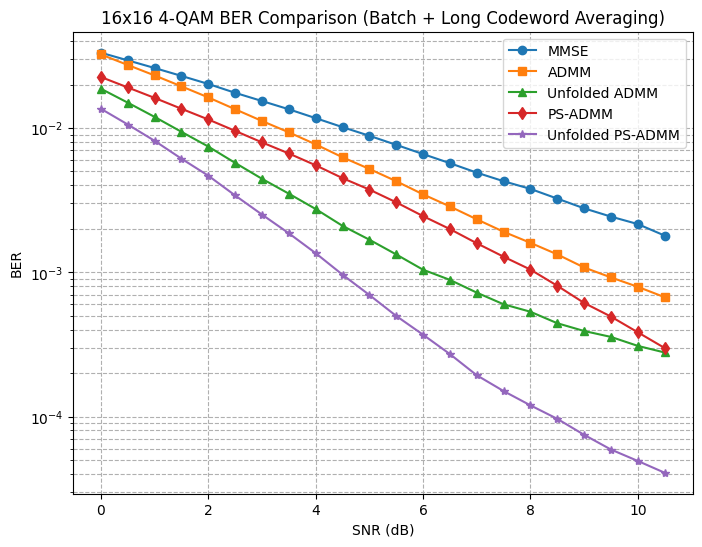

In [109]:
snr_db_list, ber = unified_simulation(trials=200_000, batch_size=2000, snr_db_list=np.arange(0, 11, 0.5))
plot_unified(snr_db_list, ber)